In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torch.optim as optim


import matplotlib
from importlib import reload
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torchbnn as bnn
%matplotlib inline
from IPython.core.debugger import set_trace
np.random.seed(7)
import torchbnn

from sklearn.metrics import r2_score
import hydrostats.ens_metrics as em

/env/miniconda3/envs/solar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data and select variables

In [2]:
solar_tensor_data = pickle.load( open( "Know_regression.pkl", "rb" ) )
# solar_tensor_data=PowerandWeather_fliped
temp=np.swapaxes(solar_tensor_data,0,1)
P_W_data=np.swapaxes(temp,1,2)
com_P_W_data=np.reshape(P_W_data,(731*96,13))

#add some time and date label
time_label=torch.ones(70176)
for i in range(731):
    time_label[96*i:96*(i+1)]=torch.arange(96)

time_label=time_label.unsqueeze(1)
time_label=time_label.numpy()

a=np.arange(365)
b=np.arange(366)
days=np.concatenate((a,b))
n_days=np.repeat(days, 96)

day_label=n_days[:, np.newaxis]
com_P_W_data=np.concatenate((com_P_W_data,time_label),axis=1)
com_P_W_data=np.concatenate((com_P_W_data,day_label),axis=1)
#monthly label
first=np.arange(12)
second=np.arange(12)
month=np.concatenate([first,second])
temp=month.repeat(30*96)
rest=np.zeros(len(com_P_W_data)-len(temp))
month_label=np.concatenate([temp,rest])
month_label=month_label[:, np.newaxis]

com_P_W_data=np.concatenate((com_P_W_data,month_label),axis=1)
P_W_data_inverterA=com_P_W_data
print(com_P_W_data.shape)
P_W_data_inverterA=com_P_W_data[...,[0,1,2,5,7,8,9,10,11,12,13,14]] 
print(P_W_data_inverterA.shape)
#InverterA_power*,curtail_utility*,curtail_on*,TBOM,Tamb,    WS*,ipoa(-3),ipoa2(-2)*,IGBT_derate_A*,IGBT_off_A*,IGBT_low*,watts*,Feeder_indicater,time_label, day_label
# P_W_data_inverterA.shapeP_W_data_inverterA.shape


(70176, 16)
(70176, 12)


# select summer rows



In [3]:
summer_index=np.where(P_W_data_inverterA[:,-1]<=153)[0]
P_W_data_inverterA=P_W_data_inverterA[summer_index,:]
print(P_W_data_inverterA.shape)



(29568, 12)


# data normalization and dataloader



In [4]:
#data preparation
ratio = 0.7
valid_ratio=0.05


for d in range(P_W_data_inverterA.shape[-1]):
    print('min:',np.min(P_W_data_inverterA[..., d]))
    print('max',np.max(P_W_data_inverterA[..., d]))
    P_W_data_inverterA[..., d] = (P_W_data_inverterA[..., d] - np.min(P_W_data_inverterA[..., d])) / (
        np.max(P_W_data_inverterA[..., d]) - np.min(P_W_data_inverterA[..., d])+1e-6)

v_index=round(valid_ratio * len(P_W_data_inverterA))
traj_valid=P_W_data_inverterA[:v_index,...]
train_idx = round(ratio * len(P_W_data_inverterA))
traj_train, traj_test = P_W_data_inverterA[v_index:train_idx+v_index, ...], P_W_data_inverterA[train_idx+v_index:, ...]
device = "cuda:0"
batch_size=32


def data_one_step(input):
    X=input[...,1:]
    Y=input[...,0]
    Y=Y[...,np.newaxis]
    return X, Y



def numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest):
    X_train_torch = torch.from_numpy(Xtrain).type(torch.Tensor).to(device)
    Y_train_torch = torch.from_numpy(Ytrain).type(torch.Tensor).to(device)

    X_test_torch = torch.from_numpy(Xtest).type(torch.Tensor).to(device)
    Y_test_torch =torch.from_numpy(Ytest).type(torch.Tensor).to(device)

    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

trainX,trainY=data_one_step(traj_train) 
testX,testY=data_one_step(traj_test)
validX,validY=data_one_step(traj_valid)
validX=torch.from_numpy(validX).type(torch.Tensor).to(device)
validY=torch.from_numpy(validY).type(torch.Tensor).to(device)
print(trainX.shape,trainY.shape)        
trainX , trainY ,  testX , testY =numpy_to_torch(trainX , trainY ,  testX , testY )


# trainY, testY=trainY.unsqueeze(1), testY.unsqueeze(1)
from torch.utils.data import DataLoader, TensorDataset
trainloader = DataLoader(TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=False)
testloader = DataLoader(TensorDataset(testX, testY), batch_size=batch_size, shuffle=False)
validloader = DataLoader(TensorDataset(validX, validY), batch_size=batch_size, shuffle=False)

trainloader_test = DataLoader(TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=False)

min: 0.0
max 2323364.8817553218
min: 5.0
max 5.0
min: 0.0
max 1.0
min: 0.0
max 0.0
min: 0.0
max 1241.5309431989276
min: 0.0
max 9.0
min: 0.0
max 3.0
min: 0.0
max 10.0
min: 0.0
max 1.0
min: 0.0
max 1.0
min: 0.0
max 95.0
min: 0.0
max 153.0


(20698, 11) (20698, 1)


In [5]:
from torch.utils.data import DataLoader, TensorDataset
import copy
rng = np.random.default_rng()
#IGBT-related constraints
output_1_index=np.where(traj_train[:,0]>0.2)[0]
output_1=traj_train[:,1:][output_1_index][:18432]
output_1[:,6]=0
derate_1=copy.deepcopy(output_1)
derate_1[:,4]=rng.integers(1,4)/9
derate_0=copy.deepcopy(output_1)
derate_0[:,4]=0
off_1=copy.deepcopy(output_1)
off_1[:,5]=rng.integers(1,2)/9
off_0=copy.deepcopy(output_1)
off_0[:,5]=0
con_batchsize=12

def numpy_to_loader(array0,array1):
    tensor0=torch.from_numpy(array0).type(torch.Tensor).to(device)
    tensor1=torch.from_numpy(array0).type(torch.Tensor).to(device)
    data_loader=DataLoader(TensorDataset(tensor0, tensor1), batch_size=con_batchsize, shuffle=True)   #The batch size is designed to match # of batches in trainloader
    return data_loader
   
derate_loader=numpy_to_loader(derate_0,derate_1)
off_loader   =numpy_to_loader(off_0,off_1)


In [6]:
class BayesianNet(nn.Module):
    def __init__(self):            # 4-100-3
        super(BayesianNet, self).__init__()
        self.hid1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.01,
          in_features=11, out_features=64)
        self.hid2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.02,#0.02
          in_features=64, out_features=32)
        self.oupt = bnn.BayesLinear(prior_mu=0, prior_sigma=0.01,
          in_features=32, out_features=1)


    def forward(self, x):
        y = F.relu(self.hid1(x))
        z = F.relu(self.hid2(y))
        z = self.oupt(z) 
        return z

        
        


In [26]:
##train

net = BayesianNet().to(device)
loss_func = torch.nn.MSELoss()  
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=True)
# train the network
for t in range(500):
    all_loss=0
    train_loss=0
    train_complexity_loss=0
    derate_loss=0
    off_loss=0

    if t<40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
    if t>=40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    if t>=90:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)
        
    for i, (x, y) in enumerate(trainloader):

        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        complexity_loss = kl_loss(net)
        total_loss=0.009*complexity_loss+loss
        optimizer.zero_grad()   # clear gradients for next train
        total_loss.backward()         # backpropagation, compute gradients
        train_loss += loss.item()*x.size(0)
        train_complexity_loss+= complexity_loss.item()*x.size(0)
        optimizer.step()
### test loss
    if t%5==0:  
        test_loss=0
        for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = net(data)

            loss = loss_func(output, target)
            # update running validation loss
            test_loss += loss.item()*data.size(0)
        test_loss_avg = test_loss/len(testloader.sampler)
        print('test loss:',test_loss_avg)
    if t%5==0:  
        valid_loss=0
        for i, (data, target) in enumerate(validloader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = net(data)

            loss = loss_func(output, target)
            # update running validation loss
            valid_loss += loss.item()*data.size(0)
        valid_loss_avg = valid_loss/len(validloader.sampler)
        print('valid loss:',valid_loss_avg)
    train_loss_avg = train_loss/len(trainloader.sampler)
    train_complexity_loss_avg=train_complexity_loss/len(trainloader.sampler)

    print('epoch:',t,'; loss: ',train_loss_avg,'complexity loss:',train_complexity_loss_avg)

test loss: 0.007856446821282888
valid loss: 0.009086623356245327
epoch: 0 ; loss:  0.07562803504851764 complexity loss: 4.707417023609267


epoch: 1 ; loss:  0.0050572865977353285 complexity loss: 0.0011831502981699195


epoch: 2 ; loss:  0.0034468444146208087 complexity loss: 0.001107162997991938


epoch: 3 ; loss:  0.0030924352389867494 complexity loss: 0.001215772509448182


epoch: 4 ; loss:  0.003116651603024282 complexity loss: 0.0009741857093547851


test loss: 0.0016299141820387117
valid loss: 0.008877160914679574
epoch: 5 ; loss:  0.00288248563800134 complexity loss: 0.0011199156159144668


epoch: 6 ; loss:  0.002718265109848997 complexity loss: 0.0010070578350930043


epoch: 7 ; loss:  0.002612724279461441 complexity loss: 0.0008921861095651473


epoch: 8 ; loss:  0.0026692311494083045 complexity loss: 0.0010497698013028473


epoch: 9 ; loss:  0.00260581889437639 complexity loss: 0.0008800679882409688


test loss: 0.0016102593912585166
valid loss: 0.006508377845070157
epoch: 10 ; loss:  0.002597316673939308 complexity loss: 0.0009284394814180445


epoch: 11 ; loss:  0.0025540740303733336 complexity loss: 0.0009927685012655195


epoch: 12 ; loss:  0.0026582865100573086 complexity loss: 0.001232208843011881


epoch: 13 ; loss:  0.002545698921601957 complexity loss: 0.0009997365140421907


epoch: 14 ; loss:  0.0024632844307665926 complexity loss: 0.001135382839810711


test loss: 0.0014239781393729518
valid loss: 0.007925075940102218
epoch: 15 ; loss:  0.0025644470074958543 complexity loss: 0.0011088437464562278


epoch: 16 ; loss:  0.002430950348531934 complexity loss: 0.0011394830219572162


epoch: 17 ; loss:  0.0023945840339371686 complexity loss: 0.0008690895256944089


epoch: 18 ; loss:  0.00224474101747204 complexity loss: 0.0007025942685857742


epoch: 19 ; loss:  0.0023334552215157627 complexity loss: 0.0009351954136232049


test loss: 0.0014824739959593903
valid loss: 0.005893090500399289
epoch: 20 ; loss:  0.002184307380874449 complexity loss: 0.0008249712607770487


epoch: 21 ; loss:  0.002432609327373577 complexity loss: 0.001136336675391979


epoch: 22 ; loss:  0.0023332093590576228 complexity loss: 0.000880122069564231


epoch: 23 ; loss:  0.0021588347092930567 complexity loss: 0.0007289883502728352


epoch: 24 ; loss:  0.0022255544310883766 complexity loss: 0.0010133685207744764


test loss: 0.0013306524584683927
valid loss: 0.004727696848047723
epoch: 25 ; loss:  0.0021155917253670798 complexity loss: 0.0008927423178326025


epoch: 26 ; loss:  0.00213632676532417 complexity loss: 0.0007779650992731597


epoch: 27 ; loss:  0.0020834175637649923 complexity loss: 0.0006362695212018168


epoch: 28 ; loss:  0.0020830058787217483 complexity loss: 0.0007678341296504967


epoch: 29 ; loss:  0.002014974339818847 complexity loss: 0.0007624818640799324


test loss: 0.00174375125172517
valid loss: 0.004445998029624577
epoch: 30 ; loss:  0.0019937150018731857 complexity loss: 0.0008244510433710489


epoch: 31 ; loss:  0.0019724848237102285 complexity loss: 0.0006443622987942369


epoch: 32 ; loss:  0.0020038005141303603 complexity loss: 0.000780982560657144


epoch: 33 ; loss:  0.002245114162893399 complexity loss: 0.0009677357772246963


epoch: 34 ; loss:  0.002074857677013992 complexity loss: 0.0008362179298264494


test loss: 0.0013384336053797706
valid loss: 0.004808558604972379
epoch: 35 ; loss:  0.002079149033106201 complexity loss: 0.0008255277973336867


epoch: 36 ; loss:  0.0019434945667222495 complexity loss: 0.0007395835726350295


epoch: 37 ; loss:  0.002148852085705515 complexity loss: 0.0008839031949413261


epoch: 38 ; loss:  0.0020746600625240483 complexity loss: 0.0008607894421222763


epoch: 39 ; loss:  0.0019490170184768903 complexity loss: 0.0008720306166474606


test loss: 0.0014963789727079966
valid loss: 0.0047753624555356144
epoch: 40 ; loss:  0.002162024107949786 complexity loss: 0.0006299871202251947


epoch: 41 ; loss:  0.0020933645169945864 complexity loss: 0.00066645021703073


epoch: 42 ; loss:  0.0019831973433107595 complexity loss: 0.000622705441533062


epoch: 43 ; loss:  0.002051746178341309 complexity loss: 0.0006313010775210121


epoch: 44 ; loss:  0.0020165222631964978 complexity loss: 0.0005481158699870905


test loss: 0.001361263055443558
valid loss: 0.004770195318942988
epoch: 45 ; loss:  0.002016576329776613 complexity loss: 0.0005434665694675857


epoch: 46 ; loss:  0.00199577729564274 complexity loss: 0.0006440687852270282


epoch: 47 ; loss:  0.001905065554264222 complexity loss: 0.0005433367858106749


epoch: 48 ; loss:  0.0018586244705909632 complexity loss: 0.00046118206074300256


epoch: 49 ; loss:  0.00192386180848801 complexity loss: 0.0004925080135440191


test loss: 0.0013315847927318418
valid loss: 0.00473475542155136
epoch: 50 ; loss:  0.0020617451433021924 complexity loss: 0.0006140949461399985


epoch: 51 ; loss:  0.001917329577329926 complexity loss: 0.00046207254227146065


epoch: 52 ; loss:  0.002026398479350328 complexity loss: 0.000561181710346711


epoch: 53 ; loss:  0.002039340707703925 complexity loss: 0.0005076515788628359


epoch: 54 ; loss:  0.001892556313216286 complexity loss: 0.0005068642031755962


test loss: 0.0014124077472358778
valid loss: 0.00478852546524322
epoch: 55 ; loss:  0.001959525331807337 complexity loss: 0.0005670291108778219


epoch: 56 ; loss:  0.001973385464773113 complexity loss: 0.0005805848566089025


epoch: 57 ; loss:  0.00188022163316519 complexity loss: 0.000445028758530502


epoch: 58 ; loss:  0.0019630008727952804 complexity loss: 0.0004841315249841977


epoch: 59 ; loss:  0.0018998164949281862 complexity loss: 0.000437475008738307


test loss: 0.0013656370825329755
valid loss: 0.0032405219987886725
epoch: 60 ; loss:  0.001980069777831327 complexity loss: 0.0006215752397876901


epoch: 61 ; loss:  0.0018513967162993234 complexity loss: 0.0004021359971323178


epoch: 62 ; loss:  0.00196812136242002 complexity loss: 0.000497319131833319


epoch: 63 ; loss:  0.00190146294753386 complexity loss: 0.0004853678620464042


epoch: 64 ; loss:  0.0020144594266457085 complexity loss: 0.0005787782178822204


test loss: 0.0013955996392090156
valid loss: 0.0035014300810674733
epoch: 65 ; loss:  0.0018771879703791778 complexity loss: 0.0004993597428364873


epoch: 66 ; loss:  0.0019334952026477767 complexity loss: 0.0005128370044150552


epoch: 67 ; loss:  0.0018249857674154685 complexity loss: 0.0004088457211951424


epoch: 68 ; loss:  0.0019122231882618083 complexity loss: 0.0005072775480539652


epoch: 69 ; loss:  0.0019136298678587903 complexity loss: 0.000528059554959348


test loss: 0.001241760701328507
valid loss: 0.004304471926975376
epoch: 70 ; loss:  0.0019057261838947171 complexity loss: 0.0004654366309567458


epoch: 71 ; loss:  0.0018820387622844588 complexity loss: 0.0005171057198609531


epoch: 72 ; loss:  0.00184230266080892 complexity loss: 0.0004845211524089784


epoch: 73 ; loss:  0.001946322517981296 complexity loss: 0.0005691225879583305


epoch: 74 ; loss:  0.0018670758451035684 complexity loss: 0.00048526973237806106


test loss: 0.001257397763970501
valid loss: 0.00501704776624321
epoch: 75 ; loss:  0.0018312645052662691 complexity loss: 0.0004320684775417813


epoch: 76 ; loss:  0.0018809693222713376 complexity loss: 0.0004754915008430654


epoch: 77 ; loss:  0.001825223782405659 complexity loss: 0.00038598394472249544


epoch: 78 ; loss:  0.0019081333416326042 complexity loss: 0.0004800851361879877


epoch: 79 ; loss:  0.0018989382962138217 complexity loss: 0.0004922901562347839


test loss: 0.001229299985677295
valid loss: 0.003477758486630428
epoch: 80 ; loss:  0.0019428575303415331 complexity loss: 0.00040807185144006996


epoch: 81 ; loss:  0.0019022277311431589 complexity loss: 0.00044464570264883557


epoch: 82 ; loss:  0.0019263381422623207 complexity loss: 0.0004669226866572914


epoch: 83 ; loss:  0.0018371930187156245 complexity loss: 0.0004640420009138642


epoch: 84 ; loss:  0.0018262565587115803 complexity loss: 0.0004055181186848164


test loss: 0.0014624767060501468
valid loss: 0.0034130572879192936
epoch: 85 ; loss:  0.0018542057631803159 complexity loss: 0.0004588467036483253


epoch: 86 ; loss:  0.0017766517487849463 complexity loss: 0.00040545570918333937


epoch: 87 ; loss:  0.001891841114887967 complexity loss: 0.00047164605382399023


epoch: 88 ; loss:  0.001832056738502754 complexity loss: 0.00048733785055906764


epoch: 89 ; loss:  0.0018994812262577926 complexity loss: 0.0004919141729691948


test loss: 0.0012630445884284412
valid loss: 0.003575850584379149
epoch: 90 ; loss:  0.0019356964647249092 complexity loss: 0.00048744457334075553


epoch: 91 ; loss:  0.0019189903036609267 complexity loss: 0.00042858215585078854


epoch: 92 ; loss:  0.0018202038748705717 complexity loss: 0.0003261323861654674


epoch: 93 ; loss:  0.001935812321243489 complexity loss: 0.0003693758295243323


epoch: 94 ; loss:  0.001901932428957465 complexity loss: 0.0004785652148664856


test loss: 0.0013108976216567479
valid loss: 0.0040617501766437285
epoch: 95 ; loss:  0.0019549304425194223 complexity loss: 0.00042605292959505377


epoch: 96 ; loss:  0.0018584658249780719 complexity loss: 0.00038365099508182496


epoch: 97 ; loss:  0.0018940936802382452 complexity loss: 0.00034753427216137925


epoch: 98 ; loss:  0.0017552388655808987 complexity loss: 0.0003005115637307882


epoch: 99 ; loss:  0.0018030849565779782 complexity loss: 0.00029357641442914734


test loss: 0.0012729007658335476
valid loss: 0.0031913554276048594
epoch: 100 ; loss:  0.0018282166814981744 complexity loss: 0.00029589617490791473


epoch: 101 ; loss:  0.0019074836890611011 complexity loss: 0.0003296724781689177


epoch: 102 ; loss:  0.0018092598766911066 complexity loss: 0.00031437151834508374


epoch: 103 ; loss:  0.001897554458012729 complexity loss: 0.0003709946119655145


epoch: 104 ; loss:  0.0017714203507710603 complexity loss: 0.00030035896109594727


test loss: 0.001335817520480285
valid loss: 0.0030362391482070795
epoch: 105 ; loss:  0.001732122350561143 complexity loss: 0.0002680564343681634


epoch: 106 ; loss:  0.0018095799879976964 complexity loss: 0.00036424084531706835


epoch: 107 ; loss:  0.0018904480777377445 complexity loss: 0.0003013410525847684


epoch: 108 ; loss:  0.0018090540401948458 complexity loss: 0.0002953897571665087


epoch: 109 ; loss:  0.0017889157078933727 complexity loss: 0.0003053486687006588


test loss: 0.0013029932242755685
valid loss: 0.0019333556974029447
epoch: 110 ; loss:  0.0018202698350035084 complexity loss: 0.0003307151418916844


epoch: 111 ; loss:  0.0018203021499673725 complexity loss: 0.0002820963836059511


epoch: 112 ; loss:  0.0018044434789637276 complexity loss: 0.00030688740617584544


epoch: 113 ; loss:  0.0018211885168999678 complexity loss: 0.0003464452332719557


epoch: 114 ; loss:  0.0018653659234534577 complexity loss: 0.000353875517534143


test loss: 0.0012602030522103353
valid loss: 0.002779500678380767
epoch: 115 ; loss:  0.0018098656937002692 complexity loss: 0.00035938159522601104


epoch: 116 ; loss:  0.001766157222858008 complexity loss: 0.0002965614788543085


epoch: 117 ; loss:  0.0017650185448353061 complexity loss: 0.00027321356369661403


epoch: 118 ; loss:  0.0018152000065845113 complexity loss: 0.00030303901031358496


epoch: 119 ; loss:  0.0017533462873304628 complexity loss: 0.00029782537492948724


test loss: 0.0013865392248704248
valid loss: 0.002343609910968726
epoch: 120 ; loss:  0.0018147816121868124 complexity loss: 0.0003088284591647528


epoch: 121 ; loss:  0.0018152697132543653 complexity loss: 0.000280245846280131


epoch: 122 ; loss:  0.0017962583568239645 complexity loss: 0.0003635963387783742


epoch: 123 ; loss:  0.0017890051257101424 complexity loss: 0.00033261180096795013


epoch: 124 ; loss:  0.0017660747169987547 complexity loss: 0.0002914365218657666


test loss: 0.0012352212610281853
valid loss: 0.0025521993504128895
epoch: 125 ; loss:  0.0017986507468917008 complexity loss: 0.0002971160859920654


epoch: 126 ; loss:  0.001890473458747046 complexity loss: 0.0003704660260650844


epoch: 127 ; loss:  0.0018100743479221692 complexity loss: 0.0002988971412003311


epoch: 128 ; loss:  0.001825971584572834 complexity loss: 0.0003173465267542261


epoch: 129 ; loss:  0.0018604263689078729 complexity loss: 0.00033829529880498245


test loss: 0.001292285980454906
valid loss: 0.0025105990216776185
epoch: 130 ; loss:  0.0017502844356717718 complexity loss: 0.0002370794932846171


epoch: 131 ; loss:  0.0017994553901688906 complexity loss: 0.00032287431184837054


epoch: 132 ; loss:  0.0017695770277502043 complexity loss: 0.0002997109182492145


epoch: 133 ; loss:  0.001663026584742201 complexity loss: 0.00023414196167744142


epoch: 134 ; loss:  0.0017735540166700656 complexity loss: 0.00033064530844710994


test loss: 0.0012869208371759347
valid loss: 0.0027605394778599276
epoch: 135 ; loss:  0.0017393807215980157 complexity loss: 0.0003177010387553721


epoch: 136 ; loss:  0.0018356896410315628 complexity loss: 0.00029427280793709276


epoch: 137 ; loss:  0.0017781844238236614 complexity loss: 0.00029824658722932333


epoch: 138 ; loss:  0.0018024004739956732 complexity loss: 0.0002959280131991813


epoch: 139 ; loss:  0.001764650606846129 complexity loss: 0.0002886890005818864


test loss: 0.0013368488768928217
valid loss: 0.0029485813034534534
epoch: 140 ; loss:  0.0018306003417399171 complexity loss: 0.00034298417256965606


epoch: 141 ; loss:  0.0018057764274273963 complexity loss: 0.00031380020301576304


epoch: 142 ; loss:  0.0018246681574806709 complexity loss: 0.00035524265191810514


epoch: 143 ; loss:  0.001758988693140523 complexity loss: 0.00029158472427366687


epoch: 144 ; loss:  0.0018718890643683404 complexity loss: 0.00035371800208047966


test loss: 0.001377360101629732
valid loss: 0.002860504787299323
epoch: 145 ; loss:  0.001866940349921347 complexity loss: 0.00033890193113901497


epoch: 146 ; loss:  0.0018466532000676573 complexity loss: 0.00031244318224241314


epoch: 147 ; loss:  0.0018082137677366734 complexity loss: 0.00031270982793177115


epoch: 148 ; loss:  0.001722682796102504 complexity loss: 0.000303253757514773


epoch: 149 ; loss:  0.0017972982414838582 complexity loss: 0.0003134714876330294


test loss: 0.001320309057003124
valid loss: 0.002693578862384748
epoch: 150 ; loss:  0.0018465875601619255 complexity loss: 0.00034177333263397583


epoch: 151 ; loss:  0.0018338410299598036 complexity loss: 0.00033077397476890744


epoch: 152 ; loss:  0.0017695494764534804 complexity loss: 0.00030230977636844664


epoch: 153 ; loss:  0.0017859905423305243 complexity loss: 0.00030524532096214786


epoch: 154 ; loss:  0.001822289223966807 complexity loss: 0.0003295861669111533


test loss: 0.001204153739993896
valid loss: 0.003049316209538037
epoch: 155 ; loss:  0.0017678278607779895 complexity loss: 0.00030665400408583454


epoch: 156 ; loss:  0.0017531365342906178 complexity loss: 0.0003093883304483523


epoch: 157 ; loss:  0.0017769148099701648 complexity loss: 0.0003246369771029433


epoch: 158 ; loss:  0.0017790417312482211 complexity loss: 0.00029001347465047007


epoch: 159 ; loss:  0.001746623074892612 complexity loss: 0.00030511808298626825


test loss: 0.0012830368523203488
valid loss: 0.0021982701679285873
epoch: 160 ; loss:  0.0018158734053281569 complexity loss: 0.00031437978892870507


epoch: 161 ; loss:  0.0017719367918546968 complexity loss: 0.00027408457825248145


epoch: 162 ; loss:  0.001865360507997366 complexity loss: 0.00034575580295036006


epoch: 163 ; loss:  0.001807980176526603 complexity loss: 0.0002846569989151235


epoch: 164 ; loss:  0.0017259792939678506 complexity loss: 0.0002711445182426527


test loss: 0.001417747447719481
valid loss: 0.0024146596788956766
epoch: 165 ; loss:  0.001802982452952494 complexity loss: 0.0003218689291059527


epoch: 166 ; loss:  0.0018129804583580627 complexity loss: 0.00033575178909006875


epoch: 167 ; loss:  0.0017256347747791252 complexity loss: 0.00029729960540467756


epoch: 168 ; loss:  0.001772927308401154 complexity loss: 0.0002354732031107571


epoch: 169 ; loss:  0.0017183652734204407 complexity loss: 0.00024912320239404073


test loss: 0.00122148554149556
valid loss: 0.0027196100952055846
epoch: 170 ; loss:  0.0017751821281206687 complexity loss: 0.0002686421368269313


epoch: 171 ; loss:  0.0018368867087265202 complexity loss: 0.00031082653656064834


epoch: 172 ; loss:  0.0017225318045217422 complexity loss: 0.0002740767741850671


epoch: 173 ; loss:  0.0017782574090411411 complexity loss: 0.0002766194833351317


epoch: 174 ; loss:  0.00176101038444418 complexity loss: 0.00029326736184062213


test loss: 0.0013612343561689437
valid loss: 0.0017846645812563224
epoch: 175 ; loss:  0.001738284069748785 complexity loss: 0.00024415426339973215


epoch: 176 ; loss:  0.0017223305206670314 complexity loss: 0.0002574188051068019


epoch: 177 ; loss:  0.0018580664507091935 complexity loss: 0.0002960377136213513


epoch: 178 ; loss:  0.0018110059702818463 complexity loss: 0.00032734364078222054


epoch: 179 ; loss:  0.0017176226929097376 complexity loss: 0.00028791110496473077


test loss: 0.0012950735274060137
valid loss: 0.002736047202505736
epoch: 180 ; loss:  0.001715858455533681 complexity loss: 0.00029377244338745976


epoch: 181 ; loss:  0.001723136343989737 complexity loss: 0.00028321223853809127


epoch: 182 ; loss:  0.001763009564723811 complexity loss: 0.0002588090464416616


epoch: 183 ; loss:  0.0017771058962648002 complexity loss: 0.00027545406825531623


epoch: 184 ; loss:  0.0017446085692279186 complexity loss: 0.00024765651575527693


test loss: 0.0013142706891072656
valid loss: 0.0025892772066566957
epoch: 185 ; loss:  0.0017551133854662438 complexity loss: 0.0002929170024096649


epoch: 186 ; loss:  0.0017167807813926825 complexity loss: 0.0002664352963081085


epoch: 187 ; loss:  0.0017600284065239949 complexity loss: 0.00029223310116904176


epoch: 188 ; loss:  0.0018020553373177292 complexity loss: 0.00028143087807848025


epoch: 189 ; loss:  0.0016768241040313108 complexity loss: 0.00024322439292880438


test loss: 0.0012596763138102672
valid loss: 0.0019442899842936853
epoch: 190 ; loss:  0.0018136753839856764 complexity loss: 0.00034412908397419856


epoch: 191 ; loss:  0.0017496315647308463 complexity loss: 0.0002919784178767461


epoch: 192 ; loss:  0.0017013531865265265 complexity loss: 0.00029795380511345155


epoch: 193 ; loss:  0.0017670997925787618 complexity loss: 0.0002338976569308879


epoch: 194 ; loss:  0.0016867916768041682 complexity loss: 0.00022143355336485537


test loss: 0.0013593368467411683
valid loss: 0.00175607481644349
epoch: 195 ; loss:  0.00176063555169598 complexity loss: 0.00029346820570694813


epoch: 196 ; loss:  0.0016805783899207808 complexity loss: 0.0002753899481944133


epoch: 197 ; loss:  0.001743940527015584 complexity loss: 0.0002635538963917223


epoch: 198 ; loss:  0.0017469058103013178 complexity loss: 0.0002657145518060467


epoch: 199 ; loss:  0.0017612965399730423 complexity loss: 0.0003157303015129936


test loss: 0.0012754389004462079
valid loss: 0.0022080031517232707
epoch: 200 ; loss:  0.001723751017124508 complexity loss: 0.0002938022889057926


epoch: 201 ; loss:  0.0017744611799086671 complexity loss: 0.0002859176869714464


epoch: 202 ; loss:  0.001666829031139679 complexity loss: 0.0002442176520092981


epoch: 203 ; loss:  0.0018179416078003133 complexity loss: 0.00029068319034272316


epoch: 204 ; loss:  0.0017250920817888974 complexity loss: 0.000309609574319683


test loss: 0.001330111736953445
valid loss: 0.0019132596694553053
epoch: 205 ; loss:  0.00170737515871004 complexity loss: 0.00024904888809009477


epoch: 206 ; loss:  0.0016504784502575855 complexity loss: 0.00026837603828621114


epoch: 207 ; loss:  0.0018001168510109282 complexity loss: 0.000318307544381299


epoch: 208 ; loss:  0.0016851109167960014 complexity loss: 0.00029412724912103244


epoch: 209 ; loss:  0.0017620753574021308 complexity loss: 0.0002505105179235525


test loss: 0.0013764269157485166
valid loss: 0.0023802411417994792
epoch: 210 ; loss:  0.0016833951674078268 complexity loss: 0.00022961890850680867


epoch: 211 ; loss:  0.0018340773957194597 complexity loss: 0.00028710503983191214


epoch: 212 ; loss:  0.0017597607431834473 complexity loss: 0.0002605908906958578


epoch: 213 ; loss:  0.0017118807752918603 complexity loss: 0.000268720620979444


epoch: 214 ; loss:  0.0018327489313772882 complexity loss: 0.00029044071134478244


test loss: 0.0012808278165937822
valid loss: 0.002060062800822666
epoch: 215 ; loss:  0.001668091312555492 complexity loss: 0.00026192115878054386


epoch: 216 ; loss:  0.0017062300443183023 complexity loss: 0.0002478258035438443


epoch: 217 ; loss:  0.0017727402163309467 complexity loss: 0.00028433998099432233


epoch: 218 ; loss:  0.0016818331637393179 complexity loss: 0.00026104264540860754


epoch: 219 ; loss:  0.0017464594057529765 complexity loss: 0.0002858626035022579


test loss: 0.0012190821869422286
valid loss: 0.0018307143900762734
epoch: 220 ; loss:  0.0017407345068565752 complexity loss: 0.0002618009646234449


epoch: 221 ; loss:  0.0017729700209081175 complexity loss: 0.0002752575439835


epoch: 222 ; loss:  0.001733831122490431 complexity loss: 0.00026092118992991165


epoch: 223 ; loss:  0.001758490539721295 complexity loss: 0.00023708373224669602


epoch: 224 ; loss:  0.0016634005129918124 complexity loss: 0.0002220541696661808


test loss: 0.001223987685631128
valid loss: 0.0021318394652314492
epoch: 225 ; loss:  0.0017786445095263346 complexity loss: 0.00025559018828325404


epoch: 226 ; loss:  0.0017003880518337445 complexity loss: 0.00025834065265086025


epoch: 227 ; loss:  0.0017418219806740875 complexity loss: 0.00024856269181045384


epoch: 228 ; loss:  0.0017001696225483975 complexity loss: 0.0002443410311474156


epoch: 229 ; loss:  0.0017736478445608203 complexity loss: 0.0003579800307940764


test loss: 0.001263661226214215
valid loss: 0.002230450602661672
epoch: 230 ; loss:  0.0016879980381425694 complexity loss: 0.00030062289407995315


epoch: 231 ; loss:  0.0017525085308668009 complexity loss: 0.0002893784539413194


epoch: 232 ; loss:  0.001698437057774747 complexity loss: 0.0003074083607926416


epoch: 233 ; loss:  0.0016746405259041065 complexity loss: 0.0002668605747862431


epoch: 234 ; loss:  0.0016670177110081799 complexity loss: 0.0002805333066555668


test loss: 0.0012016383409140419
valid loss: 0.0017938092637665983
epoch: 235 ; loss:  0.0017450221066574506 complexity loss: 0.00027987911846571144


epoch: 236 ; loss:  0.0016822510499499754 complexity loss: 0.00022976358612558902


epoch: 237 ; loss:  0.001740526282435032 complexity loss: 0.00024401587511055803


epoch: 238 ; loss:  0.0016710781338358112 complexity loss: 0.0002530572126194848


epoch: 239 ; loss:  0.0017332414788440726 complexity loss: 0.0003002481490981234


test loss: 0.0013011129313856373
valid loss: 0.002190428937839518
epoch: 240 ; loss:  0.0017183907358611996 complexity loss: 0.000263650355816855


epoch: 241 ; loss:  0.0017541608710945555 complexity loss: 0.00030906518446280654


epoch: 242 ; loss:  0.0017090944853646252 complexity loss: 0.0003380900316738785


epoch: 243 ; loss:  0.0017084900815202274 complexity loss: 0.00028922047773090835


epoch: 244 ; loss:  0.0016735138022626276 complexity loss: 0.0002727523289137802


test loss: 0.0012537430575714917
valid loss: 0.001935944879548536
epoch: 245 ; loss:  0.001806399236050609 complexity loss: 0.0002710650665009698


epoch: 246 ; loss:  0.0016755278989724878 complexity loss: 0.000290624703033061


epoch: 247 ; loss:  0.001679338405013081 complexity loss: 0.00025645163061768783


epoch: 248 ; loss:  0.0016682349352497069 complexity loss: 0.0002645176612809034


epoch: 249 ; loss:  0.0016937022915658366 complexity loss: 0.00024588058070637017


test loss: 0.0013348453985796778
valid loss: 0.0023596776220556827
epoch: 250 ; loss:  0.0017526853484790196 complexity loss: 0.00029394567064622


epoch: 251 ; loss:  0.0017391879853441252 complexity loss: 0.00031499947795707577


epoch: 252 ; loss:  0.001671077923948092 complexity loss: 0.00026361840233640147


epoch: 253 ; loss:  0.001724597656342841 complexity loss: 0.00027895333145146027


epoch: 254 ; loss:  0.0017859385004859874 complexity loss: 0.00030207390922983555


test loss: 0.0013259817756650324
valid loss: 0.002033476217609549
epoch: 255 ; loss:  0.001707287294044816 complexity loss: 0.00024787500084558076


epoch: 256 ; loss:  0.0017450192578774893 complexity loss: 0.0002768673359086426


epoch: 257 ; loss:  0.001692024221159097 complexity loss: 0.0002874091853610743


epoch: 258 ; loss:  0.0017785961731653422 complexity loss: 0.0002901318085022002


epoch: 259 ; loss:  0.0017306752587075813 complexity loss: 0.0002638734542340953


test loss: 0.0012388429922282039
valid loss: 0.0020788415931845754
epoch: 260 ; loss:  0.0016701477584757161 complexity loss: 0.0002380621492004542


epoch: 261 ; loss:  0.0017150731786638735 complexity loss: 0.00023774370869319444


epoch: 262 ; loss:  0.0017413280445226467 complexity loss: 0.00030708430481251914


epoch: 263 ; loss:  0.0016799144023535888 complexity loss: 0.0002580409303864761


epoch: 264 ; loss:  0.0016396692080231537 complexity loss: 0.0002484509295018379


test loss: 0.0013350752598451838
valid loss: 0.0019038357929936553
epoch: 265 ; loss:  0.00173248204936672 complexity loss: 0.0003085904495072648


epoch: 266 ; loss:  0.0016704563541461957 complexity loss: 0.00024022415232826562


epoch: 267 ; loss:  0.0016262979789007247 complexity loss: 0.00022686996463646992


epoch: 268 ; loss:  0.0017718437440838355 complexity loss: 0.0002494916926030203


epoch: 269 ; loss:  0.0016620532101040543 complexity loss: 0.00028486719038396864


test loss: 0.0012245606656553672
valid loss: 0.0019696914633901105
epoch: 270 ; loss:  0.001754036339556257 complexity loss: 0.0002914159893931968


epoch: 271 ; loss:  0.0017148716355594954 complexity loss: 0.000312242419008518


epoch: 272 ; loss:  0.0017510117449528171 complexity loss: 0.00030112423197821566


epoch: 273 ; loss:  0.001752688462837893 complexity loss: 0.00028780897247214195


epoch: 274 ; loss:  0.0017172003365487035 complexity loss: 0.0002707162794024141


test loss: 0.0012827277205045612
valid loss: 0.0020145468343886093
epoch: 275 ; loss:  0.0017320494100963567 complexity loss: 0.0003307034098729959


epoch: 276 ; loss:  0.0016701429280659545 complexity loss: 0.00030174898357135176


epoch: 277 ; loss:  0.0017780977156098203 complexity loss: 0.0002868861573389134


epoch: 278 ; loss:  0.0016797572215936241 complexity loss: 0.0002707775658093186


epoch: 279 ; loss:  0.0016688026155692386 complexity loss: 0.0002720384324088812


test loss: 0.0011933138568833211
valid loss: 0.0021673360313648037
epoch: 280 ; loss:  0.001752741712100669 complexity loss: 0.00031022235775629743


epoch: 281 ; loss:  0.00176456120935128 complexity loss: 0.0002969480134494202


epoch: 282 ; loss:  0.0017327660324369376 complexity loss: 0.00031897993246268877


epoch: 283 ; loss:  0.0016943074538214235 complexity loss: 0.00025676368388453247


epoch: 284 ; loss:  0.001699909159898428 complexity loss: 0.0002516982969840099


test loss: 0.0012128186636324418
valid loss: 0.0019472653889985748
epoch: 285 ; loss:  0.0017733271359500224 complexity loss: 0.0002932565801327258


epoch: 286 ; loss:  0.0017418769439040162 complexity loss: 0.0002939594645513545


epoch: 287 ; loss:  0.0016327317400025492 complexity loss: 0.0002689115297783975


epoch: 288 ; loss:  0.0017949598931276337 complexity loss: 0.0002851859649398705


epoch: 289 ; loss:  0.0017373712006562739 complexity loss: 0.00023720733024426872


test loss: 0.001249249102920067
valid loss: 0.001873263993920539
epoch: 290 ; loss:  0.001698530042629561 complexity loss: 0.0002166418559724714


epoch: 291 ; loss:  0.0016705369731071372 complexity loss: 0.00026473434366043185


epoch: 292 ; loss:  0.001765210235766923 complexity loss: 0.00032086638001753334


epoch: 293 ; loss:  0.0016924566821108478 complexity loss: 0.00032774556465270567


epoch: 294 ; loss:  0.0016832450016441237 complexity loss: 0.00025921104518511826


test loss: 0.0012869912840369777
valid loss: 0.0020781035932960525
epoch: 295 ; loss:  0.001711516404348813 complexity loss: 0.0002848981186806585


epoch: 296 ; loss:  0.0016715522726500486 complexity loss: 0.0002703186117723859


epoch: 297 ; loss:  0.0017160452478476522 complexity loss: 0.0002796167347762697


epoch: 298 ; loss:  0.0016410703991247822 complexity loss: 0.0002634864185660205


epoch: 299 ; loss:  0.001796981836632616 complexity loss: 0.00033531661586077714


test loss: 0.0012442978955472686
valid loss: 0.002071616770724825
epoch: 300 ; loss:  0.0016644821774466747 complexity loss: 0.0002483801169491745


epoch: 301 ; loss:  0.0016713403398896623 complexity loss: 0.0002453504109546198


epoch: 302 ; loss:  0.0015884880090012846 complexity loss: 0.00022728223825540045


epoch: 303 ; loss:  0.0016861245554956011 complexity loss: 0.0002356682990366554


epoch: 304 ; loss:  0.0017237156812883606 complexity loss: 0.00028254353651068317


test loss: 0.0012529129747184673
valid loss: 0.0023649515258337347
epoch: 305 ; loss:  0.0018043847565054362 complexity loss: 0.00029913490320106716


epoch: 306 ; loss:  0.0016439946410185561 complexity loss: 0.00026527777168759746


epoch: 307 ; loss:  0.0017024202792956138 complexity loss: 0.0002577177671225523


epoch: 308 ; loss:  0.0016769876071516482 complexity loss: 0.00026161018253259696


epoch: 309 ; loss:  0.0017271857474755292 complexity loss: 0.0003389361077707762


test loss: 0.0012685992638832482
valid loss: 0.0020440691141273034
epoch: 310 ; loss:  0.0017193733010961352 complexity loss: 0.00031707198484610423


epoch: 311 ; loss:  0.0017227195753511235 complexity loss: 0.00032548425692684445


epoch: 312 ; loss:  0.0017236312226536394 complexity loss: 0.0002738909049130417


epoch: 313 ; loss:  0.0016921720648835192 complexity loss: 0.0002539240918835415


epoch: 314 ; loss:  0.0016688653237059243 complexity loss: 0.00025846315059169776


test loss: 0.0011967569854982587
valid loss: 0.0019615254549533935
epoch: 315 ; loss:  0.0016722779287841692 complexity loss: 0.00024406244609883262


epoch: 316 ; loss:  0.0017198452454530117 complexity loss: 0.00022468452626857817


epoch: 317 ; loss:  0.0016623040334308814 complexity loss: 0.00026471868944992846


epoch: 318 ; loss:  0.001755236109160041 complexity loss: 0.0003100376288572225


epoch: 319 ; loss:  0.0016943872843027486 complexity loss: 0.00027213277235297445


test loss: 0.0012662441083677975
valid loss: 0.0018035086767063683
epoch: 320 ; loss:  0.0017340170380335815 complexity loss: 0.0002752318337569779


epoch: 321 ; loss:  0.0017376625513327681 complexity loss: 0.0002739933656948133


epoch: 322 ; loss:  0.0016687737180210388 complexity loss: 0.000305461732647087


epoch: 323 ; loss:  0.0016617568601528692 complexity loss: 0.00022806720648863336


epoch: 324 ; loss:  0.0016548370683420073 complexity loss: 0.0002466635907234253


test loss: 0.001262898764489128
valid loss: 0.002301339604809921
epoch: 325 ; loss:  0.0016712602812562 complexity loss: 0.00026593746016112855


epoch: 326 ; loss:  0.0017186932084723634 complexity loss: 0.0002692986230410658


epoch: 327 ; loss:  0.0016338247474149894 complexity loss: 0.0002164716754677054


epoch: 328 ; loss:  0.001674177893052415 complexity loss: 0.0002570189949578969


epoch: 329 ; loss:  0.0017560964762775172 complexity loss: 0.0003270849143494637


test loss: 0.0012880581306139647
valid loss: 0.0016857346640181436
epoch: 330 ; loss:  0.0017089869607624247 complexity loss: 0.0002949313329998359


epoch: 331 ; loss:  0.0016768891240959705 complexity loss: 0.0002713990057133306


epoch: 332 ; loss:  0.0017038534819240048 complexity loss: 0.0002435269718850243


epoch: 333 ; loss:  0.001720566709097605 complexity loss: 0.0002566716650025558


epoch: 334 ; loss:  0.0016519878615219408 complexity loss: 0.00025640360824565793


test loss: 0.0011953214887642752
valid loss: 0.001673751837556302
epoch: 335 ; loss:  0.0017685702223891632 complexity loss: 0.00034158623083765027


epoch: 336 ; loss:  0.001651715426735081 complexity loss: 0.00025760834891389034


epoch: 337 ; loss:  0.0016933653531320705 complexity loss: 0.00020768338556461996


epoch: 338 ; loss:  0.0017108307257128114 complexity loss: 0.0002662412716416486


epoch: 339 ; loss:  0.001655382640476963 complexity loss: 0.00024135021878182687


test loss: 0.0012137730333225114
valid loss: 0.0019592624219104205
epoch: 340 ; loss:  0.0016153131631636002 complexity loss: 0.0002686519970213322


epoch: 341 ; loss:  0.0017349683143099408 complexity loss: 0.0002689086846054804


epoch: 342 ; loss:  0.0016835722176171417 complexity loss: 0.0002601127691782204


epoch: 343 ; loss:  0.001651479211069031 complexity loss: 0.00025836018873696303


epoch: 344 ; loss:  0.0017230115331625681 complexity loss: 0.0002648231199667965


test loss: 0.0011900623937565666
valid loss: 0.0024731084666591695
epoch: 345 ; loss:  0.0017239253351821224 complexity loss: 0.00027043853523489564


epoch: 346 ; loss:  0.0016914235990110698 complexity loss: 0.00027383570625466624


epoch: 347 ; loss:  0.0016796029066684262 complexity loss: 0.0003276920535159187


epoch: 348 ; loss:  0.0016306704698494314 complexity loss: 0.0002758364042045644


epoch: 349 ; loss:  0.00168360514943021 complexity loss: 0.0002461382358796885


test loss: 0.0012292786421871568
valid loss: 0.0019782011408840225
epoch: 350 ; loss:  0.0017227627625818049 complexity loss: 0.00028476421125085585


epoch: 351 ; loss:  0.0016785154139280808 complexity loss: 0.0002705553313109803


epoch: 352 ; loss:  0.0017005370082435994 complexity loss: 0.000282523545427292


epoch: 353 ; loss:  0.0016924403425071057 complexity loss: 0.00027679162205607546


epoch: 354 ; loss:  0.001631612751342183 complexity loss: 0.00026576544814829045


test loss: 0.0012480574345026666
valid loss: 0.001839572160960968
epoch: 355 ; loss:  0.0016386597945784432 complexity loss: 0.0002443334747367532


epoch: 356 ; loss:  0.0017567595970555687 complexity loss: 0.0002757464126522777


epoch: 357 ; loss:  0.0017227012411152082 complexity loss: 0.0002659404090043139


epoch: 358 ; loss:  0.0016566320678165272 complexity loss: 0.00024258216137655207


epoch: 359 ; loss:  0.0016215647140497066 complexity loss: 0.00022576208655552445


test loss: 0.0012508625795305515
valid loss: 0.00195428421509771
epoch: 360 ; loss:  0.0016266279519280564 complexity loss: 0.00022562377889878116


epoch: 361 ; loss:  0.0016373897506895925 complexity loss: 0.00025111194946579525


epoch: 362 ; loss:  0.0017080939616134266 complexity loss: 0.0002925395850386985


epoch: 363 ; loss:  0.001638250520733698 complexity loss: 0.00024032952163700712


epoch: 364 ; loss:  0.00172557307553035 complexity loss: 0.00029021303991682114


test loss: 0.0012363225247273
valid loss: 0.0019356935453274777
epoch: 365 ; loss:  0.001673406046896777 complexity loss: 0.0002598134385570718


epoch: 366 ; loss:  0.0016414238615727332 complexity loss: 0.000266505411966191


epoch: 367 ; loss:  0.0016343939622924433 complexity loss: 0.00022184404155138854


epoch: 368 ; loss:  0.001716145093638024 complexity loss: 0.00021716626626487538


epoch: 369 ; loss:  0.0016190874814664877 complexity loss: 0.00027797277197882524


test loss: 0.001265859407259318
valid loss: 0.0021152406913910126
epoch: 370 ; loss:  0.001697806402856707 complexity loss: 0.0002564646988309447


epoch: 371 ; loss:  0.0016708994536015125 complexity loss: 0.0003183199387378123


epoch: 372 ; loss:  0.0016097781997238504 complexity loss: 0.00027454799011094824


epoch: 373 ; loss:  0.001669521553109127 complexity loss: 0.00022183523533804797


epoch: 374 ; loss:  0.0016376354153709077 complexity loss: 0.0002765426406285327


test loss: 0.0012683382145837149
valid loss: 0.0019578200311895274
epoch: 375 ; loss:  0.001632073417600573 complexity loss: 0.00027281580967469565


epoch: 376 ; loss:  0.0016296700440501853 complexity loss: 0.00021145060184739363


epoch: 377 ; loss:  0.0016186183419958414 complexity loss: 0.0002589708642114567


epoch: 378 ; loss:  0.0016514142241108043 complexity loss: 0.0002322947360407455


epoch: 379 ; loss:  0.0016833113708723296 complexity loss: 0.00026294040454160836


test loss: 0.001220729621124098
valid loss: 0.0018621976551926205
epoch: 380 ; loss:  0.001666654662540559 complexity loss: 0.0002552832724541463


epoch: 381 ; loss:  0.0016222655889541605 complexity loss: 0.00023217046994588862


epoch: 382 ; loss:  0.0016988533824899544 complexity loss: 0.0002887556202481456


epoch: 383 ; loss:  0.0016533716779507024 complexity loss: 0.000260352535470809


epoch: 384 ; loss:  0.0017037264882892509 complexity loss: 0.0002893693194387961


test loss: 0.0012660143026798985
valid loss: 0.002121572251682433
epoch: 385 ; loss:  0.0016511344918772443 complexity loss: 0.0002560420639446501


epoch: 386 ; loss:  0.0016382623415276468 complexity loss: 0.00025984777645369475


epoch: 387 ; loss:  0.0017003892060801584 complexity loss: 0.00026617032662142027


epoch: 388 ; loss:  0.0016112490890141562 complexity loss: 0.00026018766518756036


epoch: 389 ; loss:  0.0017113214176111414 complexity loss: 0.00022831974726205217


test loss: 0.001208600105118504
valid loss: 0.0021694929393182264
epoch: 390 ; loss:  0.0016772223833297014 complexity loss: 0.000251060212242487


epoch: 391 ; loss:  0.0016391898979030697 complexity loss: 0.00023329758462105088


epoch: 392 ; loss:  0.0016628212440454636 complexity loss: 0.0002646792486723246


epoch: 393 ; loss:  0.0016778647047374642 complexity loss: 0.00033297376570949025


epoch: 394 ; loss:  0.0016255863848999967 complexity loss: 0.00028801294372489297


test loss: 0.0011855554320316286
valid loss: 0.0022985156202066253
epoch: 395 ; loss:  0.001651471424688472 complexity loss: 0.00026413581488569964


epoch: 396 ; loss:  0.001729463237523803 complexity loss: 0.00029829184506086694


epoch: 397 ; loss:  0.0016717387002830968 complexity loss: 0.00024593979946736934


epoch: 398 ; loss:  0.0016023573701710028 complexity loss: 0.0002463785781182118


epoch: 399 ; loss:  0.0016609113556190361 complexity loss: 0.00028657197883156995


test loss: 0.0011599850086261567
valid loss: 0.0016277651041015197
epoch: 400 ; loss:  0.0017301692186290824 complexity loss: 0.0002883103794839166


epoch: 401 ; loss:  0.001602646740677599 complexity loss: 0.0002719428369026505


epoch: 402 ; loss:  0.0016534124351078596 complexity loss: 0.0002479328718930929


epoch: 403 ; loss:  0.0016536711738511795 complexity loss: 0.00026589560617005863


epoch: 404 ; loss:  0.0016937286773294133 complexity loss: 0.00032780165602727977


test loss: 0.0012906267210150498
valid loss: 0.0023269525685641252
epoch: 405 ; loss:  0.0016244499759071572 complexity loss: 0.00028195066928448845


epoch: 406 ; loss:  0.0016010976432856245 complexity loss: 0.00028837060039084206


epoch: 407 ; loss:  0.001698269164997258 complexity loss: 0.0002649126565217949


epoch: 408 ; loss:  0.0016725439057637247 complexity loss: 0.0002561965441632379


epoch: 409 ; loss:  0.0016131214219076092 complexity loss: 0.00026585489255193925


test loss: 0.0012165497561370036
valid loss: 0.0019078094843669173
epoch: 410 ; loss:  0.0016387744000014193 complexity loss: 0.00023755521310770704


epoch: 411 ; loss:  0.001629323585916466 complexity loss: 0.0002595802495670567


epoch: 412 ; loss:  0.0016830025232694448 complexity loss: 0.0002699736201575395


epoch: 413 ; loss:  0.0016248631849988197 complexity loss: 0.00023667025490076211


epoch: 414 ; loss:  0.001570424469127728 complexity loss: 0.00022140732478699208


test loss: 0.0012499936636633318
valid loss: 0.0017912501304792254
epoch: 415 ; loss:  0.0017050354595978406 complexity loss: 0.00028334701564625527


epoch: 416 ; loss:  0.001716770954031137 complexity loss: 0.0002954221829226287


epoch: 417 ; loss:  0.0016022318898623144 complexity loss: 0.00024968072957768625


epoch: 418 ; loss:  0.0016156698183128607 complexity loss: 0.00026008928786246533


epoch: 419 ; loss:  0.0016583413088886504 complexity loss: 0.00026302501099940626


test loss: 0.0013133659571024575
valid loss: 0.0020470050716815524
epoch: 420 ; loss:  0.001530602923006658 complexity loss: 0.00025315768638778185


epoch: 421 ; loss:  0.0016969993795486781 complexity loss: 0.0003019024155683386


epoch: 422 ; loss:  0.0016704138429672081 complexity loss: 0.00029727988501587565


epoch: 423 ; loss:  0.001612415766474727 complexity loss: 0.00026760309004463407


epoch: 424 ; loss:  0.0016279691790068093 complexity loss: 0.000303472179251024


test loss: 0.0012751832694948265
valid loss: 0.0018492996009288505
epoch: 425 ; loss:  0.0016009492741859502 complexity loss: 0.0002592240730821597


epoch: 426 ; loss:  0.0016690165246910523 complexity loss: 0.0002997874153882527


epoch: 427 ; loss:  0.0016036085853667601 complexity loss: 0.0002357535620728188


epoch: 428 ; loss:  0.0016103231977998818 complexity loss: 0.00026089843430603425


epoch: 429 ; loss:  0.0016912986498479905 complexity loss: 0.00026925645803919116


test loss: 0.0012859842167198745
valid loss: 0.0018322767100028483
epoch: 430 ; loss:  0.0016791780241965355 complexity loss: 0.0003030180804383203


epoch: 431 ; loss:  0.0016356540360797883 complexity loss: 0.0002406641923007049


epoch: 432 ; loss:  0.0016621182418788648 complexity loss: 0.0003018447979370377


epoch: 433 ; loss:  0.001726317503668159 complexity loss: 0.00024902584449325


epoch: 434 ; loss:  0.0016435186285063792 complexity loss: 0.00028747900152727076


test loss: 0.0011863542151402656
valid loss: 0.0019670472066365533
epoch: 435 ; loss:  0.0016596394008397215 complexity loss: 0.00026902306746809894


epoch: 436 ; loss:  0.0016324596619230114 complexity loss: 0.00027502667029614215


epoch: 437 ; loss:  0.001690989290332027 complexity loss: 0.00024565484445674925


epoch: 438 ; loss:  0.0016827949887530213 complexity loss: 0.00033651919673175466


epoch: 439 ; loss:  0.0016236545434604426 complexity loss: 0.00030730034789206015


test loss: 0.0012324645932411922
valid loss: 0.002315642612265405
epoch: 440 ; loss:  0.0016621778785281163 complexity loss: 0.00027310818286895385


epoch: 441 ; loss:  0.0016295099189979215 complexity loss: 0.0002979359795867746


epoch: 442 ; loss:  0.0017189644965390559 complexity loss: 0.00026506290929722247


epoch: 443 ; loss:  0.0016732201677088073 complexity loss: 0.00029486973558212663


epoch: 444 ; loss:  0.001626177628128796 complexity loss: 0.00026137426931831107


test loss: 0.0012139883748318917
valid loss: 0.002279208271092507
epoch: 445 ; loss:  0.0016233161493980706 complexity loss: 0.00022723142830504694


epoch: 446 ; loss:  0.0015653048385548766 complexity loss: 0.00026632341305084624


epoch: 447 ; loss:  0.001590215532383143 complexity loss: 0.00021901189653133238


epoch: 448 ; loss:  0.0016561955231131666 complexity loss: 0.00030946565694953636


epoch: 449 ; loss:  0.0015954917965366503 complexity loss: 0.00026854110439107756


test loss: 0.0013392176899083
valid loss: 0.0015973321121836306
epoch: 450 ; loss:  0.0016372052201276805 complexity loss: 0.0002670235905235822


epoch: 451 ; loss:  0.0016029156368124213 complexity loss: 0.0002520362102233197


epoch: 452 ; loss:  0.0016360391398797004 complexity loss: 0.00029948790046440505


epoch: 453 ; loss:  0.0016380058231346476 complexity loss: 0.00027517671573103333


epoch: 454 ; loss:  0.001640104870349743 complexity loss: 0.0003045061865063932


test loss: 0.001190181758715388
valid loss: 0.002156591159606627
epoch: 455 ; loss:  0.0015855657805588159 complexity loss: 0.0002663019993809965


epoch: 456 ; loss:  0.001681916994194336 complexity loss: 0.00029998388206547543


epoch: 457 ; loss:  0.0016542743372920951 complexity loss: 0.0002790037382396595


epoch: 458 ; loss:  0.0016686838490191423 complexity loss: 0.0002801316477202116


epoch: 459 ; loss:  0.0016445814485581188 complexity loss: 0.0002619455904070911


test loss: 0.0012207598298606896
valid loss: 0.002190492350163243
epoch: 460 ; loss:  0.0015916407300984423 complexity loss: 0.00022110489557671518


epoch: 461 ; loss:  0.0016458453833071672 complexity loss: 0.00025546934330724887


epoch: 462 ; loss:  0.0016269787136423443 complexity loss: 0.0002613147568248852


epoch: 463 ; loss:  0.0017207098019316443 complexity loss: 0.0003179653633826135


epoch: 464 ; loss:  0.0016704031321431265 complexity loss: 0.0003147972921367221


test loss: 0.0012446592887318606
valid loss: 0.0015866229923741945
epoch: 465 ; loss:  0.0016521624117384261 complexity loss: 0.00025140417867356975


epoch: 466 ; loss:  0.001646604184081565 complexity loss: 0.0002747431493908993


epoch: 467 ; loss:  0.0015964343667265201 complexity loss: 0.00028776548855407696


epoch: 468 ; loss:  0.0015119884584889472 complexity loss: 0.0002532858861933723


epoch: 469 ; loss:  0.0016184364815091232 complexity loss: 0.0002711074849190557


test loss: 0.0012426998205602336
valid loss: 0.001909970854225043
epoch: 470 ; loss:  0.001595256534978614 complexity loss: 0.0002664961968312368


epoch: 471 ; loss:  0.0016000419831466892 complexity loss: 0.00032493976915915905


epoch: 472 ; loss:  0.0016246455018028496 complexity loss: 0.0002921451427059043


epoch: 473 ; loss:  0.001696958650714956 complexity loss: 0.00024391102991261704


epoch: 474 ; loss:  0.0016165256812610443 complexity loss: 0.0002380424691278677


test loss: 0.0011245048689571295
valid loss: 0.00212922439020737
epoch: 475 ; loss:  0.0015890660032448903 complexity loss: 0.00025232056049070837


epoch: 476 ; loss:  0.0016652084123442389 complexity loss: 0.0002642448414511261


epoch: 477 ; loss:  0.0017137768452215555 complexity loss: 0.0003268248517221386


epoch: 478 ; loss:  0.0016570015456377973 complexity loss: 0.00030833745373655766


epoch: 479 ; loss:  0.0016517321317094469 complexity loss: 0.0003181960297294349


test loss: 0.0012069938519866082
valid loss: 0.0018743764354213466
epoch: 480 ; loss:  0.0016684902024901548 complexity loss: 0.00024175770629004058


epoch: 481 ; loss:  0.001649321244796333 complexity loss: 0.0002943079463985648


epoch: 482 ; loss:  0.001693783998628698 complexity loss: 0.0002909752006910425


epoch: 483 ; loss:  0.001638107966000169 complexity loss: 0.00026768872744565496


epoch: 484 ; loss:  0.0016124193374538345 complexity loss: 0.0002887609535075003


test loss: 0.001250270231336299
valid loss: 0.00217433154163315
epoch: 485 ; loss:  0.0015980784625884267 complexity loss: 0.00025579097455498656


epoch: 486 ; loss:  0.001607672877745279 complexity loss: 0.0002818038837035873


epoch: 487 ; loss:  0.0016090524735907147 complexity loss: 0.0002588893390644091


epoch: 488 ; loss:  0.0016720056868210836 complexity loss: 0.0003211985107596594


epoch: 489 ; loss:  0.001610587404456635 complexity loss: 0.00024160874939296588


test loss: 0.0012523982743823975
valid loss: 0.002010322148824698
epoch: 490 ; loss:  0.0015640863676399872 complexity loss: 0.0002620221221028854


epoch: 491 ; loss:  0.001672360035040153 complexity loss: 0.00021886808283145398


epoch: 492 ; loss:  0.0016221353340466435 complexity loss: 0.00024480372307346415


epoch: 493 ; loss:  0.0016182306657395993 complexity loss: 0.0002808067945826283


epoch: 494 ; loss:  0.001659064077788646 complexity loss: 0.000275871168301179


test loss: 0.0012348951232206082
valid loss: 0.00222582303438744
epoch: 495 ; loss:  0.0016402839885983468 complexity loss: 0.00027899258792636497


epoch: 496 ; loss:  0.0016421223376293257 complexity loss: 0.00029487101418210155


epoch: 497 ; loss:  0.0016014085311991293 complexity loss: 0.00022899417995150993


epoch: 498 ; loss:  0.0016052507707168 complexity loss: 0.0002543955612256338


epoch: 499 ; loss:  0.0015824596887946904 complexity loss: 0.0002437584503156135


In [31]:
#test
torch.save(net.state_dict(),'./know_results/revision/wo_final.pth')   #2 and 3 with same parameter setting
# net.load_state_dict(torch.load('./know_results/revision/wo_final.pth'))
n_sample=50
loss_func = torch.nn.MSELoss()  

test_loss=0.0
test_results_wo=torch.zeros_like(testY)
test_result_wo=test_results_wo.repeat(1,n_sample)
test_loss_sample=0
net.eval()
for t in range(n_sample):
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
        output = net(data)
        loss = loss_func(output, target)
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_result_wo[batch_size*i:batch_size*(i+1),t]=output.squeeze()
        else:
            test_result_wo[batch_size*i:,t]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    test_loss_sample+=test_loss_avg
    print(test_loss_avg)
test_sample_avg_wo=test_loss_sample/n_sample
print( 'loss: ',test_sample_avg_wo)

0.0012520161552388206
0.0012131694223514043


0.001202858016334912
0.0011805620768002398


0.0013468118442089682
0.0012092379270989783


0.001279917541561304
0.0012016767753018278


0.0012321769714318176
0.0012372125175790871


0.0012225441254824813
0.001181225900478294


0.0011864212370174987
0.0012026348255122208


0.0012005802775281874
0.001253055715517988


0.0011795084159908205
0.0012384821737103982


0.001202696628114337
0.0012785839777964836


0.0012260673094589467
0.0012531485294916761


0.0012411041732862248
0.001282962746912532


0.0011524972254437474
0.001204189511688297


0.00123968590114561
0.0012242151092697218


0.0011818788267483201
0.0012812917937646323


0.0012308731945634096
0.0011669432533696017


0.0012674568392729711
0.001216029000818302


0.001267349465265535
0.001226433642869145


0.0012445436804192503
0.0012424189200938792


0.0012546956591329914
0.0011999566602131397


0.0012408972086482661
0.0012404853098684856


0.0011829431130386636
0.0013016341552397868


0.001240152825976977
0.0012296794829484443


0.001269783163491399
0.0011992403868378823


0.0011884363028404148
0.0012520303195124457
loss:  0.001229007924733735


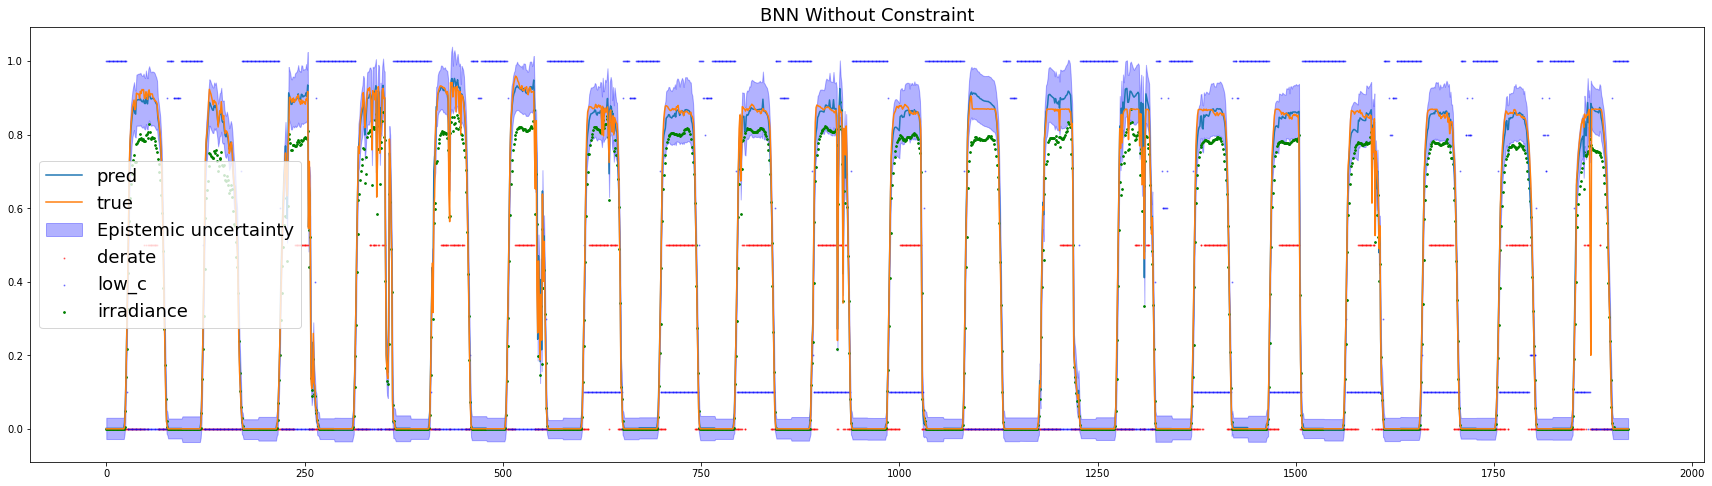

In [32]:
test_wo=test_result_wo.mean(1)
plt.figure(figsize=(30, 8))
visualization_period_1=50
visualization_period_2=70
epistemic_wo = (test_result_wo.var(axis = 1)**0.5).cpu().detach().numpy()

subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
low_subset=testX[-visualization_period_2*96:-visualization_period_1*96,6].cpu().numpy()

subset=subset.cpu().numpy()
aaa=np.where(subset>0.01)[0]/96
derate_plot=np.where(subset>0.01,0.5,0)
derate_plot
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

pred=test_wo.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
plt.title('BNN Without Constraint',fontsize=18)
plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
length=len(pred[-visualization_period_2*96:-visualization_period_1*96])


plt.fill_between( np.linspace(0, length-1, length),((pred - 3*epistemic_wo)[-visualization_period_2*96:-visualization_period_1*96]),((pred + 3*epistemic_wo)[-visualization_period_2*96:-visualization_period_1*96]), alpha = 0.3, color='blue',label = 'Epistemic uncertainty')
plt.scatter(np.array(np.arange(len(derate_plot))),derate_plot,s=1,c='red',alpha=0.5,label='derate')
plt.scatter(np.array(np.arange(len(derate_plot))),low_subset,s=1,c='b',alpha=0.4,label='low_c')

plt.scatter(np.array(np.arange(len(derate_plot))),subset_irra,s=3,c='green',label='irradiance')
plt.legend(fontsize=18)

In [29]:
epistemic_wo.mean()

0.015630528

## Validation set without constraint



In [12]:
# trainX[5360:5399]  #curtail_utility*,curtail_on*,   WS*,ipoa2(-2)*,IGBT_derate_A*,IGBT_off_A*,IGBT_low*,watts*,Feeder_indicater,time_label, day_label

# generate constraint data

In [33]:
from torch.utils.data import DataLoader, TensorDataset
import copy

output_1_index=np.where(traj_train[:,0]>0.2)[0]
output_1=traj_train[:,1:][output_1_index][:9058]
output_2=copy.deepcopy(output_1)
output_3=copy.deepcopy(output_1)
output_2[:,6]=0
derate_1=copy.deepcopy(output_2)
derate_1[:,4]=np.random.randint(1,4)/9
derate_0=copy.deepcopy(output_2)
derate_0[:,4]=0
off_1=copy.deepcopy(output_2)
off_1[:,5]=derate_1[:,4]
off_0=copy.deepcopy(output_2)
off_0[:,5]=0
output_3[:,(4,5)]=0
low_1=copy.deepcopy(output_3)
low_1[:,6]=np.random.randint(1,5)/9
low_0=copy.deepcopy(output_3)
low_0[:,6]=0
con_batchsize=14


def numpy_to_loader(array0,array1,batchsize):
    tensor0=torch.from_numpy(array0).type(torch.Tensor).to(device)
    tensor1=torch.from_numpy(array0).type(torch.Tensor).to(device)
    data_loader=DataLoader(TensorDataset(tensor0, tensor1), batch_size=batchsize, shuffle=True)   #The batch size is designed to match # of batches in trainloader
    return data_loader

derate_loader= numpy_to_loader(derate_0,derate_1,con_batchsize)
off_loader   = numpy_to_loader(off_0,off_1,con_batchsize)
low_loader   = numpy_to_loader(low_0,low_1,con_batchsize)


In [164]:
output_3.shape

(9058, 11)

# train the model with derate constraint only



In [46]:
# net.load_state_dict(torch.load('./know_results/revision/summer_without1.pth'))

from itertools import cycle

net = BayesianNet().to(device)
loss_func = torch.nn.MSELoss()  
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=True)
# train the network
s1=1
s2=1
s3=1
rho1=1
rho2=1
rho3=1
for t in range(400):
    all_loss=0
    train_loss=0
    train_complexity_loss=0
    derate_loss=0
    low_loss=0
    if t<40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
    if t>=40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    if t>=90:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

   
    fit_loss_total = 0
    KL_loss_total=0
    c1 = 0
    c2 = 0
    c3 = 0
    c1_loss_sum = 0
    c2_loss_sum = 0
    c3_loss_sum = 0
    for i, ((x, y),(d0,d1),(f0,f1),(l0,l1)) in enumerate(zip(trainloader,derate_loader,off_loader,low_loader)):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        fit_loss_total  += loss
        complexity_loss = kl_loss(net)
        optimizer.zero_grad()
        
        #Constraint predictions
        derate0_output = net(d0)
        derate1_output = net(d1)
        off0_output = net(f0)
        off1_output = net(f1)
#         low0_output = net(l0)
#         low1_output = net(l1)

        #constraint loss matrix:
        d = derate1_output-derate0_output
        d[d<0] = 1e-6   #<0   +/-
        con_derate = torch.mean(d)
        
        f = off1_output-off0_output
        f[f<0] = 1e-6
        con_off = torch.mean(f)
        
#         l = low1_output-low0_output
#         l[l<-0.01] = 1e-6
#         con_low = torch.mean(l)


        c1_mean = -1*con_derate
        c2_mean = -1*con_off
#         c3_mean = -1*con_low

        c1 += c1_mean
        c2 += c2_mean
#         c3 += c3_mean

        c1_loss = -0.5*s1**2/(rho1+1e-8)+0.5*rho1*((c1_mean-s1/rho1)**2)*(rho1*c1_mean<=s1)
        c2_loss = -0.5*s2**2/(rho2+1e-8)+0.5*rho2*((c2_mean-s2/rho2)**2)*(rho2*c2_mean<=s2)
#         c3_loss = -0.5*s3**2/(rho3+1e-8)+0.5*rho3*((c3_mean-s3/rho3)**2)*(rho3*c3_mean<=s3)
        c1_loss_sum +=c1_loss
        c2_loss_sum +=c2_loss
#         c3_loss_sum +=c3_loss
        total_loss =50*(loss+0.009*complexity_loss) +c1_loss +c2_loss
        
#         print(complexity_loss,loss)

        total_loss.backward()
        optimizer.step()
        all_loss += total_loss
        train_complexity_loss += complexity_loss
        derate_loss += con_derate
    train_loss_avg = fit_loss_total/len(trainloader)
    train_complexity_loss_avg=train_complexity_loss/len(trainloader)
    all_loss_avg=all_loss/len(trainloader)
    
    c1_avg = c1/len(trainloader)
    c2_avg = c2/len(trainloader)
#     c3_avg = c3/len(trainloader)
    
    c1_loss_avg = c1_loss_sum/len(trainloader)
    c2_loss_avg = c2_loss_sum/len(trainloader)
#     c3_loss_avg = c3_loss_sum/len(trainloader)
    
    s1 = torch.max(torch.tensor(0.),s1-rho1*torch.tensor(c1_avg.detach().clone()))     
    s2 = torch.max(torch.tensor(0.),s2-rho2*torch.tensor(c2_avg.detach().clone()))
#     s3 = torch.max(torch.tensor(0.),s3-rho3*torch.tensor(c3_avg.detach().clone()))
    if (t+1)%1==0:
        print('epoch:',t+1, 'c1:',c1_avg.item(),'c2:',c2_avg.item(),'s1:',s1.item(),'s2:',s2.item(),'fit:',train_loss_avg.item(),'complexity:',train_complexity_loss_avg.item(),'total:',train_loss_avg.item(),c1_loss_avg,c2_loss_avg)
    if (t+1)%20==0:
        test_loss=0
        test_results_w=torch.zeros_like(testY)
        for i, (data, target) in enumerate(testloader):
            output_test = net(data)
            loss = loss_func(output_test, target)
            test_loss += loss.item()*data.size(0)
        test_loss_avg = test_loss/len(testloader.sampler)
        print('test loss:',test_loss_avg)  

    if c1_avg>-1*1e-4 and c2_avg >-1*1e-4:
        break


/tmp/ipykernel_4141088/285331251.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s1 = torch.max(torch.tensor(0.),s1-rho1*torch.tensor(c1_avg.detach().clone()))
/tmp/ipykernel_4141088/285331251.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s2 = torch.max(torch.tensor(0.),s2-rho2*torch.tensor(c2_avg.detach().clone()))


epoch: 1 c1: -0.015751348808407784 c2: -0.01546790823340416 s1: 1.0157513618469238 s2: 1.015467882156372 fit: 0.06462384760379791 complexity: 0.03302811458706856 total: 0.06462384760379791 tensor(0.0161, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 2 c1: -0.020904581993818283 c2: -0.02106201834976673 s1: 1.0366559028625488 s2: 1.0365298986434937 fit: 0.009008131921291351 complexity: 0.0014045771677047014 total: 0.009008131921291351 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 3 c1: -0.02086676098406315 c2: -0.02283424884080887 s1: 1.0575226545333862 s2: 1.0593641996383667 fit: 0.005844493862241507 complexity: 0.0018683343660086393 total: 0.005844493862241507 tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 4 c1: -0.021658122539520264 c2: -0.02141169086098671 s1: 1.0791807174682617 s2: 1.0807758569717407 fit: 0.004623807966709137 complexity: 0.0014117165701463819 total: 0.004623807966709137 tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0234, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 5 c1: -0.020886888727545738 c2: -0.022168906405568123 s1: 1.1000676155090332 s2: 1.1029447317123413 fit: 0.004154680762439966 complexity: 0.001823748811148107 total: 0.004154680762439966 tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 6 c1: -0.019831443205475807 c2: -0.020518386736512184 s1: 1.119899034500122 s2: 1.1234631538391113 fit: 0.0036856194492429495 complexity: 0.0014494435163214803 total: 0.0036856194492429495 tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0232, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 7 c1: -0.0179782472550869 c2: -0.019500240683555603 s1: 1.1378772258758545 s2: 1.1429634094238281 fit: 0.0034455142449587584 complexity: 0.001396399806253612 total: 0.0034455142449587584 tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0225, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 8 c1: -0.018778275698423386 c2: -0.01908019743859768 s1: 1.1566555500030518 s2: 1.162043571472168 fit: 0.0032025945838540792 complexity: 0.0011022069957107306 total: 0.0032025945838540792 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 9 c1: -0.018730927258729935 c2: -0.01750210113823414 s1: 1.1753864288330078 s2: 1.1795456409454346 fit: 0.003029251703992486 complexity: 0.0012705891858786345 total: 0.003029251703992486 tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0208, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 10 c1: -0.016920220106840134 c2: -0.019527511671185493 s1: 1.192306637763977 s2: 1.1990731954574585 fit: 0.0028892499394714832 complexity: 0.0011122797150164843 total: 0.0028892499394714832 tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 11 c1: -0.01855563558638096 c2: -0.016842123121023178 s1: 1.2108622789382935 s2: 1.215915322303772 fit: 0.0027556419372558594 complexity: 0.0009128652745857835 total: 0.0027556419372558594 tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 12 c1: -0.017186332494020462 c2: -0.017054483294487 s1: 1.22804856300354 s2: 1.2329697608947754 fit: 0.0029151076450943947 complexity: 0.0012095342390239239 total: 0.0029151076450943947 tensor(0.0212, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0212, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 13 c1: -0.018072497099637985 c2: -0.019893160089850426 s1: 1.2461210489273071 s2: 1.2528629302978516 fit: 0.0027022361755371094 complexity: 0.0011292430572211742 total: 0.0027022361755371094 tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 14 c1: -0.015939923003315926 c2: -0.017984261736273766 s1: 1.2620609998703003 s2: 1.270847201347351 fit: 0.0025781455915421247 complexity: 0.0010022677015513182 total: 0.0025781455915421247 tensor(0.0202, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0230, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 15 c1: -0.01562635228037834 c2: -0.016640733927488327 s1: 1.2776873111724854 s2: 1.2874879837036133 fit: 0.002473057946190238 complexity: 0.0009382693679071963 total: 0.002473057946190238 tensor(0.0201, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 16 c1: -0.01607590541243553 c2: -0.017725395038723946 s1: 1.2937631607055664 s2: 1.3052133321762085 fit: 0.002383327344432473 complexity: 0.0009724876144900918 total: 0.002383327344432473 tensor(0.0209, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 17 c1: -0.016015000641345978 c2: -0.018093790858983994 s1: 1.3097782135009766 s2: 1.3233071565628052 fit: 0.0025189777370542288 complexity: 0.0010938821360468864 total: 0.0025189777370542288 tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 18 c1: -0.0168781578540802 c2: -0.01643041893839836 s1: 1.3266563415527344 s2: 1.3397375345230103 fit: 0.002395059447735548 complexity: 0.0008853448671288788 total: 0.002395059447735548 tensor(0.0225, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 19 c1: -0.01753806509077549 c2: -0.015411251224577427 s1: 1.3441944122314453 s2: 1.3551487922668457 fit: 0.0023890479933470488 complexity: 0.0010323321912437677 total: 0.0023890479933470488 tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 20 c1: -0.014245843514800072 c2: -0.016025198623538017 s1: 1.3584402799606323 s2: 1.3711739778518677 fit: 0.0023443123791366816 complexity: 0.0010033374419435859 total: 0.0023443123791366816 tensor(0.0194, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0016058352630352601


epoch: 21 c1: -0.015817835927009583 c2: -0.01621144264936447 s1: 1.3742581605911255 s2: 1.387385368347168 fit: 0.0023054128978401423 complexity: 0.0009883925085887313 total: 0.0023054128978401423 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 22 c1: -0.015915196388959885 c2: -0.016037289053201675 s1: 1.390173316001892 s2: 1.4034227132797241 fit: 0.002272905083373189 complexity: 0.0010466704843565822 total: 0.002272905083373189 tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 23 c1: -0.014893964864313602 c2: -0.015432818792760372 s1: 1.4050673246383667 s2: 1.4188555479049683 fit: 0.0023217846173793077 complexity: 0.0008997364202514291 total: 0.0023217846173793077 tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 24 c1: -0.014407956041395664 c2: -0.01577496901154518 s1: 1.4194753170013428 s2: 1.4346305131912231 fit: 0.0022061667405068874 complexity: 0.0010739292483776808 total: 0.0022061667405068874 tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0227, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 25 c1: -0.014761649072170258 c2: -0.014508060179650784 s1: 1.434237003326416 s2: 1.4491385221481323 fit: 0.0022246523294597864 complexity: 0.0009645792888477445 total: 0.0022246523294597864 tensor(0.0213, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 26 c1: -0.014939991757273674 c2: -0.015314839780330658 s1: 1.4491770267486572 s2: 1.4644533395767212 fit: 0.002311011776328087 complexity: 0.0009250204893760383 total: 0.002311011776328087 tensor(0.0218, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0225, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 27 c1: -0.013746836222708225 c2: -0.014851990155875683 s1: 1.4629238843917847 s2: 1.479305386543274 fit: 0.00213387468829751 complexity: 0.0008426280692219734 total: 0.00213387468829751 tensor(0.0202, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 28 c1: -0.013993358239531517 c2: -0.014263192191720009 s1: 1.4769172668457031 s2: 1.4935685396194458 fit: 0.002198157599195838 complexity: 0.0010540138464421034 total: 0.002198157599195838 tensor(0.0208, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 29 c1: -0.01477365754544735 c2: -0.01426796242594719 s1: 1.4916908740997314 s2: 1.5078364610671997 fit: 0.0021499732974916697 complexity: 0.0010026933159679174 total: 0.0021499732974916697 tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 30 c1: -0.014509044587612152 c2: -0.015397937037050724 s1: 1.5061999559402466 s2: 1.5232343673706055 fit: 0.0021286080591380596 complexity: 0.001173129421658814 total: 0.0021286080591380596 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 31 c1: -0.013196887448430061 c2: -0.013596024364233017 s1: 1.5193969011306763 s2: 1.5368304252624512 fit: 0.002077639801427722 complexity: 0.0009224466048181057 total: 0.002077639801427722 tensor(0.0201, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 32 c1: -0.015481183305382729 c2: -0.014728706330060959 s1: 1.534878134727478 s2: 1.5515590906143188 fit: 0.0020262098405510187 complexity: 0.0008968752808868885 total: 0.0020262098405510187 tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 33 c1: -0.013754957355558872 c2: -0.012778667733073235 s1: 1.548633098602295 s2: 1.5643377304077148 fit: 0.0021252776496112347 complexity: 0.0010653865756466985 total: 0.0021252776496112347 tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0201, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 34 c1: -0.013501082547008991 c2: -0.013547472655773163 s1: 1.5621341466903687 s2: 1.5778851509094238 fit: 0.0020141946151852608 complexity: 0.0009892756352201104 total: 0.0020141946151852608 tensor(0.0212, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 35 c1: -0.013898688368499279 c2: -0.015278647653758526 s1: 1.5760328769683838 s2: 1.5931638479232788 fit: 0.0019685234874486923 complexity: 0.0009120311588048935 total: 0.0019685234874486923 tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0244, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 36 c1: -0.013523437082767487 c2: -0.015248021110892296 s1: 1.589556336402893 s2: 1.6084119081497192 fit: 0.0020279292948544025 complexity: 0.0011556098470464349 total: 0.0020279292948544025 tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 37 c1: -0.013851900584995747 c2: -0.013472952879965305 s1: 1.6034082174301147 s2: 1.621884822845459 fit: 0.00196406664326787 complexity: 0.0010406413348391652 total: 0.00196406664326787 tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 38 c1: -0.013388707302510738 c2: -0.013679585419595242 s1: 1.6167969703674316 s2: 1.6355644464492798 fit: 0.002014649799093604 complexity: 0.0008117720135487616 total: 0.002014649799093604 tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 39 c1: -0.011619369499385357 c2: -0.013121669180691242 s1: 1.6284162998199463 s2: 1.648686170578003 fit: 0.0019622831605374813 complexity: 0.0011134688975289464 total: 0.0019622831605374813 tensor(0.0190, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 40 c1: -0.012193969450891018 c2: -0.012865542434155941 s1: 1.6406102180480957 s2: 1.6615517139434814 fit: 0.0019313335651531816 complexity: 0.0010508180130273104 total: 0.0019313335651531816 tensor(0.0201, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0012873243870935806


epoch: 41 c1: -0.013078894466161728 c2: -0.01500259805470705 s1: 1.6536891460418701 s2: 1.6765543222427368 fit: 0.0019088115077465773 complexity: 0.000716852955520153 total: 0.0019088115077465773 tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 42 c1: -0.013238150626420975 c2: -0.012959720566868782 s1: 1.6669273376464844 s2: 1.6895140409469604 fit: 0.0019160842057317495 complexity: 0.000889020855538547 total: 0.0019160842057317495 tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 43 c1: -0.012079560197889805 c2: -0.013016896322369576 s1: 1.6790069341659546 s2: 1.7025309801101685 fit: 0.0018873828230425715 complexity: 0.0007706107571721077 total: 0.0018873828230425715 tensor(0.0204, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 44 c1: -0.013612810522317886 c2: -0.012956926599144936 s1: 1.692619800567627 s2: 1.7154879570007324 fit: 0.0018515114206820726 complexity: 0.0007477868348360062 total: 0.0018515114206820726 tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 45 c1: -0.011897491291165352 c2: -0.01327649224549532 s1: 1.7045172452926636 s2: 1.7287644147872925 fit: 0.0018147401278838515 complexity: 0.0006693829782307148 total: 0.0018147401278838515 tensor(0.0204, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0230, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 46 c1: -0.011976225301623344 c2: -0.011831898242235184 s1: 1.7164934873580933 s2: 1.7405962944030762 fit: 0.001817225245758891 complexity: 0.0006875368999317288 total: 0.001817225245758891 tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0207, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 47 c1: -0.012391136027872562 c2: -0.011794223450124264 s1: 1.7288845777511597 s2: 1.7523905038833618 fit: 0.0019254261860623956 complexity: 0.0008351518772542477 total: 0.0019254261860623956 tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0207, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 48 c1: -0.013334005139768124 c2: -0.013389583677053452 s1: 1.7422186136245728 s2: 1.7657800912857056 fit: 0.0018540314631536603 complexity: 0.0009150708210654557 total: 0.0018540314631536603 tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 49 c1: -0.012581459246575832 c2: -0.013060198165476322 s1: 1.7548000812530518 s2: 1.7788403034210205 fit: 0.001876756432466209 complexity: 0.0009625173988752067 total: 0.001876756432466209 tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 50 c1: -0.01305343210697174 c2: -0.012749025598168373 s1: 1.7678534984588623 s2: 1.791589379310608 fit: 0.0018076003761962056 complexity: 0.0007354250992648304 total: 0.0018076003761962056 tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 51 c1: -0.012810870073735714 c2: -0.012654494494199753 s1: 1.780664324760437 s2: 1.8042439222335815 fit: 0.0018686376279219985 complexity: 0.0007428264943882823 total: 0.0018686376279219985 tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 52 c1: -0.013055820018053055 c2: -0.01291497889906168 s1: 1.7937201261520386 s2: 1.8171589374542236 fit: 0.0018868878250941634 complexity: 0.0008051441400311887 total: 0.0018868878250941634 tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 53 c1: -0.010970572009682655 c2: -0.01301794033497572 s1: 1.8046907186508179 s2: 1.830176830291748 fit: 0.0019220896065235138 complexity: 0.0008620911394245923 total: 0.0019220896065235138 tensor(0.0199, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 54 c1: -0.011821107938885689 c2: -0.012984223663806915 s1: 1.816511869430542 s2: 1.8431611061096191 fit: 0.0018131205579265952 complexity: 0.0007293249946087599 total: 0.0018131205579265952 tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 55 c1: -0.012202276848256588 c2: -0.01237579993903637 s1: 1.82871413230896 s2: 1.855536937713623 fit: 0.0018856078386306763 complexity: 0.0008028285810723901 total: 0.0018856078386306763 tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0230, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 56 c1: -0.01295255497097969 c2: -0.01277490146458149 s1: 1.8416666984558105 s2: 1.868311882019043 fit: 0.0019193304469808936 complexity: 0.0007958524511195719 total: 0.0019193304469808936 tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 57 c1: -0.012487237341701984 c2: -0.011217874474823475 s1: 1.8541539907455444 s2: 1.8795297145843506 fit: 0.0018752817995846272 complexity: 0.000743813521694392 total: 0.0018752817995846272 tensor(0.0232, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 58 c1: -0.013656001538038254 c2: -0.012676393613219261 s1: 1.8678100109100342 s2: 1.892206072807312 fit: 0.001904624979943037 complexity: 0.000891010626219213 total: 0.001904624979943037 tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 59 c1: -0.012154747731983662 c2: -0.011588298715651035 s1: 1.8799647092819214 s2: 1.9037944078445435 fit: 0.0018495777621865273 complexity: 0.0008754135924391448 total: 0.0018495777621865273 tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 60 c1: -0.011536265723407269 c2: -0.0123623451218009 s1: 1.8915009498596191 s2: 1.9161567687988281 fit: 0.0018653996521607041 complexity: 0.0008826064877212048 total: 0.0018653996521607041 tensor(0.0219, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.001362251575202913


epoch: 61 c1: -0.012997263111174107 c2: -0.01228963304311037 s1: 1.9044982194900513 s2: 1.9284464120864868 fit: 0.0018751337192952633 complexity: 0.0008766477694734931 total: 0.0018751337192952633 tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 62 c1: -0.011830846779048443 c2: -0.011484668590128422 s1: 1.916329026222229 s2: 1.939931035041809 fit: 0.0017798511544242501 complexity: 0.0007800335879437625 total: 0.0017798511544242501 tensor(0.0227, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 63 c1: -0.01159162912517786 c2: -0.013901574537158012 s1: 1.9279206991195679 s2: 1.9538326263427734 fit: 0.0017842462984845042 complexity: 0.0008018221124075353 total: 0.0017842462984845042 tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 64 c1: -0.0112987095490098 c2: -0.01197035051882267 s1: 1.939219355583191 s2: 1.9658030271530151 fit: 0.0018238801276311278 complexity: 0.0007949888822622597 total: 0.0018238801276311278 tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 65 c1: -0.011658290401101112 c2: -0.011857390403747559 s1: 1.9508776664733887 s2: 1.9776604175567627 fit: 0.0018658987246453762 complexity: 0.0008748032269068062 total: 0.0018658987246453762 tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 66 c1: -0.012176009826362133 c2: -0.011759273707866669 s1: 1.9630537033081055 s2: 1.98941969871521 fit: 0.0017775583546608686 complexity: 0.0008445400162599981 total: 0.0017775583546608686 tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 67 c1: -0.012383945286273956 c2: -0.011898402124643326 s1: 1.9754376411437988 s2: 2.0013182163238525 fit: 0.0018186921952292323 complexity: 0.0008477806113660336 total: 0.0018186921952292323 tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 68 c1: -0.011882147751748562 c2: -0.01138326246291399 s1: 1.987319827079773 s2: 2.0127015113830566 fit: 0.0017544477013871074 complexity: 0.0008218626026064157 total: 0.0017544477013871074 tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0230, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 69 c1: -0.011002844199538231 c2: -0.011588303372263908 s1: 1.9983227252960205 s2: 2.024289846420288 fit: 0.0018100233282893896 complexity: 0.0008467314764857292 total: 0.0018100233282893896 tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 70 c1: -0.0109896594658494 c2: -0.012852770276367664 s1: 2.009312391281128 s2: 2.037142515182495 fit: 0.0018101281020790339 complexity: 0.0009209457202814519 total: 0.0018101281020790339 tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 71 c1: -0.010990605689585209 c2: -0.012083420529961586 s1: 2.0203030109405518 s2: 2.0492260456085205 fit: 0.0017667178763076663 complexity: 0.0008476402144879103 total: 0.0017667178763076663 tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 72 c1: -0.011848801746964455 c2: -0.011776071973145008 s1: 2.032151699066162 s2: 2.061002016067505 fit: 0.0018060413422062993 complexity: 0.0008712661219760776 total: 0.0018060413422062993 tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0243, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 73 c1: -0.011785848066210747 c2: -0.011399869807064533 s1: 2.0439374446868896 s2: 2.072402000427246 fit: 0.0017514325445517898 complexity: 0.000819229637272656 total: 0.0017514325445517898 tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 74 c1: -0.01123537216335535 c2: -0.01174138579517603 s1: 2.055172920227051 s2: 2.0841434001922607 fit: 0.0017471484607085586 complexity: 0.0008200067095458508 total: 0.0017471484607085586 tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 75 c1: -0.011572841554880142 c2: -0.012105352245271206 s1: 2.0667457580566406 s2: 2.0962488651275635 fit: 0.001779674319550395 complexity: 0.0008366359397768974 total: 0.001779674319550395 tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 76 c1: -0.01181827113032341 c2: -0.011910224333405495 s1: 2.078563928604126 s2: 2.108159065246582 fit: 0.0017029901500791311 complexity: 0.0009309175657108426 total: 0.0017029901500791311 tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 77 c1: -0.011140082031488419 c2: -0.010559050366282463 s1: 2.0897040367126465 s2: 2.118718147277832 fit: 0.0017981956480070949 complexity: 0.000904810440260917 total: 0.0017981956480070949 tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 78 c1: -0.011308840475976467 c2: -0.012361979112029076 s1: 2.101012945175171 s2: 2.131080150604248 fit: 0.001725840033032 complexity: 0.0008700318285264075 total: 0.001725840033032 tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 79 c1: -0.010466561652719975 c2: -0.011529318988323212 s1: 2.1114795207977295 s2: 2.1426093578338623 fit: 0.0017016292549669743 complexity: 0.0007534620235674083 total: 0.0017016292549669743 tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 80 c1: -0.01084254402667284 c2: -0.011367138475179672 s1: 2.1223220825195312 s2: 2.1539764404296875 fit: 0.0017890045419335365 complexity: 0.0009334707865491509 total: 0.0017890045419335365 tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.001283890077175504


epoch: 81 c1: -0.01105534192174673 c2: -0.011350441724061966 s1: 2.1333773136138916 s2: 2.1653268337249756 fit: 0.0017345347441732883 complexity: 0.0009217081242240965 total: 0.0017345347441732883 tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 82 c1: -0.011492236517369747 c2: -0.012256370857357979 s1: 2.144869565963745 s2: 2.1775832176208496 fit: 0.001824849285185337 complexity: 0.0009140768088400364 total: 0.001824849285185337 tensor(0.0247, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 83 c1: -0.010775760747492313 c2: -0.010730672627687454 s1: 2.1556453704833984 s2: 2.1883139610290527 fit: 0.0016800975427031517 complexity: 0.000875936180818826 total: 0.0016800975427031517 tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 84 c1: -0.010778236202895641 c2: -0.010571751743555069 s1: 2.1664235591888428 s2: 2.198885679244995 fit: 0.001766603090800345 complexity: 0.0008962494903244078 total: 0.001766603090800345 tensor(0.0234, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 85 c1: -0.010232925415039062 c2: -0.01088742446154356 s1: 2.176656484603882 s2: 2.209773063659668 fit: 0.0017330592963844538 complexity: 0.0009531432879157364 total: 0.0017330592963844538 tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 86 c1: -0.011107317171990871 c2: -0.011212283745408058 s1: 2.1877636909484863 s2: 2.2209854125976562 fit: 0.001786325592547655 complexity: 0.0010412860428914428 total: 0.001786325592547655 tensor(0.0243, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 87 c1: -0.011553855612874031 c2: -0.011736005544662476 s1: 2.199317455291748 s2: 2.2327213287353516 fit: 0.0017653758404776454 complexity: 0.0010384233901277184 total: 0.0017653758404776454 tensor(0.0255, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0263, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 88 c1: -0.010588024742901325 c2: -0.0106991957873106 s1: 2.2099053859710693 s2: 2.2434206008911133 fit: 0.0017088319873437285 complexity: 0.0008905566646717489 total: 0.0017088319873437285 tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 89 c1: -0.010269478894770145 c2: -0.012179603800177574 s1: 2.220174789428711 s2: 2.2556002140045166 fit: 0.0016960161738097668 complexity: 0.0008969574701040983 total: 0.0016960161738097668 tensor(0.0229, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0275, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 90 c1: -0.011243198998272419 c2: -0.011441103182733059 s1: 2.2314178943634033 s2: 2.2670412063598633 fit: 0.0017400177894160151 complexity: 0.0008902826812118292 total: 0.0017400177894160151 tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0260, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 91 c1: -0.01054406724870205 c2: -0.010217932984232903 s1: 2.24196195602417 s2: 2.277259111404419 fit: 0.0017872130265459418 complexity: 0.0008484682184644043 total: 0.0017872130265459418 tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 92 c1: -0.01043845433741808 c2: -0.011425907723605633 s1: 2.2524003982543945 s2: 2.2886850833892822 fit: 0.001746510504744947 complexity: 0.0007722143782302737 total: 0.001746510504744947 tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 93 c1: -0.010529723949730396 c2: -0.010608715936541557 s1: 2.262930154800415 s2: 2.2992937564849854 fit: 0.0017567096510902047 complexity: 0.0007426275406032801 total: 0.0017567096510902047 tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0244, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 94 c1: -0.009999686852097511 c2: -0.011574240401387215 s1: 2.2729299068450928 s2: 2.31086802482605 fit: 0.001725698821246624 complexity: 0.000815722974948585 total: 0.001725698821246624 tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 95 c1: -0.010750222019851208 c2: -0.010188283398747444 s1: 2.2836802005767822 s2: 2.321056365966797 fit: 0.0017657583812251687 complexity: 0.0008464233251288533 total: 0.0017657583812251687 tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 96 c1: -0.010178675875067711 c2: -0.010212029330432415 s1: 2.293858766555786 s2: 2.331268310546875 fit: 0.0017156567191705108 complexity: 0.0008046397124417126 total: 0.0017156567191705108 tensor(0.0234, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 97 c1: -0.01106211356818676 c2: -0.010715973563492298 s1: 2.3049209117889404 s2: 2.341984272003174 fit: 0.001766486675478518 complexity: 0.0008481661207042634 total: 0.001766486675478518 tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 98 c1: -0.009998674504458904 c2: -0.01145178359001875 s1: 2.3149194717407227 s2: 2.35343599319458 fit: 0.0017606955952942371 complexity: 0.0008308536489494145 total: 0.0017606955952942371 tensor(0.0232, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 99 c1: -0.010561466217041016 c2: -0.010380694642663002 s1: 2.3254809379577637 s2: 2.363816738128662 fit: 0.001773911528289318 complexity: 0.0008784685051068664 total: 0.001773911528289318 tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 100 c1: -0.010800602845847607 c2: -0.010006505064666271 s1: 2.3362815380096436 s2: 2.3738231658935547 fit: 0.001695767161436379 complexity: 0.0008151687798090279 total: 0.001695767161436379 tensor(0.0253, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0238, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0012179194644181832


epoch: 101 c1: -0.010617047548294067 c2: -0.010293505154550076 s1: 2.3468985557556152 s2: 2.3841166496276855 fit: 0.0017822361551225185 complexity: 0.0008134872769005597 total: 0.0017822361551225185 tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 102 c1: -0.011641230434179306 c2: -0.011281246319413185 s1: 2.3585398197174072 s2: 2.395397901535034 fit: 0.0016976346960291266 complexity: 0.0008398228674195707 total: 0.0016976346960291266 tensor(0.0275, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 103 c1: -0.010578306391835213 c2: -0.010804325342178345 s1: 2.3691182136535645 s2: 2.4062023162841797 fit: 0.0017040433594956994 complexity: 0.0008440065430477262 total: 0.0017040433594956994 tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0260, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 104 c1: -0.01071009412407875 c2: -0.010494868271052837 s1: 2.3798282146453857 s2: 2.4166972637176514 fit: 0.0017308283131569624 complexity: 0.0008805153192952275 total: 0.0017308283131569624 tensor(0.0255, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 105 c1: -0.011755876243114471 c2: -0.00985120702534914 s1: 2.3915841579437256 s2: 2.426548480987549 fit: 0.0017246230272576213 complexity: 0.0009155805455520749 total: 0.0017246230272576213 tensor(0.0282, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 106 c1: -0.010904619470238686 c2: -0.011284468695521355 s1: 2.4024887084960938 s2: 2.437832832336426 fit: 0.001684924471192062 complexity: 0.00090696633560583 total: 0.001684924471192062 tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0276, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 107 c1: -0.010703008621931076 c2: -0.010846881195902824 s1: 2.413191795349121 s2: 2.4486796855926514 fit: 0.0017511817859485745 complexity: 0.000916885444894433 total: 0.0017511817859485745 tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 108 c1: -0.010766025632619858 c2: -0.010871070437133312 s1: 2.4239578247070312 s2: 2.4595508575439453 fit: 0.0017241688910871744 complexity: 0.0009514596895314753 total: 0.0017241688910871744 tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 109 c1: -0.010898519307374954 c2: -0.010897698812186718 s1: 2.434856414794922 s2: 2.4704484939575195 fit: 0.00166891363915056 complexity: 0.000986183062195778 total: 0.00166891363915056 tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 110 c1: -0.01058603823184967 c2: -0.010201241821050644 s1: 2.4454424381256104 s2: 2.480649709701538 fit: 0.0017913903575390577 complexity: 0.0010285571916028857 total: 0.0017913903575390577 tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 111 c1: -0.010415946133434772 c2: -0.010142038576304913 s1: 2.4558584690093994 s2: 2.4907917976379395 fit: 0.001699607353657484 complexity: 0.0009925655322149396 total: 0.001699607353657484 tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0253, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 112 c1: -0.010828367434442043 c2: -0.010364262387156487 s1: 2.466686725616455 s2: 2.5011560916900635 fit: 0.0017475842032581568 complexity: 0.001002598786726594 total: 0.0017475842032581568 tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0260, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 113 c1: -0.009820631705224514 c2: -0.011028995737433434 s1: 2.4765074253082275 s2: 2.5121850967407227 fit: 0.0016937246546149254 complexity: 0.0008971660281531513 total: 0.0016937246546149254 tensor(0.0244, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 114 c1: -0.010253210552036762 c2: -0.011072404682636261 s1: 2.4867606163024902 s2: 2.5232574939727783 fit: 0.0017940212273970246 complexity: 0.0008601112058386207 total: 0.0017940212273970246 tensor(0.0255, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 115 c1: -0.011244893074035645 c2: -0.008996033109724522 s1: 2.4980053901672363 s2: 2.5322535037994385 fit: 0.0017239026492461562 complexity: 0.0008977013058029115 total: 0.0017239026492461562 tensor(0.0281, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 116 c1: -0.010313177481293678 c2: -0.010481486096978188 s1: 2.5083186626434326 s2: 2.5427350997924805 fit: 0.0017372367437928915 complexity: 0.0009544308995828032 total: 0.0017372367437928915 tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 117 c1: -0.010764376260340214 c2: -0.010685077868402004 s1: 2.519083023071289 s2: 2.553420066833496 fit: 0.0017482017865404487 complexity: 0.0009910047519952059 total: 0.0017482017865404487 tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 118 c1: -0.010542208328843117 c2: -0.00936091411858797 s1: 2.529625177383423 s2: 2.5627810955047607 fit: 0.0016816339921206236 complexity: 0.0009530530660413206 total: 0.0016816339921206236 tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 119 c1: -0.00952955149114132 c2: -0.010264291428029537 s1: 2.5391547679901123 s2: 2.573045492172241 fit: 0.0017746665980666876 complexity: 0.0010259404079988599 total: 0.0017746665980666876 tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 120 c1: -0.010335337370634079 c2: -0.010024773888289928 s1: 2.549490213394165 s2: 2.5830702781677246 fit: 0.0016991319134831429 complexity: 0.0009898478165268898 total: 0.0016991319134831429 tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0012035082583120385


epoch: 121 c1: -0.011098493821918964 c2: -0.009455515071749687 s1: 2.5605885982513428 s2: 2.5925257205963135 fit: 0.0017229977529495955 complexity: 0.000939340447075665 total: 0.0017229977529495955 tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 122 c1: -0.010978147387504578 c2: -0.010619311593472958 s1: 2.5715668201446533 s2: 2.603145122528076 fit: 0.0016738575650379062 complexity: 0.0008297379245050251 total: 0.0016738575650379062 tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 123 c1: -0.01010699849575758 c2: -0.010846898891031742 s1: 2.5816738605499268 s2: 2.6139919757843018 fit: 0.0017091600457206368 complexity: 0.0009398774127475917 total: 0.0017091600457206368 tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 124 c1: -0.009780067950487137 c2: -0.010257438756525517 s1: 2.591454029083252 s2: 2.6242494583129883 fit: 0.0017044722335413098 complexity: 0.0008965198649093509 total: 0.0017044722335413098 tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 125 c1: -0.010190896689891815 c2: -0.010141470469534397 s1: 2.601644992828369 s2: 2.6343908309936523 fit: 0.0017183450981974602 complexity: 0.0008977889665402472 total: 0.0017183450981974602 tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 126 c1: -0.009890913963317871 c2: -0.010954097844660282 s1: 2.6115360260009766 s2: 2.6453449726104736 fit: 0.0017240813467651606 complexity: 0.0009692345047369599 total: 0.0017240813467651606 tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 127 c1: -0.010061477310955524 c2: -0.010484949685633183 s1: 2.6215975284576416 s2: 2.655829906463623 fit: 0.0017150618368759751 complexity: 0.00094227324007079 total: 0.0017150618368759751 tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0279, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 128 c1: -0.010471997782588005 c2: -0.010231291875243187 s1: 2.6320695877075195 s2: 2.6660611629486084 fit: 0.0017315917648375034 complexity: 0.001062488299794495 total: 0.0017315917648375034 tensor(0.0276, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 129 c1: -0.009857330471277237 c2: -0.010633795522153378 s1: 2.6419270038604736 s2: 2.676694869995117 fit: 0.0016794471303001046 complexity: 0.0009937394643202424 total: 0.0016794471303001046 tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 130 c1: -0.009872402995824814 c2: -0.010896057821810246 s1: 2.651799440383911 s2: 2.6875908374786377 fit: 0.001764765940606594 complexity: 0.0010186441941186786 total: 0.001764765940606594 tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0293, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 131 c1: -0.009517240338027477 c2: -0.009835796430706978 s1: 2.6613166332244873 s2: 2.6974265575408936 fit: 0.0017306844238191843 complexity: 0.0009955032728612423 total: 0.0017306844238191843 tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 132 c1: -0.009915491566061974 c2: -0.010744289495050907 s1: 2.671232223510742 s2: 2.7081708908081055 fit: 0.001683540060184896 complexity: 0.0009882309241220355 total: 0.001683540060184896 tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 133 c1: -0.011028129607439041 c2: -0.011133423075079918 s1: 2.682260274887085 s2: 2.719304323196411 fit: 0.001685506198555231 complexity: 0.0009817327372729778 total: 0.001685506198555231 tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0303, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 134 c1: -0.009973953478038311 c2: -0.009567296132445335 s1: 2.6922342777252197 s2: 2.7288715839385986 fit: 0.0016859258757904172 complexity: 0.0010235770605504513 total: 0.0016859258757904172 tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 135 c1: -0.00994859542697668 c2: -0.011225894093513489 s1: 2.7021827697753906 s2: 2.7400975227355957 fit: 0.0016796549316495657 complexity: 0.0010366149945184588 total: 0.0016796549316495657 tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0308, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 136 c1: -0.009762990288436413 c2: -0.010407508350908756 s1: 2.7119457721710205 s2: 2.750504970550537 fit: 0.0017083613201975822 complexity: 0.0011345921084284782 total: 0.0017083613201975822 tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0287, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 137 c1: -0.01062917523086071 c2: -0.010480262339115143 s1: 2.7225749492645264 s2: 2.7609851360321045 fit: 0.001618106267414987 complexity: 0.0011016594944521785 total: 0.001618106267414987 tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 138 c1: -0.009211956523358822 c2: -0.009818902239203453 s1: 2.7317869663238525 s2: 2.770803928375244 fit: 0.00169465783983469 complexity: 0.0010682762367650867 total: 0.00169465783983469 tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 139 c1: -0.009845652617514133 c2: -0.009224705398082733 s1: 2.7416326999664307 s2: 2.7800285816192627 fit: 0.0016685229493305087 complexity: 0.0009845381136983633 total: 0.0016685229493305087 tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 140 c1: -0.010117736645042896 c2: -0.009738209657371044 s1: 2.7517504692077637 s2: 2.789766788482666 fit: 0.0017519425600767136 complexity: 0.0010175937786698341 total: 0.0017519425600767136 tensor(0.0279, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0011869701491661261


epoch: 141 c1: -0.009466465562582016 c2: -0.010160165838897228 s1: 2.761216878890991 s2: 2.799926996231079 fit: 0.0016565753612667322 complexity: 0.0010608682641759515 total: 0.0016565753612667322 tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 142 c1: -0.009551053866744041 c2: -0.010065542533993721 s1: 2.7707679271698 s2: 2.809992551803589 fit: 0.0017252712277695537 complexity: 0.0010722086299210787 total: 0.0017252712277695537 tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 143 c1: -0.010025020688772202 c2: -0.009643705561757088 s1: 2.7807929515838623 s2: 2.819636344909668 fit: 0.001685990602709353 complexity: 0.001098712906241417 total: 0.001685990602709353 tensor(0.0279, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 144 c1: -0.009607123211026192 c2: -0.010675794444978237 s1: 2.7904000282287598 s2: 2.8303122520446777 fit: 0.00163841072935611 complexity: 0.0010178596712648869 total: 0.00163841072935611 tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0302, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 145 c1: -0.010094075463712215 c2: -0.0105880843475461 s1: 2.8004941940307617 s2: 2.840900421142578 fit: 0.0016613168409094214 complexity: 0.0010524288518354297 total: 0.0016613168409094214 tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 146 c1: -0.00969117321074009 c2: -0.01046136673539877 s1: 2.810185432434082 s2: 2.8513617515563965 fit: 0.0016574582550674677 complexity: 0.001016653492115438 total: 0.0016574582550674677 tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 147 c1: -0.01031921524554491 c2: -0.00927656888961792 s1: 2.820504665374756 s2: 2.860638380050659 fit: 0.00169067969545722 complexity: 0.0010186157887801528 total: 0.00169067969545722 tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 148 c1: -0.010178172960877419 c2: -0.010671853087842464 s1: 2.8306827545166016 s2: 2.871310234069824 fit: 0.0016447060042992234 complexity: 0.0010767945786938071 total: 0.0016447060042992234 tensor(0.0288, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 149 c1: -0.010582366958260536 c2: -0.01084901299327612 s1: 2.8412652015686035 s2: 2.8821592330932617 fit: 0.0017028528964146972 complexity: 0.0011142746079713106 total: 0.0017028528964146972 tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 150 c1: -0.009013553149998188 c2: -0.010553278028964996 s1: 2.850278854370117 s2: 2.8927125930786133 fit: 0.001675396808423102 complexity: 0.0010872699785977602 total: 0.001675396808423102 tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 151 c1: -0.008822601288557053 c2: -0.010575516149401665 s1: 2.8591015338897705 s2: 2.9032881259918213 fit: 0.0016220135148614645 complexity: 0.00112681754399091 total: 0.0016220135148614645 tensor(0.0253, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 152 c1: -0.008947252295911312 c2: -0.010021636262536049 s1: 2.868048667907715 s2: 2.9133098125457764 fit: 0.0016732992371544242 complexity: 0.0010824339697137475 total: 0.0016732992371544242 tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0292, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 153 c1: -0.01074637658894062 c2: -0.010763083584606647 s1: 2.8787951469421387 s2: 2.9240729808807373 fit: 0.0016425285721197724 complexity: 0.001142816967330873 total: 0.0016425285721197724 tensor(0.0310, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 154 c1: -0.009267538785934448 c2: -0.009684186428785324 s1: 2.8880627155303955 s2: 2.9337570667266846 fit: 0.001714264857582748 complexity: 0.0011597463162615895 total: 0.001714264857582748 tensor(0.0268, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 155 c1: -0.009558401070535183 c2: -0.009809081442654133 s1: 2.8976211547851562 s2: 2.943566083908081 fit: 0.0016520844073966146 complexity: 0.001138934982009232 total: 0.0016520844073966146 tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0289, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 156 c1: -0.009510465897619724 c2: -0.009247983805835247 s1: 2.9071316719055176 s2: 2.9528141021728516 fit: 0.0016408251831308007 complexity: 0.001119527267292142 total: 0.0016408251831308007 tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 157 c1: -0.010135900229215622 c2: -0.007947757840156555 s1: 2.9172675609588623 s2: 2.960761785507202 fit: 0.0016736246179789305 complexity: 0.0011515059741213918 total: 0.0016736246179789305 tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 158 c1: -0.009624202735722065 c2: -0.009958290494978428 s1: 2.926891803741455 s2: 2.970720052719116 fit: 0.001645647338591516 complexity: 0.0011155882384628057 total: 0.001645647338591516 tensor(0.0282, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 159 c1: -0.008563918061554432 c2: -0.010855717584490776 s1: 2.935455799102783 s2: 2.9815757274627686 fit: 0.0016501013888046145 complexity: 0.0011594494571909308 total: 0.0016501013888046145 tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 160 c1: -0.009836412966251373 c2: -0.008589929901063442 s1: 2.9452922344207764 s2: 2.9901657104492188 fit: 0.0016920011257752776 complexity: 0.0011332817375659943 total: 0.0016920011257752776 tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0011833450990191433


epoch: 161 c1: -0.010301871225237846 c2: -0.009635941125452518 s1: 2.955594062805176 s2: 2.9998016357421875 fit: 0.0016554332105442882 complexity: 0.0012172986753284931 total: 0.0016554332105442882 tensor(0.0305, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 162 c1: -0.010622942820191383 c2: -0.010148899629712105 s1: 2.966217041015625 s2: 3.009950637817383 fit: 0.0016578572103753686 complexity: 0.0012753675691783428 total: 0.0016578572103753686 tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 163 c1: -0.00835754070430994 c2: -0.011185203678905964 s1: 2.974574565887451 s2: 3.0211358070373535 fit: 0.0016917303437367082 complexity: 0.0012408101465553045 total: 0.0016917303437367082 tensor(0.0249, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 164 c1: -0.008852336555719376 c2: -0.00940165389329195 s1: 2.983426809310913 s2: 3.0305373668670654 fit: 0.0016368853393942118 complexity: 0.001273913076147437 total: 0.0016368853393942118 tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 165 c1: -0.0103008346632123 c2: -0.008834009058773518 s1: 2.993727684020996 s2: 3.0393714904785156 fit: 0.0016760688740760088 complexity: 0.0012531746178865433 total: 0.0016760688740760088 tensor(0.0309, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 166 c1: -0.00923314318060875 c2: -0.009847486391663551 s1: 3.0029609203338623 s2: 3.0492188930511475 fit: 0.0016302317380905151 complexity: 0.0012255042092874646 total: 0.0016302317380905151 tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 167 c1: -0.009532293304800987 c2: -0.009491067379713058 s1: 3.012493133544922 s2: 3.0587098598480225 fit: 0.001695556566119194 complexity: 0.0012023916933685541 total: 0.001695556566119194 tensor(0.0288, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 168 c1: -0.009222724474966526 c2: -0.009794846177101135 s1: 3.0217158794403076 s2: 3.068504810333252 fit: 0.0016933854203671217 complexity: 0.0012419185368344188 total: 0.0016933854203671217 tensor(0.0279, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 169 c1: -0.009427324868738651 c2: -0.009017023257911205 s1: 3.0311431884765625 s2: 3.077521800994873 fit: 0.001647603465244174 complexity: 0.0011736061424016953 total: 0.001647603465244174 tensor(0.0286, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 170 c1: -0.00988911185413599 c2: -0.010169589892029762 s1: 3.041032314300537 s2: 3.087691307067871 fit: 0.0016736435936763883 complexity: 0.0012369969626888633 total: 0.0016736435936763883 tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 171 c1: -0.009226442314684391 c2: -0.009966765530407429 s1: 3.0502588748931885 s2: 3.097658157348633 fit: 0.0016136841150000691 complexity: 0.001215617754496634 total: 0.0016136841150000691 tensor(0.0282, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 172 c1: -0.010459461249411106 c2: -0.009852561168372631 s1: 3.060718297958374 s2: 3.107510805130005 fit: 0.0016283560544252396 complexity: 0.001211471506394446 total: 0.0016283560544252396 tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 173 c1: -0.008990594185888767 c2: -0.009819095954298973 s1: 3.069708824157715 s2: 3.1173298358917236 fit: 0.001642002840526402 complexity: 0.0011649172520264983 total: 0.001642002840526402 tensor(0.0276, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 174 c1: -0.01013626717031002 c2: -0.008896107785403728 s1: 3.0798451900482178 s2: 3.1262259483337402 fit: 0.001645730808377266 complexity: 0.0011017379583790898 total: 0.001645730808377266 tensor(0.0313, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 175 c1: -0.009347042068839073 c2: -0.010096237994730473 s1: 3.0891921520233154 s2: 3.136322259902954 fit: 0.0016211350448429585 complexity: 0.001237262156791985 total: 0.0016211350448429585 tensor(0.0289, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 176 c1: -0.00961111206561327 c2: -0.009898577816784382 s1: 3.0988032817840576 s2: 3.1462209224700928 fit: 0.0016418790910393 complexity: 0.0012459629215300083 total: 0.0016418790910393 tensor(0.0298, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 177 c1: -0.009733989834785461 c2: -0.009258128702640533 s1: 3.108537197113037 s2: 3.1554789543151855 fit: 0.0016141219530254602 complexity: 0.0012133328709751368 total: 0.0016141219530254602 tensor(0.0303, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0292, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 178 c1: -0.010112326592206955 c2: -0.009552158415317535 s1: 3.118649482727051 s2: 3.1650311946868896 fit: 0.0016275809612125158 complexity: 0.0012184553779661655 total: 0.0016275809612125158 tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0303, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 179 c1: -0.009539976716041565 c2: -0.00983686838299036 s1: 3.1281895637512207 s2: 3.174868106842041 fit: 0.0016912352293729782 complexity: 0.0012321859830990434 total: 0.0016912352293729782 tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 180 c1: -0.00902471225708723 c2: -0.00982018280774355 s1: 3.137214183807373 s2: 3.1846883296966553 fit: 0.0016477067256346345 complexity: 0.0012817210517823696 total: 0.0016477067256346345 tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0011763483163472557


epoch: 181 c1: -0.009657001122832298 c2: -0.008329049684107304 s1: 3.1468710899353027 s2: 3.1930174827575684 fit: 0.0016214880160987377 complexity: 0.0011574242962524295 total: 0.0016214880160987377 tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 182 c1: -0.010396795347332954 c2: -0.010348867624998093 s1: 3.1572678089141846 s2: 3.203366279602051 fit: 0.0016248872270807624 complexity: 0.0012224467936903238 total: 0.0016248872270807624 tensor(0.0329, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0332, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 183 c1: -0.009048649109899998 c2: -0.00918628927320242 s1: 3.166316509246826 s2: 3.212552547454834 fit: 0.0016293482622131705 complexity: 0.0013091512955725193 total: 0.0016293482622131705 tensor(0.0287, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0295, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 184 c1: -0.009739420376718044 c2: -0.009932718239724636 s1: 3.176055908203125 s2: 3.222485303878784 fit: 0.0016307344194501638 complexity: 0.0012790932087227702 total: 0.0016307344194501638 tensor(0.0310, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 185 c1: -0.00852213054895401 c2: -0.009173359721899033 s1: 3.1845779418945312 s2: 3.231658697128296 fit: 0.001598678296431899 complexity: 0.001182259526103735 total: 0.001598678296431899 tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0297, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 186 c1: -0.009078972972929478 c2: -0.009729024954140186 s1: 3.1936569213867188 s2: 3.2413876056671143 fit: 0.0016034877626225352 complexity: 0.001187966438010335 total: 0.0016034877626225352 tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 187 c1: -0.010075222700834274 c2: -0.009946524165570736 s1: 3.2037322521209717 s2: 3.2513341903686523 fit: 0.0016273409128189087 complexity: 0.0013069106498733163 total: 0.0016273409128189087 tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 188 c1: -0.009660151787102222 c2: -0.009468387812376022 s1: 3.213392496109009 s2: 3.2608025074005127 fit: 0.0016112467274069786 complexity: 0.0013246072921901941 total: 0.0016112467274069786 tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 189 c1: -0.009959196671843529 c2: -0.00991736724972725 s1: 3.2233517169952393 s2: 3.2707197666168213 fit: 0.0016582234529778361 complexity: 0.0013846931979060173 total: 0.0016582234529778361 tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 190 c1: -0.009874531999230385 c2: -0.008797662332654 s1: 3.2332262992858887 s2: 3.279517412185669 fit: 0.0016550160944461823 complexity: 0.0014438183279708028 total: 0.0016550160944461823 tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0289, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 191 c1: -0.009572898037731647 c2: -0.009281297214329243 s1: 3.2427992820739746 s2: 3.2887988090515137 fit: 0.001663514762185514 complexity: 0.0013640549732372165 total: 0.001663514762185514 tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 192 c1: -0.009272618219256401 c2: -0.009364026598632336 s1: 3.2520718574523926 s2: 3.2981629371643066 fit: 0.001633192296139896 complexity: 0.001400971901603043 total: 0.001633192296139896 tensor(0.0302, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 193 c1: -0.009609040804207325 c2: -0.009503376670181751 s1: 3.261680841445923 s2: 3.307666301727295 fit: 0.00157459476031363 complexity: 0.001285670674405992 total: 0.00157459476031363 tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 194 c1: -0.009045460261404514 c2: -0.00986615289002657 s1: 3.270726203918457 s2: 3.317532539367676 fit: 0.0016464529326185584 complexity: 0.0014225426129996777 total: 0.0016464529326185584 tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 195 c1: -0.008476436138153076 c2: -0.0095099788159132 s1: 3.279202699661255 s2: 3.327042579650879 fit: 0.0016621494432911277 complexity: 0.0014337815809994936 total: 0.0016621494432911277 tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 196 c1: -0.009011926129460335 c2: -0.008799687027931213 s1: 3.288214683532715 s2: 3.3358423709869385 fit: 0.0016263138968497515 complexity: 0.00144970475230366 total: 0.0016263138968497515 tensor(0.0297, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0294, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 197 c1: -0.009000050835311413 c2: -0.00975080020725727 s1: 3.2972147464752197 s2: 3.345593214035034 fit: 0.001672455808147788 complexity: 0.0013912991853430867 total: 0.001672455808147788 tensor(0.0297, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 198 c1: -0.009631232358515263 c2: -0.008972003124654293 s1: 3.3068459033966064 s2: 3.354565143585205 fit: 0.001600376213900745 complexity: 0.0013121124356985092 total: 0.001600376213900745 tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 199 c1: -0.009618125855922699 c2: -0.009870004840195179 s1: 3.3164639472961426 s2: 3.3644351959228516 fit: 0.0016602528048679233 complexity: 0.001426268252544105 total: 0.0016602528048679233 tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0332, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 200 c1: -0.008537148125469685 c2: -0.009314879775047302 s1: 3.3250010013580322 s2: 3.3737499713897705 fit: 0.0016138554783537984 complexity: 0.0014039975358173251 total: 0.0016138554783537984 tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0012281137055159773


epoch: 201 c1: -0.009802274405956268 c2: -0.009107017889618874 s1: 3.334803342819214 s2: 3.382857084274292 fit: 0.0016099367057904601 complexity: 0.0013991460436955094 total: 0.0016099367057904601 tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0308, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 202 c1: -0.009147580713033676 c2: -0.009555859491229057 s1: 3.3439509868621826 s2: 3.3924129009246826 fit: 0.0015940603334456682 complexity: 0.0014816273469477892 total: 0.0015940603334456682 tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 203 c1: -0.009318079799413681 c2: -0.00806769635528326 s1: 3.353269100189209 s2: 3.4004805088043213 fit: 0.0016030955594033003 complexity: 0.0015303200343623757 total: 0.0016030955594033003 tensor(0.0313, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0275, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 204 c1: -0.00826630275696516 c2: -0.009350674226880074 s1: 3.3615353107452393 s2: 3.4098312854766846 fit: 0.0016317203408107162 complexity: 0.0014423582470044494 total: 0.0016317203408107162 tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 205 c1: -0.009447368793189526 c2: -0.009600663557648659 s1: 3.3709826469421387 s2: 3.4194319248199463 fit: 0.0015965254278853536 complexity: 0.0014503010315820575 total: 0.0015965254278853536 tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0329, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 206 c1: -0.009540041908621788 c2: -0.009301796555519104 s1: 3.3805227279663086 s2: 3.4287338256835938 fit: 0.0016451056580990553 complexity: 0.0014186656335368752 total: 0.0016451056580990553 tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 207 c1: -0.010080632753670216 c2: -0.009683916345238686 s1: 3.3906033039093018 s2: 3.438417673110962 fit: 0.001593128894455731 complexity: 0.0014056435320526361 total: 0.001593128894455731 tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 208 c1: -0.009275496937334538 c2: -0.009992945939302444 s1: 3.399878740310669 s2: 3.4484105110168457 fit: 0.0016086886171251535 complexity: 0.001414321712218225 total: 0.0016086886171251535 tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 209 c1: -0.010107848793268204 c2: -0.00900416262447834 s1: 3.4099864959716797 s2: 3.4574146270751953 fit: 0.001642008195631206 complexity: 0.001428475952707231 total: 0.001642008195631206 tensor(0.0345, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 210 c1: -0.00931175984442234 c2: -0.009687690995633602 s1: 3.4192981719970703 s2: 3.467102289199829 fit: 0.0015945170307531953 complexity: 0.0015727943973615766 total: 0.0015945170307531953 tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 211 c1: -0.008270465768873692 c2: -0.009473920799791813 s1: 3.4275686740875244 s2: 3.476576328277588 fit: 0.0016472766874358058 complexity: 0.001570859458297491 total: 0.0016472766874358058 tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 212 c1: -0.008669712580740452 c2: -0.009383518248796463 s1: 3.4362382888793945 s2: 3.485959768295288 fit: 0.0016164941480383277 complexity: 0.001632348052226007 total: 0.0016164941480383277 tensor(0.0298, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 213 c1: -0.009197653271257877 c2: -0.009196467697620392 s1: 3.4454360008239746 s2: 3.4951562881469727 fit: 0.0016371042001992464 complexity: 0.0015681629301980138 total: 0.0016371042001992464 tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 214 c1: -0.00942419283092022 c2: -0.009310043416917324 s1: 3.454860210418701 s2: 3.5044662952423096 fit: 0.0015640126075595617 complexity: 0.0015015797689557076 total: 0.0015640126075595617 tensor(0.0326, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 215 c1: -0.009108614176511765 c2: -0.01009571272879839 s1: 3.4639687538146973 s2: 3.514561891555786 fit: 0.0016180903185158968 complexity: 0.001440834836103022 total: 0.0016180903185158968 tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 216 c1: -0.008497980423271656 c2: -0.009027114138007164 s1: 3.4724667072296143 s2: 3.5235888957977295 fit: 0.0015897831181064248 complexity: 0.0014398915227502584 total: 0.0015897831181064248 tensor(0.0295, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 217 c1: -0.008916065096855164 c2: -0.009027541615068913 s1: 3.4813828468322754 s2: 3.532616376876831 fit: 0.0016004740027710795 complexity: 0.0014197248965501785 total: 0.0016004740027710795 tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 218 c1: -0.008982689119875431 c2: -0.00930894073098898 s1: 3.490365505218506 s2: 3.5419254302978516 fit: 0.001658722059801221 complexity: 0.0014992359792813659 total: 0.001658722059801221 tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 219 c1: -0.009544461965560913 c2: -0.009771985001862049 s1: 3.4999098777770996 s2: 3.5516974925994873 fit: 0.001538587617687881 complexity: 0.00149441824760288 total: 0.001538587617687881 tensor(0.0334, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0347, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 220 c1: -0.008428557775914669 c2: -0.009597732685506344 s1: 3.508338451385498 s2: 3.5612952709198 fit: 0.0016000259201973677 complexity: 0.0015998362796381116 total: 0.0016000259201973677 tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0011510996367481614


epoch: 221 c1: -0.008565660566091537 c2: -0.008976004086434841 s1: 3.51690411567688 s2: 3.5702712535858154 fit: 0.001601292286068201 complexity: 0.0015713840257376432 total: 0.001601292286068201 tensor(0.0302, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 222 c1: -0.00984975602477789 c2: -0.009232286363840103 s1: 3.5267539024353027 s2: 3.5795035362243652 fit: 0.0016353977844119072 complexity: 0.0016211519250646234 total: 0.0016353977844119072 tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0331, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 223 c1: -0.008933686651289463 c2: -0.009343758225440979 s1: 3.5356876850128174 s2: 3.5888473987579346 fit: 0.0015644943341612816 complexity: 0.0016508083790540695 total: 0.0015644943341612816 tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 224 c1: -0.008253208361566067 c2: -0.009166757576167583 s1: 3.543940782546997 s2: 3.5980141162872314 fit: 0.0015746795106679201 complexity: 0.0015616752207279205 total: 0.0015746795106679201 tensor(0.0293, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 225 c1: -0.009050220251083374 c2: -0.00936923362314701 s1: 3.5529909133911133 s2: 3.6073832511901855 fit: 0.0016524827806279063 complexity: 0.0017737312009558082 total: 0.0016524827806279063 tensor(0.0322, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 226 c1: -0.008624998852610588 c2: -0.009440358728170395 s1: 3.5616159439086914 s2: 3.616823673248291 fit: 0.001623509800992906 complexity: 0.0017678251024335623 total: 0.001623509800992906 tensor(0.0308, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 227 c1: -0.009096196852624416 c2: -0.008224104531109333 s1: 3.570712089538574 s2: 3.6250476837158203 fit: 0.0015949172666296363 complexity: 0.001776132732629776 total: 0.0015949172666296363 tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 228 c1: -0.008790814317762852 c2: -0.00915126595646143 s1: 3.579502820968628 s2: 3.6341989040374756 fit: 0.0015468167839571834 complexity: 0.0015492368256673217 total: 0.0015468167839571834 tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 229 c1: -0.008993742056190968 c2: -0.009991886094212532 s1: 3.588496446609497 s2: 3.644190788269043 fit: 0.0016318734269589186 complexity: 0.0016403661575168371 total: 0.0016318734269589186 tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 230 c1: -0.009057965129613876 c2: -0.008840275928378105 s1: 3.5975544452667236 s2: 3.65303111076355 fit: 0.0015924170147627592 complexity: 0.0015944009646773338 total: 0.0015924170147627592 tensor(0.0326, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 231 c1: -0.009393091313540936 c2: -0.009216097183525562 s1: 3.606947422027588 s2: 3.6622471809387207 fit: 0.0016378029249608517 complexity: 0.0017087755259126425 total: 0.0016378029249608517 tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 232 c1: -0.009386984631419182 c2: -0.009910156950354576 s1: 3.6163344383239746 s2: 3.6721572875976562 fit: 0.0015616045566275716 complexity: 0.001667029457166791 total: 0.0015616045566275716 tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0364, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 233 c1: -0.008854766376316547 c2: -0.009137369692325592 s1: 3.6251893043518066 s2: 3.6812946796417236 fit: 0.001579799922183156 complexity: 0.0017225740011781454 total: 0.001579799922183156 tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 234 c1: -0.008554719388484955 c2: -0.00932842493057251 s1: 3.63374400138855 s2: 3.6906230449676514 fit: 0.0015929347136989236 complexity: 0.001741634914651513 total: 0.0015929347136989236 tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 235 c1: -0.009507456794381142 c2: -0.009150939993560314 s1: 3.643251419067383 s2: 3.6997740268707275 fit: 0.0016160474624484777 complexity: 0.0018030506325885653 total: 0.0016160474624484777 tensor(0.0347, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 236 c1: -0.00830408837646246 c2: -0.009080369956791401 s1: 3.6515555381774902 s2: 3.7088544368743896 fit: 0.0015814648941159248 complexity: 0.0018434853991493583 total: 0.0015814648941159248 tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 237 c1: -0.008914170786738396 c2: -0.008859001100063324 s1: 3.6604697704315186 s2: 3.7177133560180664 fit: 0.0015666320687159896 complexity: 0.0017398229101672769 total: 0.0015666320687159896 tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 238 c1: -0.0100112808868289 c2: -0.008488006889820099 s1: 3.670480966567993 s2: 3.726201295852661 fit: 0.0015597790479660034 complexity: 0.001813965500332415 total: 0.0015597790479660034 tensor(0.0368, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 239 c1: -0.009232830256223679 c2: -0.008413990028202534 s1: 3.679713726043701 s2: 3.7346153259277344 fit: 0.001571230124682188 complexity: 0.0016666000010445714 total: 0.001571230124682188 tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 240 c1: -0.009320168755948544 c2: -0.0093839755281806 s1: 3.6890339851379395 s2: 3.7439992427825928 fit: 0.0015926952473819256 complexity: 0.0015566080110147595 total: 0.0015926952473819256 tensor(0.0344, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0352, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.0011122440889199795


epoch: 241 c1: -0.00889337994158268 c2: -0.00842062197625637 s1: 3.697927474975586 s2: 3.752419948577881 fit: 0.001567841274663806 complexity: 0.00165798410307616 total: 0.001567841274663806 tensor(0.0329, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 242 c1: -0.009935499168932438 c2: -0.0091100437566638 s1: 3.7078630924224854 s2: 3.7615299224853516 fit: 0.0015925791813060641 complexity: 0.00164125207811594 total: 0.0015925791813060641 tensor(0.0369, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0343, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 243 c1: -0.008370560593903065 c2: -0.008542809635400772 s1: 3.716233730316162 s2: 3.7700726985931396 fit: 0.0015471649821847677 complexity: 0.0016756143886595964 total: 0.0015471649821847677 tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 244 c1: -0.008930927142500877 c2: -0.009267968125641346 s1: 3.7251646518707275 s2: 3.7793407440185547 fit: 0.0016186109278351068 complexity: 0.0016864418284967542 total: 0.0016186109278351068 tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 245 c1: -0.009480476379394531 c2: -0.008240165188908577 s1: 3.734645128250122 s2: 3.787580966949463 fit: 0.0016007560770958662 complexity: 0.0016411072574555874 total: 0.0016007560770958662 tensor(0.0354, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 246 c1: -0.008455183357000351 c2: -0.00835944339632988 s1: 3.74310040473938 s2: 3.795940399169922 fit: 0.0015219331253319979 complexity: 0.0016892789863049984 total: 0.0015219331253319979 tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 247 c1: -0.00866306945681572 c2: -0.008784491568803787 s1: 3.7517635822296143 s2: 3.804724931716919 fit: 0.0015882756561040878 complexity: 0.001750463037751615 total: 0.0015882756561040878 tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0335, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 248 c1: -0.009083145298063755 c2: -0.00906388834118843 s1: 3.7608466148376465 s2: 3.813788890838623 fit: 0.0015626649837940931 complexity: 0.001821713405661285 total: 0.0015626649837940931 tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0346, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 249 c1: -0.009454180486500263 c2: -0.009333726018667221 s1: 3.77030086517334 s2: 3.823122501373291 fit: 0.0015756324864923954 complexity: 0.0018151309341192245 total: 0.0015756324864923954 tensor(0.0357, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0357, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 250 c1: -0.008843434043228626 c2: -0.00895770825445652 s1: 3.779144287109375 s2: 3.832080125808716 fit: 0.0015746912686154246 complexity: 0.0018051133956760168 total: 0.0015746912686154246 tensor(0.0335, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0344, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 251 c1: -0.008593101985752583 c2: -0.008319010958075523 s1: 3.7877373695373535 s2: 3.8403990268707275 fit: 0.001570580992847681 complexity: 0.001828070031479001 total: 0.001570580992847681 tensor(0.0326, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 252 c1: -0.008678625337779522 c2: -0.008742257952690125 s1: 3.7964160442352295 s2: 3.8491413593292236 fit: 0.0015571218682453036 complexity: 0.001686525298282504 total: 0.0015571218682453036 tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 253 c1: -0.008883221074938774 c2: -0.009343585930764675 s1: 3.8052992820739746 s2: 3.858484983444214 fit: 0.0015425782185047865 complexity: 0.0016836023423820734 total: 0.0015425782185047865 tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0361, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 254 c1: -0.008326665498316288 c2: -0.007922199554741383 s1: 3.8136260509490967 s2: 3.8664071559906006 fit: 0.0015997058944776654 complexity: 0.001752723939716816 total: 0.0015997058944776654 tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 255 c1: -0.008461542427539825 c2: -0.009059933945536613 s1: 3.822087526321411 s2: 3.87546706199646 fit: 0.001611298881471157 complexity: 0.001650789170525968 total: 0.001611298881471157 tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 256 c1: -0.008769629523158073 c2: -0.009109330363571644 s1: 3.830857038497925 s2: 3.8845763206481934 fit: 0.0015502270543947816 complexity: 0.0017763231880962849 total: 0.0015502270543947816 tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0354, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 257 c1: -0.007977761328220367 c2: -0.008921556174755096 s1: 3.838834762573242 s2: 3.893497943878174 fit: 0.0015410385094583035 complexity: 0.0017314485739916563 total: 0.0015410385094583035 tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 258 c1: -0.008997315540909767 c2: -0.008924557827413082 s1: 3.847831964492798 s2: 3.9024224281311035 fit: 0.0015744486590847373 complexity: 0.0016846774378791451 total: 0.0015744486590847373 tensor(0.0347, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0349, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 259 c1: -0.008685814216732979 c2: -0.008449984714388847 s1: 3.856517791748047 s2: 3.910872459411621 fit: 0.0015474833780899644 complexity: 0.0017480149399489164 total: 0.0015474833780899644 tensor(0.0335, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0331, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 260 c1: -0.008711717091500759 c2: -0.009221996180713177 s1: 3.865229606628418 s2: 3.9200944900512695 fit: 0.0015953817637637258 complexity: 0.001783360610716045 total: 0.0015953817637637258 tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0362, device='cuda:0', grad_fn=<DivBackward0>)
test loss: 0.001138528292846601


epoch: 261 c1: -0.008947771973907948 c2: -0.007936287671327591 s1: 3.8741774559020996 s2: 3.9280307292938232 fit: 0.00162130082026124 complexity: 0.001785739790648222 total: 0.00162130082026124 tensor(0.0347, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 262 c1: -0.008245253004133701 c2: -0.008595473133027554 s1: 3.882422685623169 s2: 3.9366261959075928 fit: 0.0015586614608764648 complexity: 0.0018356973305344582 total: 0.0015586614608764648 tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 263 c1: -0.00787956453859806 c2: -0.009365607053041458 s1: 3.8903021812438965 s2: 3.9459917545318604 fit: 0.0015701806405559182 complexity: 0.0018555583665147424 total: 0.0015701806405559182 tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0370, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 264 c1: -0.008480310440063477 c2: -0.009001894854009151 s1: 3.89878249168396 s2: 3.954993724822998 fit: 0.0015897861449047923 complexity: 0.0018805332947522402 total: 0.0015897861449047923 tensor(0.0331, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0356, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 265 c1: -0.007863991893827915 c2: -0.009085561148822308 s1: 3.906646490097046 s2: 3.9640793800354004 fit: 0.001547382795251906 complexity: 0.001802709768526256 total: 0.001547382795251906 tensor(0.0308, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0360, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 266 c1: -0.009079093113541603 c2: -0.008409610949456692 s1: 3.9157254695892334 s2: 3.9724888801574707 fit: 0.0015720980009064078 complexity: 0.001842060941271484 total: 0.0015720980009064078 tensor(0.0356, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0334, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 267 c1: -0.008066423237323761 c2: -0.007962821051478386 s1: 3.9237918853759766 s2: 3.9804515838623047 fit: 0.001561936573125422 complexity: 0.0020147471223026514 total: 0.001561936573125422 tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 268 c1: -0.009012553840875626 c2: -0.00799690280109644 s1: 3.9328043460845947 s2: 3.98844838142395 fit: 0.0015198662877082825 complexity: 0.0019480035407468677 total: 0.0015198662877082825 tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 269 c1: -0.0085608484223485 c2: -0.008345473557710648 s1: 3.9413652420043945 s2: 3.996793746948242 fit: 0.0016081579960882664 complexity: 0.0019408036023378372 total: 0.0016081579960882664 tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0334, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 270 c1: -0.007968264631927013 c2: -0.008519732393324375 s1: 3.949333429336548 s2: 4.005313396453857 fit: 0.0016131357988342643 complexity: 0.001919266884215176 total: 0.0016131357988342643 tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 271 c1: -0.008034806698560715 c2: -0.00879758782684803 s1: 3.9573681354522705 s2: 4.014111042022705 fit: 0.001555197755806148 complexity: 0.0019627034198492765 total: 0.001555197755806148 tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0353, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 272 c1: -0.008962531574070454 c2: -0.007672713603824377 s1: 3.9663307666778564 s2: 4.021783828735352 fit: 0.0015718542272225022 complexity: 0.0019485910888761282 total: 0.0015718542272225022 tensor(0.0356, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 273 c1: -0.0076057096011936665 c2: -0.008873232640326023 s1: 3.9739365577697754 s2: 4.0306572914123535 fit: 0.0015439910348504782 complexity: 0.0019195073982700706 total: 0.0015439910348504782 tensor(0.0302, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0358, device='cuda:0', grad_fn=<DivBackward0>)


epoch: 274 c1: -0.009223690256476402 c2: -0.009081312455236912 s1: 3.9831602573394775 s2: 4.039738655090332 fit: 0.0015873934607952833 complexity: 0.002051508752629161 total: 0.0015873934607952833 tensor(0.0368, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0367, device='cuda:0', grad_fn=<DivBackward0>)


In [47]:
torch.save(net.state_dict(), './know_results/revision/hard_backup.pth')

In [0]:
# net.load_state_dict(torch.load('./know_results/summer/derate0330_1.pth'))


In [48]:
#test
net.load_state_dict(torch.load('./know_results/revision/hard_backup.pth'))
n_sample=50
test_loss=0.0
loss_func = torch.nn.MSELoss()  

test_results_w=torch.zeros_like(testY)
test_result_w=test_results_w.repeat(1,n_sample)
test_loss_sample=0
net.eval()
for t in range(n_sample):
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
#         print(output.shape)
        # calculate the loss
        loss = loss_func(output, target)
        # update running validation loss
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_result_w[batch_size*i:batch_size*(i+1),t]=output.squeeze()
        else:
            test_result_w[batch_size*i:,t]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    test_loss_sample+=test_loss_avg
    print(test_loss_avg)
test_sample_avg_w=test_loss_sample/n_sample
print( 'loss: ',test_sample_avg_w)


0.0011277043196095257
0.0011803417909941817


0.0011765454711596122
0.0011247059167847813


0.001176218212177363
0.0011209846027262858


0.0011520925777541847
0.0011445204934763704


0.0011224499349260615
0.001108397961249832


0.0011539611884248413
0.001167328389570897


0.001134295290588246
0.0010799455470578126


0.0011323571777105022
0.0010992402470892007


0.0011331988004842839
0.0011146080930314372


0.0011353940692564821
0.0011095212659349028


0.0010749698989401982
0.0010969877503275592


0.0011281354089952437
0.001159731013284849


0.0011244853878168498
0.0011824363422837335


0.0011400009342261391
0.0011559161062291129


0.001152758407714556
0.0011773461262918243


0.0012178899760407675
0.0010806963406666988


0.001057406365354238
0.0010956742441415477


0.0011302956761985068
0.0011694464827095234


0.0011865181737661047
0.0011198979122269378


0.001138278275225649
0.001068069458349121


0.0011572903067841663
0.0011080642296103368


0.0011219873032719098
0.0011269727779718774


0.0011246473385697407
0.0011866346596033001


0.0011308014985985067
0.0011895065863860683


0.0011077820192471912
0.0010807805053930195
loss:  0.0011337043771246415


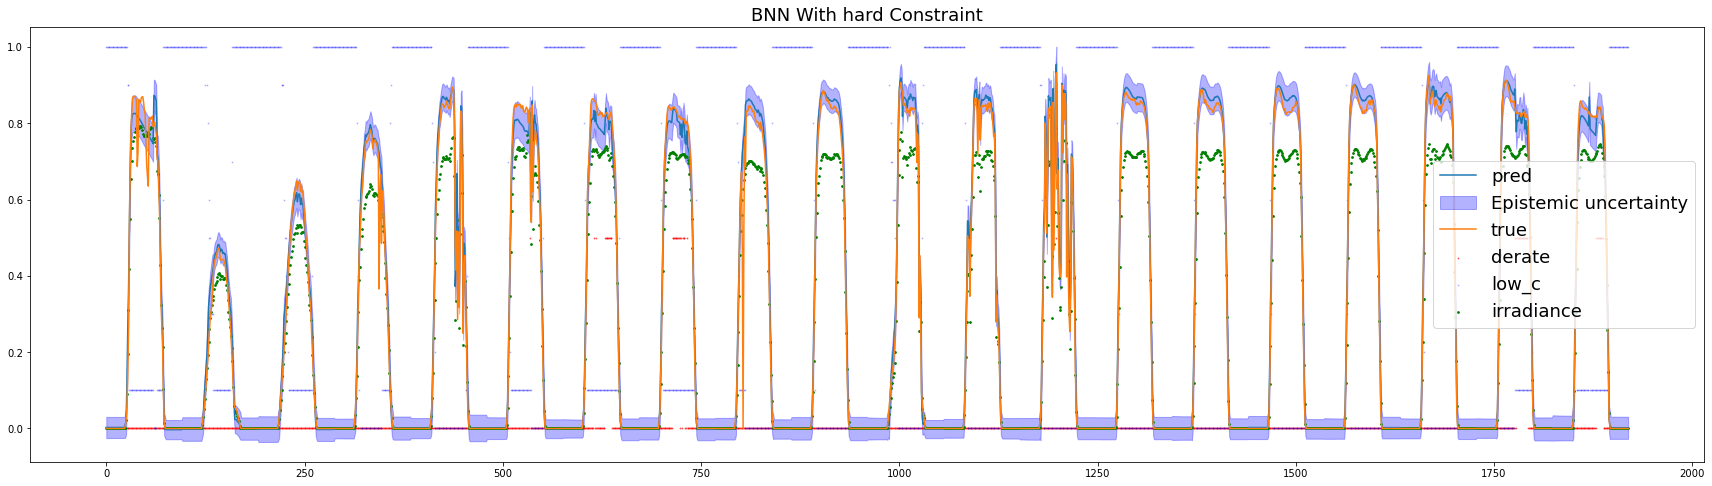

In [43]:
test_w=test_result_w.mean(1)
plt.figure(figsize=(30, 8))
visualization_period_1=10
visualization_period_2=30
epistemic_w = (test_result_w.var(axis = 1)**0.5).cpu().detach().numpy()
subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
low_subset=testX[-visualization_period_2*96:-visualization_period_1*96,6].cpu().numpy()
subset=subset.cpu().numpy()
aaa=np.where(subset>0.01)[0]/96
derate_plot=np.where(subset>0.01,0.5,0)
# low_plot=np.where(low_subset>0.01,0.2,0)
derate_plot
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

length=len(pred[-visualization_period_2*96:-visualization_period_1*96])
pred=test_w.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
plt.title('BNN With hard Constraint',fontsize=18)
plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
plt.fill_between( np.linspace(0, length-1, length),((pred - 3*epistemic_w)[-visualization_period_2*96:-visualization_period_1*96]),((pred + 3*epistemic_w)[-visualization_period_2*96:-visualization_period_1*96]), alpha = 0.3,color='blue', label = 'Epistemic uncertainty')
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
plt.scatter(np.array(np.arange(len(derate_plot))),derate_plot,s=1,c='red',alpha=0.5,label='derate')
plt.scatter(np.array(np.arange(len(derate_plot))),low_subset,s=1,c='b',alpha=0.2,label='low_c')
plt.scatter(np.array(np.arange(len(derate_plot))),subset_irra,s=3,c='green',label='irradiance')
plt.legend(fontsize=18)

# Train with soft constraint



In [49]:
net = BayesianNet().to(device)
loss_func = torch.nn.MSELoss()  
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=True)
# train the network
s1=1
s2=1
rho1=1
rho2=1
for t in range(400):
    all_loss=0
    train_loss=0
    train_complexity_loss=0
    derate_loss=0
    low_loss=0
    if t<40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
    if t>=40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    if t>=90:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

   
    fit_loss_total = 0
    KL_loss_total=0
    c1 = 0
    c2 = 0
    c1_loss_sum = 0
    c2_loss_sum = 0
    for i, ((x, y),(d0,d1),(f0,f1)) in enumerate(zip(trainloader,derate_loader,off_loader)):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        fit_loss_total  += loss
        complexity_loss = kl_loss(net)
        optimizer.zero_grad()
        
        #Constraint predictions
        derate0_output = net(d0)
        derate1_output = net(d1)
        off0_output = net(f0)
        off1_output = net(f1)

        #constraint loss matrix:
        d = derate1_output-derate0_output
        d[d<0] = 1e-6   #<0   +/-
        con_derate = torch.mean(d)
        f = off1_output-off0_output
        f[f<0] = 1e-6
        con_off = torch.mean(f)


        c1_mean = -1*con_derate
        c2_mean = -1*con_off


        c1 += c1_mean
        c2 += c2_mean
     
        total_loss = 50*(loss+0.009*complexity_loss)-c1_mean-c2_mean
        
#         print(complexity_loss,loss)

        total_loss.backward()
        optimizer.step()
        all_loss += total_loss
        train_complexity_loss += complexity_loss
        derate_loss += con_derate
    train_loss_avg = fit_loss_total/len(trainloader)
    train_complexity_loss_avg=train_complexity_loss/len(trainloader)
    all_loss_avg=all_loss/len(trainloader)
    c1_avg = c1/len(trainloader)
    c2_avg = c2/len(trainloader)


    s1 = torch.max(torch.tensor(0.),s1-rho1*torch.tensor(c1_avg.detach().clone()))     
    s2 = torch.max(torch.tensor(0.),s2-rho2*torch.tensor(c2_avg.detach().clone()))
    if (t+1)%2==0:
        print('epoch:',t, 'c1:',c1_avg.item(),'c2:',c2_avg.item(),'s1:',s1.item(),'s2:',s2.item(),'fit:',10*train_loss_avg.item(),'complexity:',0.005*train_complexity_loss_avg.item(),'total:',train_loss_avg.item())
    if (t+1)%20==0:
        for i, (data, target) in enumerate(testloader):
            output_test = net(data)
            loss = loss_func(output_test, target)
            test_loss += loss.item()*data.size(0)
        test_loss_avg = test_loss/len(testloader.sampler)
        print('test loss:',test_loss_avg)
    if c1_avg>-1*1e-4 and c2_avg>-1*1e-4:
        break


/tmp/ipykernel_4141088/3376780838.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s1 = torch.max(torch.tensor(0.),s1-rho1*torch.tensor(c1_avg.detach().clone()))
/tmp/ipykernel_4141088/3376780838.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s2 = torch.max(torch.tensor(0.),s2-rho2*torch.tensor(c2_avg.detach().clone()))


epoch: 1 c1: -0.025144062936306 c2: -0.020043885335326195 s1: 1.0413464307785034 s2: 1.0368683338165283 fit: 0.07380074821412563 complexity: 0.002792385518550873 total: 0.007380074821412563


epoch: 3 c1: -0.021738793700933456 c2: -0.019271070137619972 s1: 1.0827327966690063 s2: 1.0762977600097656 fit: 0.04178169649094343 complexity: 5.703404312953353e-06 total: 0.004178169649094343


epoch: 5 c1: -0.018928920850157738 c2: -0.01931890845298767 s1: 1.1226270198822021 s2: 1.1163071393966675 fit: 0.03396571148186922 complexity: 5.533402436412871e-06 total: 0.003396571148186922


epoch: 7 c1: -0.018489452078938484 c2: -0.019403256475925446 s1: 1.1591488122940063 s2: 1.1548011302947998 fit: 0.029248709324747324 complexity: 5.505072767846287e-06 total: 0.0029248709324747324


epoch: 9 c1: -0.01810801587998867 c2: -0.018582060933113098 s1: 1.1945477724075317 s2: 1.1923608779907227 fit: 0.029746408108621836 complexity: 5.479202955029905e-06 total: 0.0029746408108621836


epoch: 11 c1: -0.01841997541487217 c2: -0.016524527221918106 s1: 1.2286572456359863 s2: 1.2255991697311401 fit: 0.02647833665832877 complexity: 4.862536734435707e-06 total: 0.002647833665832877


epoch: 13 c1: -0.015514984726905823 c2: -0.01770506240427494 s1: 1.261836051940918 s2: 1.2618584632873535 fit: 0.02608584938570857 complexity: 5.233109113760293e-06 total: 0.002608584938570857


epoch: 15 c1: -0.0169062539935112 c2: -0.014568434096872807 s1: 1.296671986579895 s2: 1.2947684526443481 fit: 0.02510184422135353 complexity: 4.157289222348481e-06 total: 0.002510184422135353


epoch: 17 c1: -0.015948032960295677 c2: -0.01793513260781765 s1: 1.3290824890136719 s2: 1.330817699432373 fit: 0.026098161470144987 complexity: 5.562201840803028e-06 total: 0.0026098161470144987


epoch: 19 c1: -0.01618148572742939 c2: -0.014512506313621998 s1: 1.3634833097457886 s2: 1.362235188484192 fit: 0.023716636933386326 complexity: 4.264818562660367e-06 total: 0.0023716636933386326
test loss: 0.0025387315152534127


epoch: 21 c1: -0.014529605396091938 c2: -0.014517882838845253 s1: 1.3928362131118774 s2: 1.39234459400177 fit: 0.023745952639728785 complexity: 5.325531819835305e-06 total: 0.0023745952639728785


epoch: 23 c1: -0.014841361902654171 c2: -0.015157432295382023 s1: 1.4239052534103394 s2: 1.421234369277954 fit: 0.02361337887123227 complexity: 5.125071038492024e-06 total: 0.002361337887123227


epoch: 25 c1: -0.01508301217108965 c2: -0.015254500322043896 s1: 1.4532809257507324 s2: 1.452310562133789 fit: 0.02348431386053562 complexity: 6.1064341571182016e-06 total: 0.002348431386053562


epoch: 27 c1: -0.015041569247841835 c2: -0.014211374334990978 s1: 1.4828743934631348 s2: 1.4818663597106934 fit: 0.023232128005474806 complexity: 6.208420963957906e-06 total: 0.0023232128005474806


epoch: 29 c1: -0.013355331495404243 c2: -0.014768125489354134 s1: 1.5100460052490234 s2: 1.5112687349319458 fit: 0.02199459820985794 complexity: 4.8304334632121024e-06 total: 0.002199459820985794


epoch: 31 c1: -0.014955825172364712 c2: -0.0148931248113513 s1: 1.5396039485931396 s2: 1.5415019989013672 fit: 0.022368698846548796 complexity: 5.666668876074255e-06 total: 0.0022368698846548796


epoch: 33 c1: -0.013548150658607483 c2: -0.014631967060267925 s1: 1.5672165155410767 s2: 1.5705018043518066 fit: 0.020887970458716154 complexity: 5.2620581118389965e-06 total: 0.0020887970458716154


epoch: 35 c1: -0.013569716364145279 c2: -0.013552507385611534 s1: 1.5938067436218262 s2: 1.5999571084976196 fit: 0.020833145827054977 complexity: 5.215402343310416e-06 total: 0.0020833145827054977


epoch: 37 c1: -0.014581252820789814 c2: -0.014028368517756462 s1: 1.622318983078003 s2: 1.6286368370056152 fit: 0.02062868792563677 complexity: 5.072081694379449e-06 total: 0.002062868792563677


epoch: 39 c1: -0.014046143740415573 c2: -0.014158138073980808 s1: 1.6505364179611206 s2: 1.6565676927566528 fit: 0.019447915256023407 complexity: 4.458627081476152e-06 total: 0.0019447915256023407
test loss: 0.003923153958271836


epoch: 41 c1: -0.013748468831181526 c2: -0.01326756551861763 s1: 1.678861379623413 s2: 1.683635950088501 fit: 0.02025531604886055 complexity: 3.6660771002061664e-06 total: 0.002025531604886055


epoch: 43 c1: -0.013294026255607605 c2: -0.01308224443346262 s1: 1.7055180072784424 s2: 1.7099796533584595 fit: 0.020031286403536797 complexity: 3.317940281704068e-06 total: 0.0020031286403536797


epoch: 45 c1: -0.01416971068829298 c2: -0.012850609607994556 s1: 1.7331269979476929 s2: 1.7365962266921997 fit: 0.020249306689947844 complexity: 3.510770620778203e-06 total: 0.0020249306689947844


epoch: 47 c1: -0.014204957522451878 c2: -0.013396554626524448 s1: 1.760101079940796 s2: 1.7629376649856567 fit: 0.020106323063373566 complexity: 3.6473010550253093e-06 total: 0.0020106323063373566


epoch: 49 c1: -0.011411228217184544 c2: -0.012187615036964417 s1: 1.7843633890151978 s2: 1.7888392210006714 fit: 0.01956448657438159 complexity: 2.9674379038624465e-06 total: 0.001956448657438159


epoch: 51 c1: -0.013034224510192871 c2: -0.013433163054287434 s1: 1.810300588607788 s2: 1.816719651222229 fit: 0.019576179329305887 complexity: 3.640520735643804e-06 total: 0.0019576179329305887


epoch: 53 c1: -0.012513312511146069 c2: -0.013403896242380142 s1: 1.8364427089691162 s2: 1.843055009841919 fit: 0.019701598212122917 complexity: 3.4625447005964817e-06 total: 0.0019701598212122917


epoch: 55 c1: -0.0134477773681283 c2: -0.013047254644334316 s1: 1.8624769449234009 s2: 1.8692681789398193 fit: 0.018819381948560476 complexity: 3.373904328327626e-06 total: 0.0018819381948560476


epoch: 57 c1: -0.013978466391563416 c2: -0.013621645048260689 s1: 1.8898165225982666 s2: 1.8958027362823486 fit: 0.01920748269185424 complexity: 3.485499764792621e-06 total: 0.0019207482691854239


epoch: 59 c1: -0.01294554490596056 c2: -0.013291203416883945 s1: 1.9155489206314087 s2: 1.9228557348251343 fit: 0.01934423460625112 complexity: 3.3474087831564247e-06 total: 0.001934423460625112
test loss: 0.005203985001989053


epoch: 61 c1: -0.012397314421832561 c2: -0.011492818593978882 s1: 1.9396048784255981 s2: 1.946509838104248 fit: 0.01844870042987168 complexity: 2.9629716300405564e-06 total: 0.0018448700429871678


epoch: 63 c1: -0.011632036417722702 c2: -0.012758994475007057 s1: 1.9657548666000366 s2: 1.9709346294403076 fit: 0.01864018850028515 complexity: 3.491421521175653e-06 total: 0.0018640188500285149


epoch: 65 c1: -0.012824089266359806 c2: -0.011777302250266075 s1: 1.9916112422943115 s2: 1.995048999786377 fit: 0.018828175961971283 complexity: 2.787921403069049e-06 total: 0.0018828175961971283


epoch: 67 c1: -0.01264929585158825 c2: -0.012619869783520699 s1: 2.017798900604248 s2: 2.020380973815918 fit: 0.018409591866657138 complexity: 3.776621597353369e-06 total: 0.0018409591866657138


epoch: 69 c1: -0.013458088040351868 c2: -0.012667186558246613 s1: 2.044525623321533 s2: 2.0459327697753906 fit: 0.01868897001259029 complexity: 3.3659447217360138e-06 total: 0.001868897001259029


epoch: 71 c1: -0.012385090813040733 c2: -0.011533034034073353 s1: 2.0705177783966064 s2: 2.0694761276245117 fit: 0.018567393999546766 complexity: 3.254176408518106e-06 total: 0.0018567393999546766


epoch: 73 c1: -0.012960166670382023 c2: -0.012216785922646523 s1: 2.095008611679077 s2: 2.09424090385437 fit: 0.018325678538531065 complexity: 2.978172560688108e-06 total: 0.0018325678538531065


epoch: 75 c1: -0.01163469534367323 c2: -0.012147302739322186 s1: 2.1191256046295166 s2: 2.11922287940979 fit: 0.018211097922176123 complexity: 3.101004695054144e-06 total: 0.0018211097922176123


epoch: 77 c1: -0.01228316966444254 c2: -0.010822024196386337 s1: 2.143704414367676 s2: 2.142514944076538 fit: 0.018114023841917515 complexity: 3.2006282708607614e-06 total: 0.0018114023841917515


epoch: 79 c1: -0.012426807545125484 c2: -0.012110219337046146 s1: 2.1679580211639404 s2: 2.167147636413574 fit: 0.017648189095780253 complexity: 3.246015403419733e-06 total: 0.0017648189095780253
test loss: 0.00655829921320278


epoch: 81 c1: -0.011874989606440067 c2: -0.01295721996575594 s1: 2.193051815032959 s2: 2.1935646533966064 fit: 0.018611681880429387 complexity: 3.5117255174554885e-06 total: 0.0018611681880429387


epoch: 83 c1: -0.01171059813350439 c2: -0.011545316316187382 s1: 2.2156784534454346 s2: 2.2172904014587402 fit: 0.01804486382752657 complexity: 3.4510760451667013e-06 total: 0.001804486382752657


epoch: 85 c1: -0.011667247861623764 c2: -0.011637981049716473 s1: 2.238623857498169 s2: 2.240293025970459 fit: 0.017458138754591346 complexity: 3.6744074895977976e-06 total: 0.0017458138754591346


epoch: 87 c1: -0.011413411237299442 c2: -0.011645975522696972 s1: 2.2612881660461426 s2: 2.2644426822662354 fit: 0.01839791191741824 complexity: 3.4433597465977073e-06 total: 0.0018397911917418242


epoch: 89 c1: -0.010951593518257141 c2: -0.011595722287893295 s1: 2.284677743911743 s2: 2.28688907623291 fit: 0.018163190688937902 complexity: 3.4926386433653536e-06 total: 0.0018163190688937902


epoch: 91 c1: -0.01225590892136097 c2: -0.012455979362130165 s1: 2.3086254596710205 s2: 2.3101508617401123 fit: 0.018698335625231266 complexity: 3.005082835443318e-06 total: 0.0018698335625231266


epoch: 93 c1: -0.011130274273455143 c2: -0.01136813871562481 s1: 2.3307971954345703 s2: 2.333526611328125 fit: 0.018564293859526515 complexity: 3.4268159652128816e-06 total: 0.0018564293859526515


epoch: 95 c1: -0.011942239478230476 c2: -0.010799664072692394 s1: 2.3543434143066406 s2: 2.3575565814971924 fit: 0.017936481162905693 complexity: 2.608386566862464e-06 total: 0.0017936481162905693


epoch: 97 c1: -0.01291751116514206 c2: -0.01123034954071045 s1: 2.3792293071746826 s2: 2.3794827461242676 fit: 0.018909414066001773 complexity: 2.7128809597343208e-06 total: 0.0018909414066001773


epoch: 99 c1: -0.01151798665523529 c2: -0.011807688511908054 s1: 2.402886390686035 s2: 2.4030628204345703 fit: 0.018052549567073584 complexity: 2.692437556106597e-06 total: 0.0018052549567073584
test loss: 0.007852261870936881


epoch: 101 c1: -0.011029761284589767 c2: -0.011184854432940483 s1: 2.427319049835205 s2: 2.426330804824829 fit: 0.01758729573339224 complexity: 2.499497786629945e-06 total: 0.0017587295733392239


epoch: 103 c1: -0.012628593482077122 c2: -0.011197454296052456 s1: 2.4520044326782227 s2: 2.4479119777679443 fit: 0.018427318427711725 complexity: 2.6074275956489145e-06 total: 0.0018427318427711725


epoch: 105 c1: -0.011936579830944538 c2: -0.011328394524753094 s1: 2.4771268367767334 s2: 2.4701640605926514 fit: 0.018520354060456157 complexity: 3.0099423020146788e-06 total: 0.0018520354060456157


epoch: 107 c1: -0.011164357885718346 c2: -0.012412871234118938 s1: 2.499249219894409 s2: 2.4939723014831543 fit: 0.0182804511860013 complexity: 2.915671211667359e-06 total: 0.00182804511860013


epoch: 109 c1: -0.011673735454678535 c2: -0.012223056517541409 s1: 2.522514820098877 s2: 2.5186643600463867 fit: 0.018218548502773046 complexity: 2.7100802981294694e-06 total: 0.0018218548502773046


epoch: 111 c1: -0.010992187075316906 c2: -0.012566865421831608 s1: 2.544515371322632 s2: 2.5428082942962646 fit: 0.01795843825675547 complexity: 2.6323142810724677e-06 total: 0.0017958438256755471


epoch: 113 c1: -0.011659668758511543 c2: -0.01158705074340105 s1: 2.567643880844116 s2: 2.567448377609253 fit: 0.01854048576205969 complexity: 3.231093869544566e-06 total: 0.0018540485762059689


epoch: 115 c1: -0.01175589021295309 c2: -0.012335735373198986 s1: 2.5914018154144287 s2: 2.591148853302002 fit: 0.01785529195331037 complexity: 2.742480137385428e-06 total: 0.001785529195331037


epoch: 117 c1: -0.011679847724735737 c2: -0.011133002117276192 s1: 2.615004062652588 s2: 2.6138522624969482 fit: 0.017587776528671384 complexity: 2.6407482801005244e-06 total: 0.0017587776528671384


epoch: 119 c1: -0.011201768182218075 c2: -0.010184022597968578 s1: 2.6374099254608154 s2: 2.6350090503692627 fit: 0.017534760991111398 complexity: 2.4083735479507597e-06 total: 0.0017534760991111398
test loss: 0.009121210415984236


epoch: 121 c1: -0.011346693150699139 c2: -0.01167136151343584 s1: 2.660719156265259 s2: 2.658583641052246 fit: 0.017758255125954747 complexity: 2.633337862789631e-06 total: 0.0017758255125954747


epoch: 123 c1: -0.010771547444164753 c2: -0.011373398825526237 s1: 2.6827950477600098 s2: 2.6814563274383545 fit: 0.01834625960327685 complexity: 2.8625663253478706e-06 total: 0.0018346259603276849


epoch: 125 c1: -0.011821298860013485 c2: -0.011550779454410076 s1: 2.705792188644409 s2: 2.7054030895233154 fit: 0.01756767393089831 complexity: 2.616833953652531e-06 total: 0.0017567673930898309


epoch: 127 c1: -0.011746643111109734 c2: -0.011198095977306366 s1: 2.7282633781433105 s2: 2.7283477783203125 fit: 0.01738933497108519 complexity: 2.6970650651492178e-06 total: 0.001738933497108519


epoch: 129 c1: -0.01136951893568039 c2: -0.0112767294049263 s1: 2.750016927719116 s2: 2.751279354095459 fit: 0.01798574929125607 complexity: 2.414818009128794e-06 total: 0.001798574929125607


epoch: 131 c1: -0.011602961458265781 c2: -0.011467470787465572 s1: 2.7738373279571533 s2: 2.774498462677002 fit: 0.01750648021697998 complexity: 2.3759723990224304e-06 total: 0.001750648021697998


epoch: 133 c1: -0.010575531050562859 c2: -0.010605240240693092 s1: 2.795470952987671 s2: 2.797945737838745 fit: 0.01772073097527027 complexity: 2.579715219326317e-06 total: 0.0017720730975270271


epoch: 135 c1: -0.011434696614742279 c2: -0.011894588358700275 s1: 2.8179709911346436 s2: 2.8212788105010986 fit: 0.016724563902243972 complexity: 2.3525621509179472e-06 total: 0.0016724563902243972


epoch: 137 c1: -0.011971519328653812 c2: -0.01136963814496994 s1: 2.841535806655884 s2: 2.8439087867736816 fit: 0.018031946383416653 complexity: 2.814356121234596e-06 total: 0.0018031946383416653


epoch: 139 c1: -0.011585039086639881 c2: -0.011389718391001225 s1: 2.8652572631835938 s2: 2.865859031677246 fit: 0.01726713846437633 complexity: 2.7172235422767698e-06 total: 0.001726713846437633
test loss: 0.010350388350795556


epoch: 141 c1: -0.01118539646267891 c2: -0.011589162983000278 s1: 2.887974262237549 s2: 2.8888542652130127 fit: 0.017139072297140956 complexity: 2.408145519439131e-06 total: 0.0017139072297140956


epoch: 143 c1: -0.01160703506320715 c2: -0.01057270634919405 s1: 2.9102394580841064 s2: 2.9107935428619385 fit: 0.016849326202645898 complexity: 2.257008163724095e-06 total: 0.0016849326202645898


epoch: 145 c1: -0.010539031587541103 c2: -0.011345217935740948 s1: 2.93184494972229 s2: 2.9331395626068115 fit: 0.017380325589329004 complexity: 2.522590511944145e-06 total: 0.0017380325589329004


epoch: 147 c1: -0.01148493867367506 c2: -0.012103645130991936 s1: 2.9545071125030518 s2: 2.9550650119781494 fit: 0.016824703197926283 complexity: 2.3148821492213754e-06 total: 0.0016824703197926283


epoch: 149 c1: -0.011989949271082878 c2: -0.011458585038781166 s1: 2.977818727493286 s2: 2.977853536605835 fit: 0.017090796027332544 complexity: 2.0861906523350625e-06 total: 0.0017090796027332544


epoch: 151 c1: -0.011389121413230896 c2: -0.012093659490346909 s1: 3.0008769035339355 s2: 3.0008580684661865 fit: 0.016952984733507037 complexity: 2.7926586335524918e-06 total: 0.0016952984733507037


epoch: 153 c1: -0.011159961111843586 c2: -0.010019399225711823 s1: 3.02242374420166 s2: 3.0218396186828613 fit: 0.016912026330828667 complexity: 2.5061683845706286e-06 total: 0.0016912026330828667


epoch: 155 c1: -0.011678549461066723 c2: -0.011536991223692894 s1: 3.0445539951324463 s2: 3.044862747192383 fit: 0.01734577468596399 complexity: 2.2164442634675654e-06 total: 0.0017345774685963988


epoch: 157 c1: -0.010283134877681732 c2: -0.011177211999893188 s1: 3.0655956268310547 s2: 3.0671722888946533 fit: 0.01844256417825818 complexity: 2.9019528301432728e-06 total: 0.001844256417825818


epoch: 159 c1: -0.010460944846272469 c2: -0.01100850012153387 s1: 3.0877206325531006 s2: 3.0887608528137207 fit: 0.01674948842264712 complexity: 2.195123815909028e-06 total: 0.0016749488422647119
test loss: 0.011520161058954873


epoch: 161 c1: -0.01174925360828638 c2: -0.010912906378507614 s1: 3.1103532314300537 s2: 3.1116249561309814 fit: 0.017556389793753624 complexity: 2.916538214776665e-06 total: 0.0017556389793753624


epoch: 163 c1: -0.011661742813885212 c2: -0.01094740629196167 s1: 3.1333513259887695 s2: 3.1334750652313232 fit: 0.016624985728412867 complexity: 2.3262572358362376e-06 total: 0.0016624985728412867


epoch: 165 c1: -0.010944793000817299 c2: -0.011185964569449425 s1: 3.1550440788269043 s2: 3.1558215618133545 fit: 0.016725860768929124 complexity: 2.633743570186198e-06 total: 0.0016725860768929124


epoch: 167 c1: -0.011156340129673481 c2: -0.0107423085719347 s1: 3.1775529384613037 s2: 3.1776719093322754 fit: 0.0164950720500201 complexity: 2.0915057393722235e-06 total: 0.0016495072050020099


epoch: 169 c1: -0.011260800994932652 c2: -0.010202834382653236 s1: 3.1998417377471924 s2: 3.1995620727539062 fit: 0.01739419298246503 complexity: 2.4925105390138923e-06 total: 0.0017394192982465029


epoch: 171 c1: -0.011031737551093102 c2: -0.010229047387838364 s1: 3.2231063842773438 s2: 3.2204749584198 fit: 0.016692732460796833 complexity: 2.209072408732027e-06 total: 0.0016692732460796833


epoch: 173 c1: -0.011196514591574669 c2: -0.011754988692700863 s1: 3.2453722953796387 s2: 3.2432799339294434 fit: 0.01646022079512477 complexity: 2.465035649947822e-06 total: 0.001646022079512477


epoch: 175 c1: -0.01148033794015646 c2: -0.010023540817201138 s1: 3.268346071243286 s2: 3.2642343044281006 fit: 0.017299166647717357 complexity: 2.5332687073387205e-06 total: 0.0017299166647717357


epoch: 177 c1: -0.010235760360956192 c2: -0.010602802969515324 s1: 3.2895374298095703 s2: 3.2846932411193848 fit: 0.017120213015004992 complexity: 2.6888179127126933e-06 total: 0.0017120213015004992


epoch: 179 c1: -0.01039702445268631 c2: -0.011364348232746124 s1: 3.3108901977539062 s2: 3.3072314262390137 fit: 0.01743155880831182 complexity: 2.6845664251595736e-06 total: 0.001743155880831182
test loss: 0.012661297249807626


epoch: 181 c1: -0.011123478412628174 c2: -0.011194550432264805 s1: 3.332979202270508 s2: 3.3303472995758057 fit: 0.01628011930733919 complexity: 2.3105196305550637e-06 total: 0.0016280119307339191


epoch: 183 c1: -0.010290654376149178 c2: -0.010488090105354786 s1: 3.354060649871826 s2: 3.3515233993530273 fit: 0.01699468237347901 complexity: 2.4072002270258964e-06 total: 0.0016994682373479009


epoch: 185 c1: -0.010784631595015526 c2: -0.011277046985924244 s1: 3.37618350982666 s2: 3.3736789226531982 fit: 0.01719086547382176 complexity: 2.7166010113433003e-06 total: 0.001719086547382176


epoch: 187 c1: -0.009697220288217068 c2: -0.011227725073695183 s1: 3.3970072269439697 s2: 3.396456003189087 fit: 0.017002223758026958 complexity: 2.5639208615757528e-06 total: 0.0017002223758026958


epoch: 189 c1: -0.009593602269887924 c2: -0.010679032653570175 s1: 3.417858600616455 s2: 3.417682409286499 fit: 0.016944927629083395 complexity: 2.325850946363062e-06 total: 0.0016944927629083395


epoch: 191 c1: -0.01148243248462677 c2: -0.010895815677940845 s1: 3.438542127609253 s2: 3.4380149841308594 fit: 0.016236375086009502 complexity: 1.9065783999394626e-06 total: 0.0016236375086009502


epoch: 193 c1: -0.010475339367985725 c2: -0.011482633650302887 s1: 3.4598145484924316 s2: 3.4608800411224365 fit: 0.016952408477663994 complexity: 2.2771999647375195e-06 total: 0.0016952408477663994


epoch: 195 c1: -0.009839106351137161 c2: -0.010362337343394756 s1: 3.480334520339966 s2: 3.482980251312256 fit: 0.017004526453092694 complexity: 2.6398853515274824e-06 total: 0.0017004526453092694


epoch: 197 c1: -0.01105581596493721 c2: -0.010559305548667908 s1: 3.501906156539917 s2: 3.5047757625579834 fit: 0.016977388877421618 complexity: 2.628372749313712e-06 total: 0.0016977388877421618


epoch: 199 c1: -0.012089191935956478 c2: -0.010422410443425179 s1: 3.52408766746521 s2: 3.5254764556884766 fit: 0.016410171519964933 complexity: 2.445093996357173e-06 total: 0.0016410171519964933
test loss: 0.013791108862554238


epoch: 201 c1: -0.010560976341366768 c2: -0.010288265533745289 s1: 3.5455355644226074 s2: 3.5463387966156006 fit: 0.01648341305553913 complexity: 2.5421628379262985e-06 total: 0.0016483413055539131


epoch: 203 c1: -0.010465382598340511 c2: -0.010405930690467358 s1: 3.5673139095306396 s2: 3.566746234893799 fit: 0.01699359272606671 complexity: 2.5770632782950998e-06 total: 0.0016993592726066709


epoch: 205 c1: -0.0105522982776165 c2: -0.011167246848344803 s1: 3.587703227996826 s2: 3.587867498397827 fit: 0.017035251948982477 complexity: 2.4964922340586784e-06 total: 0.0017035251948982477


epoch: 207 c1: -0.009713923558592796 c2: -0.010472563095390797 s1: 3.6086599826812744 s2: 3.609381914138794 fit: 0.016497907927259803 complexity: 2.556580875534564e-06 total: 0.0016497907927259803


epoch: 209 c1: -0.010640857741236687 c2: -0.010132414288818836 s1: 3.6298892498016357 s2: 3.6299264430999756 fit: 0.016026310622692108 complexity: 2.3465610865969213e-06 total: 0.0016026310622692108


epoch: 211 c1: -0.008954528719186783 c2: -0.009894653223454952 s1: 3.649968385696411 s2: 3.65028977394104 fit: 0.01644464791752398 complexity: 1.9087322289124134e-06 total: 0.001644464791752398


epoch: 213 c1: -0.010060053318738937 c2: -0.012295668013393879 s1: 3.670672655105591 s2: 3.673227071762085 fit: 0.016642013797536492 complexity: 2.5030432152561844e-06 total: 0.0016642013797536492


epoch: 215 c1: -0.010852632112801075 c2: -0.010022223927080631 s1: 3.6922495365142822 s2: 3.695024013519287 fit: 0.016649735625833273 complexity: 2.588330826256424e-06 total: 0.0016649735625833273


epoch: 217 c1: -0.00992214772850275 c2: -0.011143161915242672 s1: 3.7121427059173584 s2: 3.7179174423217773 fit: 0.016985703259706497 complexity: 2.5569673744030296e-06 total: 0.0016985703259706497


epoch: 219 c1: -0.0109550841152668 c2: -0.010383904911577702 s1: 3.7327980995178223 s2: 3.738046169281006 fit: 0.01616316381841898 complexity: 2.417206851532683e-06 total: 0.001616316381841898
test loss: 0.015046824711847467


epoch: 221 c1: -0.010429177433252335 c2: -0.010250463150441647 s1: 3.753455400466919 s2: 3.759378433227539 fit: 0.016333928797394037 complexity: 2.4199475592467934e-06 total: 0.0016333928797394037


epoch: 223 c1: -0.011085182428359985 c2: -0.00997093878686428 s1: 3.7742414474487305 s2: 3.780846357345581 fit: 0.01614091917872429 complexity: 2.2446716320700944e-06 total: 0.001614091917872429


epoch: 225 c1: -0.010561030358076096 c2: -0.01056116446852684 s1: 3.7959423065185547 s2: 3.8020243644714355 fit: 0.016392675461247563 complexity: 2.427108847768977e-06 total: 0.0016392675461247563


epoch: 227 c1: -0.011561588384211063 c2: -0.010080399923026562 s1: 3.8196511268615723 s2: 3.822939395904541 fit: 0.01679303590208292 complexity: 2.7497479459270834e-06 total: 0.001679303590208292


epoch: 229 c1: -0.010749498382210732 c2: -0.010980077087879181 s1: 3.8410098552703857 s2: 3.8436853885650635 fit: 0.016338408458977938 complexity: 2.3668198264203965e-06 total: 0.0016338408458977938


epoch: 231 c1: -0.011359188705682755 c2: -0.011277724988758564 s1: 3.8636858463287354 s2: 3.8658065795898438 fit: 0.016809095395728946 complexity: 2.547694020904601e-06 total: 0.0016809095395728946


epoch: 233 c1: -0.00958001334220171 c2: -0.010217193514108658 s1: 3.883819341659546 s2: 3.8876612186431885 fit: 0.015727399149909616 complexity: 2.3060437524691223e-06 total: 0.0015727399149909616


epoch: 235 c1: -0.009856016375124454 c2: -0.00999906100332737 s1: 3.9033854007720947 s2: 3.907501697540283 fit: 0.016259935218840837 complexity: 2.3865261755418035e-06 total: 0.0016259935218840837


epoch: 237 c1: -0.009875897318124771 c2: -0.010062156245112419 s1: 3.9231643676757812 s2: 3.928499221801758 fit: 0.016336842672899365 complexity: 2.2127108240965756e-06 total: 0.0016336842672899365


epoch: 239 c1: -0.011091381311416626 c2: -0.010455421172082424 s1: 3.9453251361846924 s2: 3.9492955207824707 fit: 0.01697166240774095 complexity: 2.803573152050376e-06 total: 0.001697166240774095
test loss: 0.016231120780778867


epoch: 241 c1: -0.009987293742597103 c2: -0.009861144237220287 s1: 3.965898275375366 s2: 3.9692039489746094 fit: 0.01574580790475011 complexity: 2.0866152772214266e-06 total: 0.0015745807904750109


epoch: 243 c1: -0.01024090126156807 c2: -0.010080437175929546 s1: 3.986403465270996 s2: 3.9897522926330566 fit: 0.01578692113980651 complexity: 2.058035897789523e-06 total: 0.001578692113980651


epoch: 245 c1: -0.009955261833965778 c2: -0.009957348927855492 s1: 4.007339000701904 s2: 4.009358882904053 fit: 0.016150352312251925 complexity: 2.4172091798391194e-06 total: 0.0016150352312251925


epoch: 247 c1: -0.010059800930321217 c2: -0.010404710657894611 s1: 4.027007102966309 s2: 4.031157970428467 fit: 0.016564856050536036 complexity: 2.568711352068931e-06 total: 0.0016564856050536036


epoch: 249 c1: -0.010035376995801926 c2: -0.010355764999985695 s1: 4.0466461181640625 s2: 4.051543712615967 fit: 0.016037843888625503 complexity: 2.4761029635556042e-06 total: 0.0016037843888625503


epoch: 251 c1: -0.010300327092409134 c2: -0.011374526657164097 s1: 4.067000389099121 s2: 4.072539329528809 fit: 0.015718097565695643 complexity: 2.200552698923275e-06 total: 0.0015718097565695643


epoch: 253 c1: -0.009808547794818878 c2: -0.010660703293979168 s1: 4.087625026702881 s2: 4.094325065612793 fit: 0.01671038568019867 complexity: 2.518802066333592e-06 total: 0.001671038568019867


epoch: 255 c1: -0.010358014144003391 c2: -0.00983352679759264 s1: 4.108558654785156 s2: 4.113840579986572 fit: 0.015988164814189076 complexity: 2.2835994604974986e-06 total: 0.0015988164814189076


epoch: 257 c1: -0.009537316858768463 c2: -0.010210337117314339 s1: 4.128437042236328 s2: 4.134894847869873 fit: 0.01669771852903068 complexity: 2.564347814768553e-06 total: 0.001669771852903068


epoch: 259 c1: -0.009556783363223076 c2: -0.010460096411406994 s1: 4.148387432098389 s2: 4.156239032745361 fit: 0.0161936494987458 complexity: 2.457604859955609e-06 total: 0.00161936494987458
test loss: 0.017350935065590052


epoch: 261 c1: -0.010236498899757862 c2: -0.010076134465634823 s1: 4.168845176696777 s2: 4.177072525024414 fit: 0.01660231384448707 complexity: 2.4372941697947683e-06 total: 0.001660231384448707


epoch: 263 c1: -0.010275566019117832 c2: -0.01009309384971857 s1: 4.189604759216309 s2: 4.197300434112549 fit: 0.016383654437959194 complexity: 2.3789369151927533e-06 total: 0.0016383654437959194


epoch: 265 c1: -0.010266023688018322 c2: -0.010917178355157375 s1: 4.209327220916748 s2: 4.2186503410339355 fit: 0.01605053199455142 complexity: 2.481410338077694e-06 total: 0.001605053199455142


epoch: 267 c1: -0.01003114040941 c2: -0.010377205908298492 s1: 4.229156970977783 s2: 4.239758491516113 fit: 0.01635599066503346 complexity: 2.5764299789443614e-06 total: 0.001635599066503346


epoch: 269 c1: -0.009793665260076523 c2: -0.009312325157225132 s1: 4.248719692230225 s2: 4.259500980377197 fit: 0.015804198337718844 complexity: 2.2647240257356315e-06 total: 0.0015804198337718844


epoch: 271 c1: -0.010293794795870781 c2: -0.01020930614322424 s1: 4.268777370452881 s2: 4.280358791351318 fit: 0.015491994563490152 complexity: 2.114606468239799e-06 total: 0.0015491994563490152


epoch: 273 c1: -0.011064762249588966 c2: -0.009579509496688843 s1: 4.290126800537109 s2: 4.2999444007873535 fit: 0.01667787437327206 complexity: 2.598169667180628e-06 total: 0.0016677874373272061


epoch: 275 c1: -0.009920520707964897 c2: -0.00914089847356081 s1: 4.309876441955566 s2: 4.318990707397461 fit: 0.01682093716226518 complexity: 2.581418084446341e-06 total: 0.0016820937162265182


epoch: 277 c1: -0.009481087327003479 c2: -0.010099289938807487 s1: 4.330458164215088 s2: 4.339457988739014 fit: 0.01643192721530795 complexity: 3.0053919181227683e-06 total: 0.001643192721530795


epoch: 279 c1: -0.009387582540512085 c2: -0.009819087572395802 s1: 4.3499436378479 s2: 4.360066890716553 fit: 0.016281137941405177 complexity: 2.7763820253312586e-06 total: 0.0016281137941405177
test loss: 0.01847570005090595


epoch: 281 c1: -0.010483519174158573 c2: -0.009979485534131527 s1: 4.370739936828613 s2: 4.379482746124268 fit: 0.015606937231495976 complexity: 2.1640677005052567e-06 total: 0.0015606937231495976


epoch: 283 c1: -0.008274451829493046 c2: -0.009958314709365368 s1: 4.389260292053223 s2: 4.399835109710693 fit: 0.016294752713292837 complexity: 2.399373333901167e-06 total: 0.0016294752713292837


epoch: 285 c1: -0.010221214033663273 c2: -0.009292499162256718 s1: 4.4097208976745605 s2: 4.4183759689331055 fit: 0.016233461210504174 complexity: 2.3591489298269154e-06 total: 0.0016233461210504174


epoch: 287 c1: -0.010525169782340527 c2: -0.010196187533438206 s1: 4.429900169372559 s2: 4.438203811645508 fit: 0.016196963842958212 complexity: 2.470623003318906e-06 total: 0.0016196963842958212


epoch: 289 c1: -0.00957984197884798 c2: -0.009849434718489647 s1: 4.450232982635498 s2: 4.459204196929932 fit: 0.016235302900895476 complexity: 2.5111407740041613e-06 total: 0.0016235302900895476


epoch: 291 c1: -0.009613479487597942 c2: -0.009190362878143787 s1: 4.469729423522949 s2: 4.478408336639404 fit: 0.016020581824705005 complexity: 2.3233084357343615e-06 total: 0.0016020581824705005


epoch: 293 c1: -0.009431066922843456 c2: -0.010473844595253468 s1: 4.489525318145752 s2: 4.498783588409424 fit: 0.016012581763789058 complexity: 2.3417508054990323e-06 total: 0.0016012581763789058


epoch: 295 c1: -0.009999103844165802 c2: -0.009284382686018944 s1: 4.509631633758545 s2: 4.518335342407227 fit: 0.015555747086182237 complexity: 2.3943719861563294e-06 total: 0.0015555747086182237


epoch: 297 c1: -0.010232854634523392 c2: -0.010163480415940285 s1: 4.5297675132751465 s2: 4.538674831390381 fit: 0.015995894791558385 complexity: 2.001245302380994e-06 total: 0.0015995894791558385


epoch: 299 c1: -0.009866653010249138 c2: -0.009515554644167423 s1: 4.549410820007324 s2: 4.55776309967041 fit: 0.016080609057098627 complexity: 2.5590660516172646e-06 total: 0.0016080609057098627
test loss: 0.019538332186153615


epoch: 301 c1: -0.00951035600155592 c2: -0.011039071716368198 s1: 4.569415092468262 s2: 4.578922748565674 fit: 0.01567848026752472 complexity: 2.465577854309231e-06 total: 0.001567848026752472


epoch: 303 c1: -0.010440181940793991 c2: -0.011244275607168674 s1: 4.590329647064209 s2: 4.600799083709717 fit: 0.0157971924636513 complexity: 2.4971264065243304e-06 total: 0.00157971924636513


epoch: 305 c1: -0.009812933392822742 c2: -0.009667893871665001 s1: 4.609871864318848 s2: 4.621105670928955 fit: 0.015644225059077144 complexity: 2.4381624825764447e-06 total: 0.0015644225059077144


epoch: 307 c1: -0.010509668849408627 c2: -0.00960802473127842 s1: 4.629230499267578 s2: 4.640210151672363 fit: 0.01557094044983387 complexity: 2.3021726519800723e-06 total: 0.001557094044983387


epoch: 309 c1: -0.009968877770006657 c2: -0.009636254981160164 s1: 4.648344993591309 s2: 4.659831523895264 fit: 0.015587139641866088 complexity: 2.3287671501748264e-06 total: 0.0015587139641866088


epoch: 311 c1: -0.009697728790342808 c2: -0.009478693827986717 s1: 4.667478561401367 s2: 4.679441928863525 fit: 0.015362986596301198 complexity: 2.087929897243157e-06 total: 0.0015362986596301198


epoch: 313 c1: -0.010749871842563152 c2: -0.010454689152538776 s1: 4.688212871551514 s2: 4.698996067047119 fit: 0.01562583725899458 complexity: 2.494214859325439e-06 total: 0.001562583725899458


epoch: 315 c1: -0.009337307885289192 c2: -0.009573272429406643 s1: 4.707638740539551 s2: 4.718799114227295 fit: 0.01556050032377243 complexity: 2.5534289306961003e-06 total: 0.001556050032377243


epoch: 317 c1: -0.00970918033272028 c2: -0.009786708280444145 s1: 4.727982521057129 s2: 4.73847770690918 fit: 0.015502130845561624 complexity: 2.313148434041068e-06 total: 0.0015502130845561624


epoch: 319 c1: -0.00933174230158329 c2: -0.009208976291120052 s1: 4.7467827796936035 s2: 4.756573677062988 fit: 0.015402052085846663 complexity: 2.3190218780655414e-06 total: 0.0015402052085846663
test loss: 0.020683190518319197


epoch: 321 c1: -0.008557313121855259 c2: -0.009978136047720909 s1: 4.76510763168335 s2: 4.777199745178223 fit: 0.016255544032901525 complexity: 2.3514860367868098e-06 total: 0.0016255544032901525


epoch: 323 c1: -0.009457701817154884 c2: -0.009568744339048862 s1: 4.7839789390563965 s2: 4.796668529510498 fit: 0.016105242539197206 complexity: 2.7310452423989773e-06 total: 0.0016105242539197206


epoch: 325 c1: -0.00988792721182108 c2: -0.010607277043163776 s1: 4.802404880523682 s2: 4.817012310028076 fit: 0.01525864121504128 complexity: 2.3377097386401147e-06 total: 0.001525864121504128


epoch: 327 c1: -0.009988992474973202 c2: -0.009497319348156452 s1: 4.821096897125244 s2: 4.836234092712402 fit: 0.015664168167859316 complexity: 2.5768537307158114e-06 total: 0.0015664168167859316


epoch: 329 c1: -0.010454979725182056 c2: -0.010121968574821949 s1: 4.841117858886719 s2: 4.8560638427734375 fit: 0.01516154850833118 complexity: 2.2420816821977495e-06 total: 0.001516154850833118


epoch: 331 c1: -0.00942792184650898 c2: -0.009325714781880379 s1: 4.859405994415283 s2: 4.8751540184021 fit: 0.01560805132612586 complexity: 2.0311940170358866e-06 total: 0.001560805132612586


epoch: 333 c1: -0.009316470474004745 c2: -0.010216392576694489 s1: 4.87824010848999 s2: 4.895841598510742 fit: 0.015549726085737348 complexity: 2.1439531701616942e-06 total: 0.0015549726085737348


epoch: 335 c1: -0.009584087878465652 c2: -0.009768834337592125 s1: 4.896980285644531 s2: 4.91535758972168 fit: 0.015708860009908676 complexity: 1.980039960471913e-06 total: 0.0015708860009908676


epoch: 337 c1: -0.010111546143889427 c2: -0.0095083462074399 s1: 4.916529178619385 s2: 4.934408187866211 fit: 0.015411735512316227 complexity: 2.2509798873215914e-06 total: 0.0015411735512316227


epoch: 339 c1: -0.009547160007059574 c2: -0.010312861762940884 s1: 4.934973239898682 s2: 4.954783916473389 fit: 0.015971603570505977 complexity: 2.445444988552481e-06 total: 0.0015971603570505977
test loss: 0.02179476135314836


epoch: 341 c1: -0.008713983930647373 c2: -0.008428114466369152 s1: 4.953114032745361 s2: 4.972103118896484 fit: 0.015623595099896193 complexity: 2.404010883765295e-06 total: 0.0015623595099896193


epoch: 343 c1: -0.009190899319946766 c2: -0.01005049142986536 s1: 4.97213888168335 s2: 4.991333484649658 fit: 0.015574637800455093 complexity: 2.2925797384232283e-06 total: 0.0015574637800455093


epoch: 345 c1: -0.009472144767642021 c2: -0.00939218606799841 s1: 4.990816116333008 s2: 5.010861396789551 fit: 0.015879092970862985 complexity: 2.166037738788873e-06 total: 0.0015879092970862985


epoch: 347 c1: -0.009018197655677795 c2: -0.009255414828658104 s1: 5.00930643081665 s2: 5.029665946960449 fit: 0.014902625698596239 complexity: 2.1504558390006425e-06 total: 0.001490262569859624


epoch: 349 c1: -0.010138211771845818 c2: -0.009027071297168732 s1: 5.028131484985352 s2: 5.048102855682373 fit: 0.01567969680763781 complexity: 2.5931309210136534e-06 total: 0.001567969680763781


epoch: 351 c1: -0.008975662291049957 c2: -0.00880157109349966 s1: 5.0467023849487305 s2: 5.066127300262451 fit: 0.015197034226730466 complexity: 2.392351598246023e-06 total: 0.0015197034226730466


epoch: 353 c1: -0.00918435025960207 c2: -0.009408372454345226 s1: 5.065807342529297 s2: 5.085122108459473 fit: 0.015497520798817277 complexity: 2.3133322247304024e-06 total: 0.0015497520798817277


epoch: 355 c1: -0.009138170629739761 c2: -0.009345058351755142 s1: 5.084173679351807 s2: 5.10325813293457 fit: 0.015534355770796537 complexity: 2.4789999588392677e-06 total: 0.0015534355770796537


epoch: 357 c1: -0.009184462949633598 c2: -0.009087125770747662 s1: 5.10204553604126 s2: 5.121138572692871 fit: 0.015763355186209083 complexity: 2.5515296147204935e-06 total: 0.0015763355186209083


epoch: 359 c1: -0.00882562156766653 c2: -0.009360364638268948 s1: 5.1201958656311035 s2: 5.140126705169678 fit: 0.01586744445376098 complexity: 2.5693493080325424e-06 total: 0.0015867444453760982
test loss: 0.022943360211329845


epoch: 361 c1: -0.009131877683103085 c2: -0.00895754899829626 s1: 5.138240814208984 s2: 5.158740043640137 fit: 0.014972558710724115 complexity: 2.668604429345578e-06 total: 0.0014972558710724115


epoch: 363 c1: -0.009694364853203297 c2: -0.009795842692255974 s1: 5.157055854797363 s2: 5.178073883056641 fit: 0.015334758209064603 complexity: 2.4325728008989245e-06 total: 0.0015334758209064603


epoch: 365 c1: -0.00967017188668251 c2: -0.008368480019271374 s1: 5.176012992858887 s2: 5.19588041305542 fit: 0.015781940892338753 complexity: 2.5172639288939535e-06 total: 0.0015781940892338753


epoch: 367 c1: -0.009554347954690456 c2: -0.009389640763401985 s1: 5.195366382598877 s2: 5.215063571929932 fit: 0.01534039038233459 complexity: 2.49951786827296e-06 total: 0.001534039038233459


epoch: 369 c1: -0.008882754482328892 c2: -0.008729220367968082 s1: 5.213641166687012 s2: 5.232985973358154 fit: 0.01572036067955196 complexity: 2.443165285512805e-06 total: 0.001572036067955196


epoch: 371 c1: -0.008291685953736305 c2: -0.009589803405106068 s1: 5.231324672698975 s2: 5.252140522003174 fit: 0.015040971338748932 complexity: 2.154583053197712e-06 total: 0.0015040971338748932


epoch: 373 c1: -0.00903845950961113 c2: -0.009754035621881485 s1: 5.250067710876465 s2: 5.271431922912598 fit: 0.01572015811689198 complexity: 2.512898063287139e-06 total: 0.001572015811689198


epoch: 375 c1: -0.008624197915196419 c2: -0.008452020585536957 s1: 5.267625331878662 s2: 5.2892680168151855 fit: 0.015044960891827941 complexity: 2.4050257343333217e-06 total: 0.001504496089182794


epoch: 377 c1: -0.009958241134881973 c2: -0.009236539714038372 s1: 5.287099361419678 s2: 5.307596683502197 fit: 0.01526514533907175 complexity: 2.393872564425692e-06 total: 0.001526514533907175


epoch: 379 c1: -0.009649580344557762 c2: -0.010057482868432999 s1: 5.306478977203369 s2: 5.327180862426758 fit: 0.015394783113151789 complexity: 2.4969314108602704e-06 total: 0.0015394783113151789
test loss: 0.024083577057298855


epoch: 381 c1: -0.009605322033166885 c2: -0.009730222634971142 s1: 5.325352191925049 s2: 5.346538066864014 fit: 0.01534978742711246 complexity: 2.5236752117052676e-06 total: 0.001534978742711246


epoch: 383 c1: -0.009289834648370743 c2: -0.009474472142755985 s1: 5.344334125518799 s2: 5.365249156951904 fit: 0.015334570780396461 complexity: 2.4060404393821954e-06 total: 0.0015334570780396461


epoch: 385 c1: -0.00883796438574791 c2: -0.008890965953469276 s1: 5.3632683753967285 s2: 5.383757591247559 fit: 0.015442189760506153 complexity: 2.1928119531366976e-06 total: 0.0015442189760506153


epoch: 387 c1: -0.009129881858825684 c2: -0.009713155217468739 s1: 5.38134241104126 s2: 5.403470516204834 fit: 0.015060052974149585 complexity: 2.5799983995966615e-06 total: 0.0015060052974149585


epoch: 389 c1: -0.009771174751222134 c2: -0.00923144444823265 s1: 5.399652004241943 s2: 5.4212141036987305 fit: 0.015171400737017393 complexity: 2.619651786517352e-06 total: 0.0015171400737017393


epoch: 391 c1: -0.008469022810459137 c2: -0.009218089282512665 s1: 5.416657447814941 s2: 5.439212799072266 fit: 0.015043161110952497 complexity: 2.451601030770689e-06 total: 0.0015043161110952497


epoch: 393 c1: -0.009064379148185253 c2: -0.009761298075318336 s1: 5.434380054473877 s2: 5.458179950714111 fit: 0.015730353770777583 complexity: 2.3657239216845482e-06 total: 0.0015730353770777583


epoch: 395 c1: -0.009311891160905361 c2: -0.009801993146538734 s1: 5.452692031860352 s2: 5.476603984832764 fit: 0.015461856964975595 complexity: 2.406061685178429e-06 total: 0.0015461856964975595


epoch: 397 c1: -0.009384307079017162 c2: -0.009825381450355053 s1: 5.470739364624023 s2: 5.495480060577393 fit: 0.015287150163203478 complexity: 2.3973241331987085e-06 total: 0.0015287150163203478


epoch: 399 c1: -0.00972783099859953 c2: -0.010064528323709965 s1: 5.489098072052002 s2: 5.515439510345459 fit: 0.015416692476719618 complexity: 2.4261977523565294e-06 total: 0.0015416692476719618
test loss: 0.02522164460680704


In [50]:
torch.save(net.state_dict(), './know_results/revision/soft_backup.pth')

In [51]:
#test
net.load_state_dict(torch.load('./know_results/revision/soft_backup.pth'))
n_sample=50
test_loss=0.0
loss_func = torch.nn.MSELoss()  

test_results_ws=torch.zeros_like(testY)
test_result_ws=test_results_ws.repeat(1,n_sample)
test_loss_sample=0
net.eval()
for t in range(n_sample):
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
#         print(output.shape)
        # calculate the loss
        loss = loss_func(output, target)
        # update running validation loss
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_result_ws[batch_size*i:batch_size*(i+1),t]=output.squeeze()
        else:
            test_result_ws[batch_size*i:,t]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    test_loss_sample+=test_loss_avg
    print(test_loss_avg)
test_sample_avg_ws=test_loss_sample/n_sample
print( 'loss: ',test_sample_avg_ws)


0.0011334159279105332
0.001115673518213882


0.0011297396052241586
0.0011095085798775843


0.0011532880561905675
0.0011383509018816995


0.0011577273628488485
0.0011637781455088117


0.0010813143791136854
0.001144983371812258


0.0011863194266923181
0.0011453538401318447


0.0011082953401199678
0.0010967229525751417


0.0011223426891061945
0.0011000158645015979


0.001091845715902577
0.0010731289746190394


0.00114651760759837
0.0011189751040661159


0.0012004167762088833
0.0010413344038745012


0.0011271247504024769
0.001176751842610165


0.0011117974462850524
0.0011913071296464307


0.0010647311229263815
0.0010864482050064474


0.0011317376708744767
0.0011355762956936737


0.0011292871204126114
0.001156034600372349


0.001212382520794933
0.0011605461095078008


0.0011220790736732658
0.0011695585783803584


0.0011107245970036618
0.0011539803589510256


0.0011547573744497025
0.0010983559556313408


0.001084401562464541
0.0011361237822821943


0.00114549312872571
0.0011126830696644367


0.0011369444692596335
0.0011510219237410228


0.001151575954549455
0.0011978386508937028


0.0012116634308563237
0.0011564658439233249
loss:  0.0011347288222592214


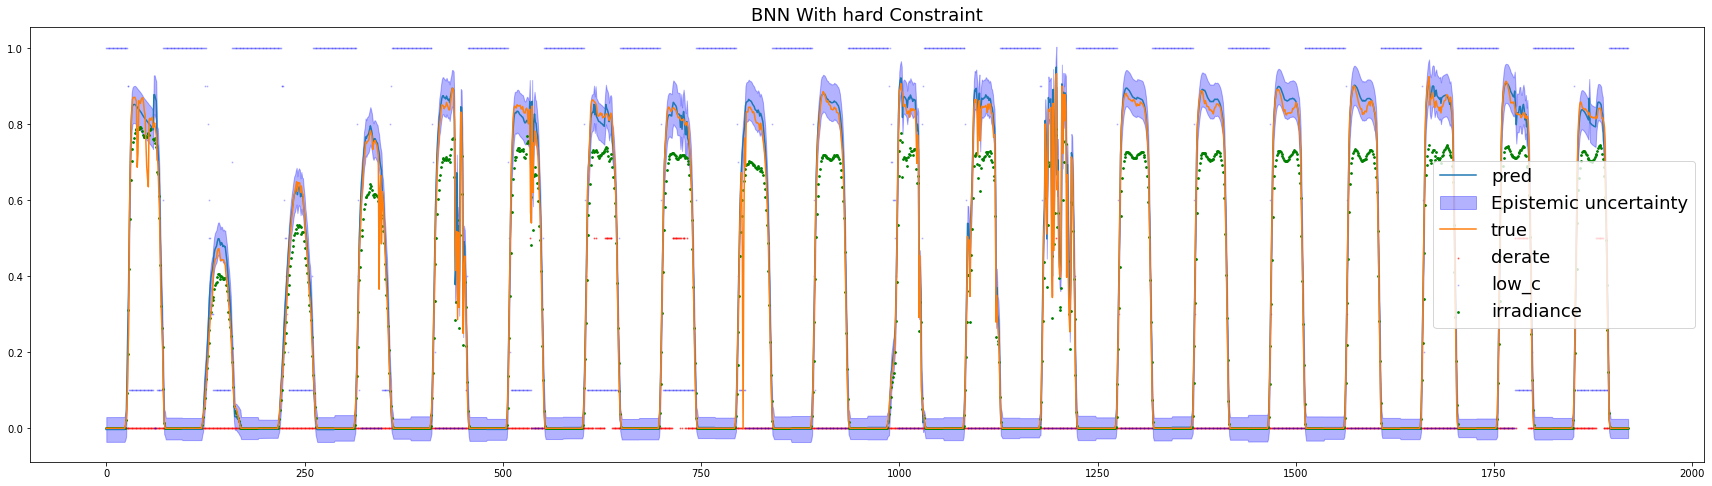

In [52]:
test_ws=test_result_ws.mean(1)
plt.figure(figsize=(30, 8))
visualization_period_1=10
visualization_period_2=30
epistemic_ws = (test_result_ws.var(axis = 1)**0.5).cpu().detach().numpy()
subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
low_subset=testX[-visualization_period_2*96:-visualization_period_1*96,6].cpu().numpy()
subset=subset.cpu().numpy()
aaa=np.where(subset>0.01)[0]/96
derate_plot=np.where(subset>0.01,0.5,0)
# low_plot=np.where(low_subset>0.01,0.2,0)
derate_plot
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

length=len(pred[-visualization_period_2*96:-visualization_period_1*96])
pred=test_ws.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
plt.title('BNN With hard Constraint',fontsize=18)
plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
plt.fill_between( np.linspace(0, length-1, length),((pred - 3*epistemic_ws)[-visualization_period_2*96:-visualization_period_1*96]),((pred + 3*epistemic_ws)[-visualization_period_2*96:-visualization_period_1*96]), alpha = 0.3,color='blue', label = 'Epistemic uncertainty')
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
plt.scatter(np.array(np.arange(len(derate_plot))),derate_plot,s=1,c='red',alpha=0.5,label='derate')
plt.scatter(np.array(np.arange(len(derate_plot))),low_subset,s=1,c='b',alpha=0.2,label='low_c')
plt.scatter(np.array(np.arange(len(derate_plot))),subset_irra,s=3,c='green',label='irradiance')
plt.legend(fontsize=18)

In [470]:
alpha=0.1
valid_w=valid_result_w.mean(1)
n=len(valid_w)
epistemic_w_valid = (valid_result_w.var(axis = 1)**0.5)
# true_value=validY.cpu().detach().numpy()
score_valid=torch.abs(validY[:,0]-valid_w)/epistemic_w_valid
qhat_w=torch.quantile(score_valid,np.ceil((n+1)*(1-alpha))/n)

In [471]:
qhat_w

tensor(6.5518, device='cuda:0', grad_fn=<SqueezeBackward3>)

In [266]:
crps_dictionary_rand_wo = em.ens_crps(true_value[:,0], test_result_wo.cpu().detach().numpy())
crps_dictionary_rand_w = em.ens_crps(true_value[:,0], test_result_w.cpu().detach().numpy())
crps_w=crps_dictionary_rand_w['crpsMean']
crps_wo=crps_dictionary_rand_wo['crpsMean']
print('with constraint crps:',crps_w,'without constraint crps:',crps_wo)

with constraint crps: 0.010855178354840287 without constraint crps: 0.012025632577805244


In [419]:
crps_dictionary_rand_wo_peak = em.ens_crps(true_value[:,0][peaktime_index], test_result_wo[peaktime_index,:].cpu().detach().numpy())
crps_dictionary_rand_w_peak = em.ens_crps(true_value[:,0][peaktime_index], test_result_w[peaktime_index,:].cpu().detach().numpy())
crps_dictionary_rand_b_peak = em.ens_crps(true_value[:,0][peaktime_index], test_result_b[peaktime_index,:])

crps_w_peak=crps_dictionary_rand_w_peak['crpsMean']
crps_wo_peak=crps_dictionary_rand_wo_peak['crpsMean']
crps_b_peak=crps_dictionary_rand_b_peak['crpsMean']

print('benchmarkt crps peak:',crps_b_peak,'with constraint crps peak:',crps_w_peak,'without constraint crps peak:',crps_wo_peak)


benchmarkt crps peak: 0.03234392529594141 with constraint crps peak: 0.016859293697513156 without constraint crps peak: 0.020205180527724617


In [275]:
def constraint_loss(series):
    derate_output=net(series)

    de_0=derate_output[:17]
    de_1=derate_output[17:]
    sub=de_0-de_1
    sub[sub<0]=0
    con_derate=torch.sum(sub)
    return con_derate

net.load_state_dict(torch.load('./know_results/summer/wo0405.pth'))
wo_constraint_loss=constraint_loss(derate_series)
print(wo_constraint_loss)

tensor(0.1800, device='cuda:0', grad_fn=<SumBackward0>)


In [272]:
net

BayesianNet(
  (hid1): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=11, out_features=64, bias=True)
  (hid2): BayesLinear(prior_mu=0, prior_sigma=0.02, in_features=64, out_features=32, bias=True)
  (oupt): BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=32, out_features=1, bias=True)
)

In [258]:
ens_array_random = (np.random.rand(15, 52) + 1) * 100  # 52 Ensembles
obs_array_random = (np.random.rand(15) + 1) * 100
noise = np.random.normal(scale=1, size=(15, 52))
x = np.linspace(1, 10, 15)
observed_array = np.sin(x) + 10
ensemble_array_noise = (np.ones((15, 52)).T * observed_array).T + noise  # 52 Ensembles
crps_dictionary_rand = em.ens_crps(obs_array_random, ens_array_random)

In [260]:
ens_array_random.shape


(15, 52)

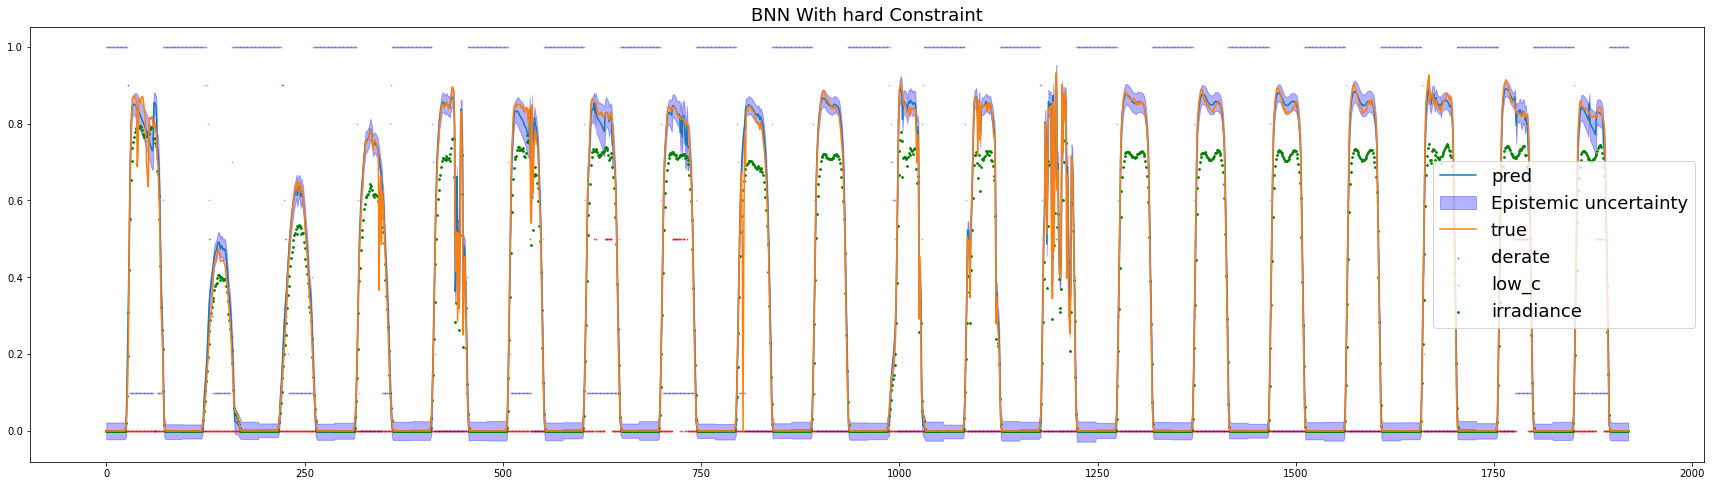

In [50]:
test_w=test_result_w.mean(1)
plt.figure(figsize=(30, 8))
visualization_period_1=10
visualization_period_2=30
epistemic_w = (test_result_w.var(axis = 1)**0.5).cpu().detach().numpy()
subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
low_subset=testX[-visualization_period_2*96:-visualization_period_1*96,6].cpu().numpy()
subset=subset.cpu().numpy()
aaa=np.where(subset>0.01)[0]/96
derate_plot=np.where(subset>0.01,0.5,0)
# low_plot=np.where(low_subset>0.01,0.2,0)
derate_plot
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

length=len(pred[-visualization_period_2*96:-visualization_period_1*96])
pred=test_w.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
plt.title('BNN With hard Constraint',fontsize=18)
plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
plt.fill_between( np.linspace(0, length-1, length),((pred - 3*epistemic_w)[-visualization_period_2*96:-visualization_period_1*96]),((pred + 3*epistemic_w)[-visualization_period_2*96:-visualization_period_1*96]), alpha = 0.3,color='blue', label = 'Epistemic uncertainty')
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
plt.scatter(np.array(np.arange(len(derate_plot))),derate_plot,s=1,c='red',alpha=0.5,label='derate')
plt.scatter(np.array(np.arange(len(derate_plot))),low_subset,s=1,c='b',alpha=0.2,label='low_c')
plt.scatter(np.array(np.arange(len(derate_plot))),subset_irra,s=3,c='green',label='irradiance')
plt.legend(fontsize=18)

In [48]:
epistemic_wo[:96]

array([0.01071877, 0.01071877, 0.01071877, 0.01071877, 0.01071877,
       0.01071877, 0.01071877, 0.01071877, 0.01071877, 0.01071877,
       0.01071877, 0.01071877, 0.01071877, 0.01071877, 0.01071877,
       0.01071877, 0.01071877, 0.01071877, 0.01071877, 0.01071877,
       0.01071877, 0.01071877, 0.01071877, 0.01334391, 0.01302194,
       0.01280545, 0.01828508, 0.02097281, 0.02034511, 0.02021264,
       0.01971425, 0.02000214, 0.02107279, 0.02025787, 0.02796094,
       0.02046495, 0.02061068, 0.02054716, 0.02083635, 0.02047491,
       0.02056223, 0.03044178, 0.02755434, 0.02090914, 0.02091747,
       0.02923557, 0.02100569, 0.02558372, 0.02159315, 0.02449667,
       0.02585398, 0.02176991, 0.02195714, 0.02201888, 0.02190143,
       0.02220284, 0.02214064, 0.02170694, 0.02231794, 0.02085087,
       0.02160177, 0.02078691, 0.02090457, 0.02093013, 0.02029928,
       0.02039401, 0.01960013, 0.02057296, 0.01939117, 0.02061183,
       0.02037925, 0.02054296, 0.02010525, 0.02122241, 0.02133

In [51]:
epistemic_w[:96]

array([0.0079688 , 0.00796892, 0.00796899, 0.00796907, 0.00796914,
       0.00796921, 0.00796928, 0.00796935, 0.00796943, 0.0079695 ,
       0.00796958, 0.00796965, 0.00796972, 0.00796979, 0.00796984,
       0.00796989, 0.00796994, 0.00797001, 0.00797021, 0.0079704 ,
       0.00797059, 0.0079707 , 0.00797082, 0.00923697, 0.00963589,
       0.00995582, 0.0106119 , 0.00925167, 0.00969124, 0.01015421,
       0.00958002, 0.00968111, 0.00710959, 0.00703299, 0.00728243,
       0.00688123, 0.00681118, 0.00679689, 0.00725025, 0.00698032,
       0.00693458, 0.00732992, 0.00728051, 0.00726136, 0.00718277,
       0.00731962, 0.0072084 , 0.00728567, 0.00715802, 0.00731156,
       0.00735972, 0.00728547, 0.00725523, 0.0072535 , 0.00726368,
       0.00724307, 0.00724385, 0.00727972, 0.00715472, 0.00695578,
       0.00702353, 0.00693601, 0.00688827, 0.00704654, 0.00734102,
       0.00736431, 0.00840346, 0.00693816, 0.00737043, 0.00706347,
       0.00731681, 0.00714695, 0.00725219, 0.00751871, 0.00723

In [41]:
epistemic_w.mean()


NameError: name 'epistemic_w' is not defined

# Peak time day time evaluation



In [164]:
daytime_index=np.where((traj_test[:,-2]>0.3900)&(traj_test[:,-2]<0.7100))[0] #9:30 am-5 pm
print(daytime_index.shape)
peaktime_index=np.where((traj_test[:,-2]>0.42)&(traj_test[:,-2]<0.5800))[0] #10 am-2 pm
print(peaktime_index.shape)

(2310,)
(1232,)


In [409]:
test_w_day=test_w[daytime_index]
test_wo_day=test_wo[daytime_index]
test_b_day=torch.tensor(test_b[daytime_index]).to(device)

test_w_peak=test_w[peaktime_index]
test_wo_peak=test_wo[peaktime_index]
test_b_peak=torch.tensor(test_b[peaktime_index]).to(device)


# test_Y_day=(testY[daytime_index]).repeat(1,n_sample)
# test_Y_peak=(testY[peaktime_index]).repeat(1,n_sample)
test_Y_day=(testY[daytime_index,0])
test_Y_peak=(testY[peaktime_index,0])
test_w_result_day=test_result_w[daytime_index,:]
test_wo_result_day=test_result_wo[daytime_index,:]
test_b_result_day=test_result_b[daytime_index,:]

test_w_result_peak=test_result_w[peaktime_index,:]
test_wo_result_peak=test_result_wo[peaktime_index,:]
test_b_result_peak=test_result_b[peaktime_index,:]

In [410]:
test_Y_peak.shape

torch.Size([1232])

In [413]:
# loss_w=loss_func(test_w_day,test_Y_day)
# loss_wo=loss_func(test_wo_day,test_Y_day)
# loss_b=loss_func(test_b_day,test_Y_day)

loss_w_peak=loss_func(test_w_peak,test_Y_peak)
loss_wo_peak=loss_func(test_wo_peak,test_Y_peak)
loss_b_peak=loss_func(test_b_peak,test_Y_peak)

# print("benchmark MSE : %6f,with constraint MSE : %6f, without constraint MSE: %6f" % (loss_b,loss_w,loss_wo))
print("peak with benchmark MSE : %6f, peak with constraint MSE : %6f, peak without constraint MSE: %6f" % (loss_b_peak,loss_w_peak,loss_wo_peak))

peak with benchmark MSE : 0.002703, peak with constraint MSE : 0.001383, peak without constraint MSE: 0.001433


In [405]:
test_wo_peak.shape


torch.Size([1232])

In [414]:
# print("benchmark NRMSE : %6f,with constraint NRMSE : %6f, without constraint NRMSE: %6f" % (torch.sqrt(loss_w),torch.sqrt(loss_w), torch.sqrt(loss_wo)))
print("benchmark peak NRMSE : %6f,with constraint NRMSE : %6f, without constraint NRMSE: %6f" % (torch.sqrt(loss_b_peak),torch.sqrt(loss_w_peak), torch.sqrt(loss_wo_peak)))

benchmark peak NRMSE : 0.051994,with constraint NRMSE : 0.037195, without constraint NRMSE: 0.037853


In [168]:
MAE= torch.nn.L1Loss()


In [417]:
loss_w_mae=MAE(test_w_day,test_Y_day)
loss_wo_mae=MAE(test_wo_day,test_Y_day)
loss_w_peak_mae=MAE(test_w_peak,test_Y_peak)
loss_wo_peak_mae=MAE(test_wo_peak,test_Y_peak)
loss_b_peak_mae=MAE(test_b_peak,test_Y_peak)

# print("with constraint MSE : %6f, without constraint MSE: %6f" % (loss_w,loss_wo))
print("peak with constraint MAE : %6f,peak with constraint MAE : %6f, peak without constraint MAE: %6f" % (loss_b_peak_mae,loss_w_peak_mae,loss_wo_peak_mae))

peak with constraint MAE : 0.034540,peak with constraint MAE : 0.020762, peak without constraint MAE: 0.024482


In [205]:
len(test_w)

7392

In [415]:


# all_day_w=r2_score(testY.cpu().detach().numpy() ,test_w.cpu().detach().numpy())
# all_day_wo=r2_score(testY.cpu().detach().numpy() ,test_wo.cpu().detach().numpy())
# all_day_b=r2_score(testY.cpu().detach().numpy() ,test_b)

# print("all day with constraint R2 : %6f, all day without constraint R2: %6f" % (all_day_w,all_day_wo))

peak_w=r2_score(test_Y_peak.cpu().detach().numpy() ,test_w_peak.cpu().detach().numpy())
peak_wo=r2_score(test_Y_peak.cpu().detach().numpy() ,test_wo_peak.cpu().detach().numpy())
peak_b=r2_score(test_Y_peak.cpu().detach().numpy() ,test_b_peak.cpu().detach().numpy())


print("peak benchmark R2 : %6f,peak with constraint R2 : %6f, peak without constraint R2: %6f" % (peak_b,peak_w,peak_wo))

# r2_score(test_Y_peak.cpu().detach().numpy() ,test_wo_result_peak.cpu().detach().numpy() )

peak benchmark R2 : 0.713326,peak with constraint R2 : 0.853293, peak without constraint R2: 0.848055


# Industrial Benchmark

In [322]:
TRAIN=torch.cat((trainX,trainY),dim=1).cpu().numpy()
TEST=torch.cat((testX,testY),dim=1).cpu().numpy()

In [528]:
time_list=np.unique(TRAIN[:,-3])
dicts = {}
keys = time_list
for i in keys:
    dicts[i] =TRAIN[TRAIN[:,-3]==i]   #dict classify different time within a day

    

In [530]:
n_sample_bench=30
def find_nearest_index(array, value, k=n_sample_bench):
    ir = array[:,3]
    index=np.argsort(abs(ir - value))[:k]
    return array[index,-1]
test_results=np.zeros((len(TEST),n_sample_bench))
for i in range(len(TEST)):
    time_number=TEST[i,-3]
    test_results[i]=find_nearest_index(dicts[time_number],TEST[i,3],n_sample_bench)
    
    
test_results.shape
test_result_b=test_results

In [390]:
crps_dictionary_rand_b = em.ens_crps(true_value[:,0], test_results)
crps_b=crps_dictionary_rand_b['crpsMean']
print('benchmark crps:',crps_b)

benchmark crps: 0.015160277607740653


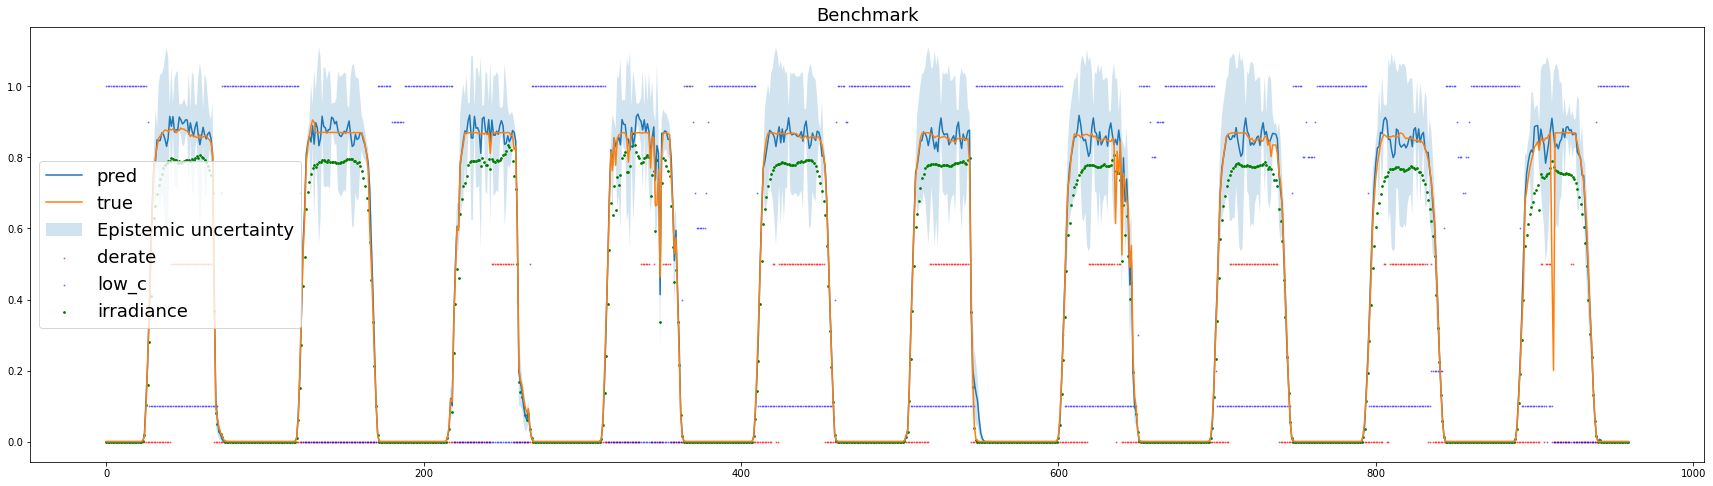

In [426]:
test_b=test_result_b.mean(1)
plt.figure(figsize=(30, 8))
visualization_period_1=50
visualization_period_2=60
epistemic_b = (test_result_b.var(axis = 1)**0.5)

subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
low_subset=testX[-visualization_period_2*96:-visualization_period_1*96,6].cpu().numpy()

subset=subset.cpu().numpy()
aaa=np.where(subset>0.01)[0]/96
derate_plot=np.where(subset>0.01,0.5,0)
derate_plot
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

pred=test_b
true_value=testY.cpu().detach().numpy()
plt.title('Benchmark',fontsize=18)
plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
length=len(pred[-visualization_period_2*96:-visualization_period_1*96])

plt.fill_between( np.linspace(0, length-1, length),((pred - epistemic_b)[-visualization_period_2*96:-visualization_period_1*96]),((pred + epistemic_b)[-visualization_period_2*96:-visualization_period_1*96]), alpha = 0.2, label = 'Epistemic uncertainty')
plt.scatter(np.array(np.arange(len(derate_plot))),derate_plot,s=1,c='red',alpha=0.5,label='derate')
plt.scatter(np.array(np.arange(len(derate_plot))),low_subset,s=1,c='b',alpha=0.4,label='low_c')

plt.scatter(np.array(np.arange(len(derate_plot))),subset_irra,s=3,c='green',label='irradiance')
plt.legend(fontsize=18)


In [393]:
epistemic_b.mean()

0.05728652875295357

In [396]:
allday_b=r2_score(testY.cpu().detach().numpy() ,test_b)
print("all day for benchmark model : %6f" % (allday_b))

# peak_w=r2_score(test_Y_peak.cpu().detach().numpy() ,test_w_peak.cpu().detach().numpy())
# peak_wo=r2_score(test_Y_peak.cpu().detach().numpy() ,test_wo_peak.cpu().detach().numpy())
# print("peak with constraint R2 : %6f, peak without constraint R2: %6f" % (peak_w,peak_wo))


all day for benchmark model : 0.990837


In [425]:
mse_b=loss_func(torch.tensor(test_b).to(device),testY[:,0])
print("Benchmark MSE: %6f"%(mse_b))

Benchmark MSE: 0.001400


# Calibration based on different time stamps

In [531]:
time_list

array([0.        , 0.01052632, 0.02105263, 0.03157895, 0.04210526,
       0.05263158, 0.06315789, 0.07368421, 0.08421052, 0.09473684,
       0.10526316, 0.11578947, 0.12631579, 0.1368421 , 0.14736842,
       0.15789473, 0.16842104, 0.17894736, 0.18947369, 0.2       ,
       0.21052632, 0.22105263, 0.23157895, 0.24210526, 0.25263157,
       0.2631579 , 0.2736842 , 0.28421053, 0.29473683, 0.30526316,
       0.31578946, 0.3263158 , 0.3368421 , 0.34736842, 0.35789472,
       0.36842105, 0.37894738, 0.38947368, 0.4       , 0.4105263 ,
       0.42105263, 0.43157893, 0.44210526, 0.45263156, 0.4631579 ,
       0.4736842 , 0.48421052, 0.49473685, 0.50526315, 0.51578945,
       0.5263158 , 0.5368421 , 0.5473684 , 0.5578947 , 0.56842107,
       0.57894737, 0.58947366, 0.59999996, 0.6105263 , 0.6210526 ,
       0.6315789 , 0.6421053 , 0.6526316 , 0.6631579 , 0.6736842 ,
       0.68421054, 0.69473684, 0.70526314, 0.71578944, 0.7263158 ,
       0.7368421 , 0.7473684 , 0.75789475, 0.76842105, 0.77894

In [539]:

#get the 15 days validation data
validX[:,-2][:1440].shape


torch.Size([1440])

In [544]:
score_valid[:1440].

torch.Size([1440])

In [591]:
#using without constraint model results
alpha=0.1
valid_wo=valid_result_wo[:1440].mean(1)
n=len(valid_wo)
epistemic_wo_valid = (valid_result_wo[:1440].var(axis = 1)**0.5)
score_valid=torch.abs(validY[:1440,0]-valid_wo)/epistemic_wo_valid
time_score_valid_wo=torch.reshape(score_valid,(15,96))
list_quantile_wo=[]
for i in range(96):
    qhat_wo=torch.quantile(time_score_valid_wo[:,i],np.ceil((15+1)*(1-alpha))/15)
    list_quantile_wo.append(qhat_wo)
list_quantile_wo= torch.stack(list_quantile_wo)
repeat_quantile_result_wo=list_quantile_wo.repeat( 77)
print(repeat_quantile_result_wo.shape)
print(list_quantile_wo)

#using with constraint model results
valid_w=valid_result_w[:1440].mean(1)
n=len(valid_w)
epistemic_w_valid = (valid_result_w[:1440].var(axis = 1)**0.5)
score_valid=torch.abs(validY[:1440,0]-valid_w)/epistemic_w_valid
time_score_valid_w=torch.reshape(score_valid,(15,96))
list_quantile_w=[]
for i in range(96):
    qhat_w=torch.quantile(time_score_valid_w[:,i],np.ceil((15+1)*(1-alpha))/15)
    list_quantile_w.append(qhat_w)
list_quantile_w= torch.stack(list_quantile_w)
repeat_quantile_result_w=list_quantile_w.repeat( 77)
print(repeat_quantile_result_w.shape)
print(list_quantile_w)

torch.Size([7392])
tensor([ 0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,
         0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.2010,
         0.2010,  0.2010,  0.2010,  0.2010,  0.2010,  0.3264,  1.4300,  2.8010,
         5.4659, 14.6294, 16.1222, 10.4676,  9.7697, 10.4892, 11.9550, 11.1398,
        11.0965, 10.4513, 10.2887, 10.1257, 24.2019, 11.5661, 12.4665, 13.4197,
        14.6233, 15.2889, 14.5843, 14.7613, 18.3193, 16.8554, 15.8707, 11.4699,
        13.4315, 10.4766, 11.3243, 16.8996, 11.3090, 10.0874, 10.3407, 12.3911,
        10.0184, 25.1082, 22.7970, 13.2461, 10.9737, 19.8499, 13.3503, 12.6507,
        12.4969, 12.4960, 12.2812, 14.2952, 16.8122, 15.7453,  9.4472,  7.9339,
         5.0429,  5.6622, 14.6618,  4.6163,  1.7594,  0.2649,  0.4126,  0.4126,
         0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126,
         0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126,  0.4126],
       device='cuda:

Text(0.5, 1.0, 'Uncertainty calibration quantiles-without constraint')

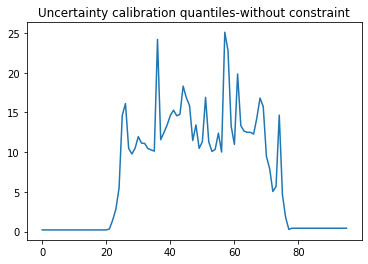

In [592]:
plt.plot(list_quantile_wo.detach().cpu().numpy())
plt.title('Uncertainty calibration quantiles-without constraint')
